# **Rèplica primera sessió - càrrega de dades**

## Experimentació càrrega de dades

In [ ]:
# Atajos útils:
# Ctrl + / --> comentar (en el numeric pad!)
# Ctrl + ç --> comentar tb

Primerament instal·lem un parell de ferramentes útils

In [ ]:
pip install -r requirements.txt
pip install lckr-jupyterlab-variableinspector

Repliquem el mecanisme de càlcul de temps d'execució

In [ ]:
# Examen d'eficiència
startTime = time.time()
alltr = pd.read_csv(r"D:\OneDrive\Universitat\5. Quart'\TFG\RstudioPython\Dades\Normal\all_train.csv")
endTime = time.time()
print(endTime-startTime)

# Tarda 63 segons! La meitat que el segon mecanisme en R.

In [ ]:
# f1000a = open(r"D:/OneDrive/Universitat/5. Quart'/TFG/RstudioPython/Dades/NoNormalTrue/xttbar_m1000_aug17.txt", mode ='r')
# f1000b = open(r"D:/OneDrive/Universitat/5. Quart'/TFG/RstudioPython/Dades/NoNormalTrue/xttbar_m1000_aug4.txt", mode ='r')
# readme = open(r"D:/OneDrive/Universitat/5. Quart'/TFG/RstudioPython/Dades/NoNormalTrue/xttbar_m1000_aug4.txt")
# lineslist = readme.readlines()
# cols, rows = (int(val) for val in lines_list[0].split())

In [ ]:
# Seleccionem únicament les dades signal/background
milTrSignal = alltr.loc[(alltr["mass"] == 1000) & (alltr["# label"] == 1)]
milTrBackground = alltr.loc[(alltr["mass"] == 1000) & (alltr["# label"] == 0)]
# adult_names = titanic.loc[titanic["Age"] > 35, "Name"]

# Error detectat: & té major prioritat que ==, així que cal emprar parèntesis!

In [ ]:
del(allTrBackground, allTrSignal) # Mètode per eliminar variables

## Càrrega de dades final

In [ ]:
# Cel·la definitiva - càrrega de dades
import pandas as pd
import numpy as np
import time

alltr = pd.read_csv(r"D:\OneDrive\Universitat\5. Quart'\TFG\RstudioPython\Dades\Normal\all_train.csv")
miltr = pd.read_csv(r"D:\OneDrive\Universitat\5. Quart'\TFG\RstudioPython\Dades\Normal\1000_train.csv")

In [ ]:
# Trunquem les dades, seleccionem únicament 10 000. A més, la separem en la informació coneguda i la que pretenem predir.
Xdata = np.array(miltr.loc[:,["f0","f1","f2","f3","f4","f5","f6","f7","f8","f9","f10","f11","f12","f13","f14","f15","f16","f17","f18","f19","f20","f21"]])
# Ydata = np.array(miltr.loc[:,"# label"])
Ydata = np.array(miltr.index)[1:10001]
Xdata = Xdata[0:10000,:]

In [ ]:
print(Xdata)

In [ ]:
print(miltr)

# **Segona sessió: normalització, matrius de correlació i decision trees**

## 1. Càrrega de dades (tr i tst)

In [2]:
# Data Processing
import pandas as pd
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import time

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

miltr = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\1000_train.csv")
miltst = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\1000_test.csv")
alltr = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\all_train.csv")
alltst = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\all_test.csv")

# del(alltr,alltst)
# del(miltr, miltst)

# Per poder emetre un so quan acaba d'executar una cel·la
from IPython.display import Audio
sound_file = "C:/Users/alexp/Downloads/beep.wav"
Audio(sound_file, autoplay=True)

## 2. Matrius de correlació

Preprocesem les dades: seleccionem solament signal (`# label == 1`) i variables HL i pTs

In [9]:
milTrSignal = miltr.loc[miltr.index == 1]
milTrSignal = miltr.loc[:,["# label","f6","f10","f14","f18","f21","f22","f23","f24","f25"]]
milTrSignal.columns = ["Lept_pt","j1_pt","j2_pt","j3_pt","j4_pt","m_jj","m_jjj","m_lv","m_jlv","m_wwbb"]

milTrBack = miltr.loc[miltr.index == 0]
milTrBack = miltr.loc[:,["# label","f6","f10","f14","f18","f21","f22","f23","f24","f25"]]
milTrBack.columns = ["Lept_pt","j1_pt","j2_pt","j3_pt","j4_pt","m_jj","m_jjj","m_lv","m_jlv","m_wwbb"]

allTrSignal = alltr.loc[alltr["# label"] == 1]
allTrSignal = alltr.iloc[:,[1,7,11,15,19,23,24,25,26,27,28]]
allTrSignal.columns = ["Lept_pt","j1_pt","j2_pt","j3_pt","j4_pt","m_jj","m_jjj","m_lv","m_jlv","m_wwbb","mass"]

Tr500Signal = allTrSignal.loc[allTrSignal["mass"] <= 500]
Tr750Signal = allTrSignal.loc[allTrSignal["mass"] == 750]
Tr1000Signal = allTrSignal.loc[allTrSignal["mass"] == 1000]
Tr1250Signal = allTrSignal.loc[allTrSignal["mass"] == 1250]
Tr1500Signal = allTrSignal.loc[allTrSignal["mass"] == 1500]

In [ ]:
print(Tr500Signal)

Representem la matriu

Text(0.5, 1.0, 'Matriu de correlació - Massa 1000 Background')

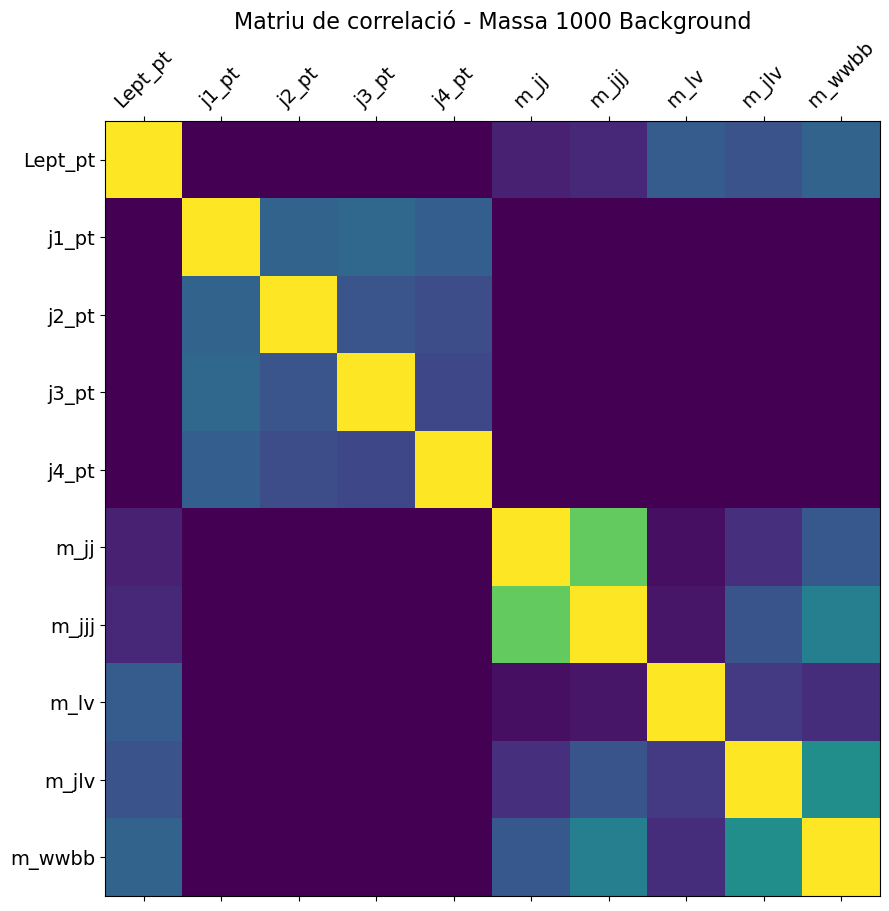

In [47]:
import matplotlib.pyplot as plt

dataframe = milTrBack
dataframe = dataframe.iloc[:,0:10]

# plt.matshow(milTrSignal.corr())
# plt.show()
f = plt.figure(figsize=(10, 10))
plt.matshow(dataframe.corr(), fignum=f.number)

plt.xticks(range(dataframe.select_dtypes(['number']).shape[1]), dataframe.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(dataframe.select_dtypes(['number']).shape[1]), dataframe.select_dtypes(['number']).columns, fontsize=14)

# ax=plt.gca() #get the current axes
# PCM=ax.get_children()[2]
# cb = plt.colorbar(PCM,ax=ax)
# cb.ax.tick_params(labelsize=14)

plt.title('Matriu de correlació - Massa 1000 Background', fontsize=16)

In [45]:
corr = dataframe.corr()
corr.style.background_gradient(cmap='coolwarm')

,Lept_pt,j1_pt,j2_pt,j3_pt,j4_pt,m_jj,m_jjj,m_lv,m_jlv,m_wwbb
Lept_pt,1.000000,-0.000065,0.000439,-0.000164,0.000665,0.090895,0.115301,0.289434,0.253861,0.319434
j1_pt,-0.000065,1.000000,0.317722,0.332589,0.299979,0.000429,0.000596,-0.000782,-0.000133,0.000458
j2_pt,0.000439,0.317722,1.000000,0.262361,0.236009,0.000290,0.000139,-0.000703,-0.000137,0.000417
j3_pt,-0.000164,0.332589,0.262361,1.000000,0.218003,0.000233,0.000538,-0.000221,0.000119,0.000584
j4_pt,0.000665,0.299979,0.236009,0.218003,1.000000,-0.000263,-0.000567,-0.000150,0.000383,-0.000066
m_jj,0.090895,0.000429,0.000290,0.000233,-0.000263,1.000000,0.759044,0.039548,0.139457,0.276138
m_jjj,0.115301,0.000596,0.000139,0.000538,-0.000567,0.759044,1.000000,0.060612,0.258423,0.432481
m_lv,0.289434,-0.000782,-0.000703,-0.000221,-0.000150,0.039548,0.060612,1.000000,0.169085,0.131144
m_jlv,0.253861,-0.000133,-0.000137,0.000119,0.000383,0.139457,0.258423,0.169085,1.000000,0.493482
m_wwbb,0.319434,0.000458,0.000417,0.000584,-0.000066,0.276138,0.432481,0.131144,0.493482,1.000000


In [ ]:
print(dataframe)

## 3. Decision Trees

### Repliquem decision trees

Estudiem una mica algunes de les funcions que emprarem (`array` [bàsic de numpy], `bincount`, `arange`, `argwhere`, `flatten`)

In [ ]:
# bincount diguem-ne que fa un histograma de l'array
y = np.array([1,2,3,1,2])
np.bincount(y)

In [ ]:
# np.argwhere(condition) troba els elements que compleixen la condició
# .flatten ho transforma en vector, en comptes de llista de llistes
x = np.arange(5)
np.argwhere(x<3).flatten()

In [ ]:
# Algoritme per a Decision Trees basat en https://www.youtube.com/watch?v=NxEHSAfFlK8&list=PLcWfeUsAys2k_xub3mHks85sBHZvg24Jd&index=5
# Un parell d'ajusts, en la línia 94, afegisc un pas addicional per compatibilitzar bincounts amb les dades (float). No estic segur de si és adequat.


# L'asterisc força a passar value explícitament quan es cree un node: Node(value = blabla)
import numpy as np
from collections import Counter

class Node():
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None # Si existeix un valor, aleshores hi ha al menys un fill, per tant no és --> false
        

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root = self._grow_tree(X,y)
        
    def _grow_tree(self, X, y, depth = 0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))
        
        # Check the stopping criteria
        if (depth>=self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
        # Si tenim el màxim de profunditat, si tenim un node pur o arribem al mínim de mostres, no crearem més
        
        feat_idx = np.random.choice(n_feats, self.n_features, replace = False)
        
        # Find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idx) # Lloc on incloem la part aleatòria dels DT
        
        # Create child nodes
        left_idxs, right_idxs = self._split(X[:,best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs,:],y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs,:],y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)
        
        
    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None
        
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            
            for thr in thresholds:
                # Calculate Information gain
                gain = self._information_gain(y, X_column, thr)
                
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr
        
        return split_idx, split_threshold
    
    def _information_gain(self, y, X_column, threshold):
        # Parent entropy
        parent_entropy = self._entropy(y)
        
        # Create children
        left_idxs, right_idxs = self._split(X_column, threshold)
        
        if(len(left_idxs) == 0 or len(right_idxs) == 0):
           return 0
        
        # Calculate weighted avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]),self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r    
           
        # Calculate IG
        information_gain = parent_entropy - child_entropy
        return information_gain
        
    def _entropy(self, y):
        uniq, inverse = np.unique(y, return_inverse=True) # Afegit per mi per poder fer el mateix amb floats en comptes d'int
        hist = np.bincount(inverse)
        ps = hist / len(y)
        return -np.sum([p*np.log(p) for p in ps if p > 0])
   
    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs
        
        
    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0] # Mirar en Logistic Regression
        return value
                        

    def predict(self,X):
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
           return node.value
           
        if x[node.feature] <= node.threshold:
           return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)



Emprem aquest DT *artesanal* amb els datasets proposats al vídeo.

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np

# from DecisionTree import DecisionTree

data = datasets.load_breast_cancer()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state = 1234
)

clf = DecisionTree()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)
    
acc = accuracy(y_test, predictions)
print(acc)

# Jugar amb més max_depth, diferents paràmetres

In [ ]:
print(Xdata)

Intentem emprar aquest DT amb els nostres datasets. Seleccionem les columnes LL per a Xdata i els índexs per al Ydata

In [ ]:
# Prova 1: trunquem les dades, seleccionem únicamen 10 000
Xdata = np.array(miltr.loc[:,["f0","f1","f2","f3","f4","f5","f6","f7","f8","f9","f10","f11","f12","f13","f14","f15","f16","f17","f18","f19","f20","f21"]])
# Ydata = np.array(miltr.loc[:,"# label"])
Ydata = np.array(miltr.index)[1:10001]
Xdata = Xdata[0:10000,:]

In [ ]:
# Prova 2: no fem split en test i train,  
Xdata = np.array(miltr.loc[:,["f0","f1","f2","f3","f4","f5","f6","f7","f8","f9","f10","f11","f12","f13","f14","f15","f16","f17","f18","f19","f20","f21"]])
# Ydata = np.array(miltr.loc[:,"# label"])
Ydata = np.array(miltr.index)[0:50000]
Xdata = Xdata[0:50000,:]

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

startTime = time.time()

X, y = Xdata, Ydata

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1, random_state = 1234
)

clf = DecisionTree(min_samples_split = 500, max_depth=4)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)
    
acc = accuracy(y_test, predictions)
print(acc)

endTime = time.time()
print(endTime-startTime)

# Prova 1 amb 10.000 dades, None, None --> precisió de 1.0, temps d'execució ~ 15 minuts
# Prova 2 amb 100.000 dades, min_samples_split = 500, max_depth=4 --> precisió de ; temps d'execució > 4 hores, descartat

In [ ]:
print(clf.fit)

### Ferramentes sklearn

Una vegada hem replicat el codi bàsic d'un DT i hem interioritzat el procediment, emprem la llibreria sklearn, amb algoritmes més
testats i optimitzats, entenc.
El mètode anterior és ilustratiu, però inviable en termes de temps d'execució.

In [ ]:
# Prova 3: amb tots els esdeveniments
Ydata = np.array(miltr.index)
Xdata = np.array(miltr.loc[:,["f0","f1","f2","f3","f4","f5","f6","f7","f8","f9","f10","f11","f12","f13","f14","f15","f16","f17","f18","f19","f20","f21"]])

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt
startTime = time.time()

clf = tree.DecisionTreeClassifier(max_depth = 5)
clf = clf.fit(Xdata, Ydata)

# tree.plot_tree(clf)

endTime = time.time()
print(endTime-startTime) 

# Prova 2: 13 segons!?!?!
# Prova 3 (tots els esdeveniments, max_depth = 5): 174 segons?


# El plot del tree és un infern quan té massa depth, obviar.

In [ ]:
tree.plot_tree(clf)

Carreguem ara també les dades test per avaluar el Tree

In [ ]:
miltst = pd.read_csv(r"D:\OneDrive\Universitat\5. Quart'\TFG\RstudioPython\Dades\Normal\1000_test.csv")

In [ ]:
Ytst = np.array(miltst.iloc[:,0])
Xtst = np.array(miltst.loc[:,["# label","f0","f1","f2","f3","f4","f5","f6","f7","f8","f9","f10","f11","f12","f13","f14","f15","f16","f17","f18","f19","f20"]])

In [ ]:
# print(miltst)
# print(Xtst)
# print(Ytst)

`score` sembla que calcula la precisió mitjana (https://github.com/scikit-learn/scikit-learn/blob/093e0cf14/sklearn/base.py#L680) 

In [ ]:
acc = clf.score(Xtst, Ytst)
print(acc)

Ara, unifiquem totes les parts de l'avaluació:

0. Càrrega de dades
1. Preparació de les dades i selecció de variables
2. Càlcul del DT
3. Avaluació del DT

In [ ]:
Ydata = np.array(alltr.iloc[:,[0]])

print(Ydata)

In [ ]:
print(alltr)

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt

In [ ]:
# Part 1: definim Ydata, Ytst per a tots i Xdata, Xtst per a cada cas 
# Ydata = np.array(miltr.index)
# Ytst = np.array(miltst.iloc[:,0])

Ydata = np.array(alltr.iloc[:,[0]])
Ytst = np.array(alltst.iloc[:,0])


# a) LL 
# Xdata = np.array(miltr.loc[:,["# label","f0","f1","f2","f3","f4","f5","f6","f7","f8","f9","f10","f11","f12",
#                               "f13","f14","f15","f16","f17","f18","f19","f20"]])
# Xtst = np.array(miltst.loc[:,["# label","f0","f1","f2","f3","f4","f5","f6","f7","f8","f9","f10","f11","f12"
#                               ,"f13","f14","f15","f16","f17","f18","f19","f20"]])

# b) LL + HL 
# Xdata = np.array(miltr.loc[:,["# label","f0","f1","f2","f3","f4","f5","f6","f7","f8","f9","f10","f11","f12",
#                               "f13","f14","f15","f16","f17","f18","f19","f20","f21","f22","f23","f24","f25"]])
# Xtst = np.array(miltst.loc[:,["# label","f0","f1","f2","f3","f4","f5","f6","f7","f8","f9","f10","f11","f12",
#                               "f13","f14","f15","f16","f17","f18","f19","f20","f21","f22","f23","f24","f25"]])

# c) Selecció 1: f6 + HL
# Xdata = np.array(miltr.iloc[:,["f6","f21","f22","f23","f24","f25"]])
# Xtst = np.array(miltst.iloc[:,["f6","f21","f22","f23","f24","f25"]])

# d) Selecció 2
# Xdata = np.array(miltr.iloc[:,[0,3,6,26]])
# Xtst = np.array(miltst.iloc[:,[1,4,7,27]])


# e) Alltr: d + mass
# Xdata = np.array(alltr.iloc[:,[1,4,7,27,28]])
# Xtst = np.array(alltst.iloc[:,[1,4,7,27,28]])

# f) Alltr: LL 
# Xdata = np.array(alltr.loc[:,["f0","f1","f2","f3","f4","f5","f6","f7","f8","f9","f10","f11","f12",
#                               "f13","f14","f15","f16","f17","f18","f19","f20","f21"]])
# Xtst = np.array(alltst.loc[:,["f0","f1","f2","f3","f4","f5","f6","f7","f8","f9","f10","f11","f12"
#                               ,"f13","f14","f15","f16","f17","f18","f19","f20","f21"]])

# g) Alltr: LL + HL 
# Xdata = np.array(alltr.loc[:,["f0","f1","f2","f3","f4","f5","f6","f7","f8","f9","f10","f11","f12",
#                               "f13","f14","f15","f16","f17","f18","f19","f20","f21","f22","f23","f24","f25","f26","mass"]])
# Xtst = np.array(alltst.loc[:,["f0","f1","f2","f3","f4","f5","f6","f7","f8","f9","f10","f11","f12",
#                               "f13","f14","f15","f16","f17","f18","f19","f20","f21","f22","f23","f24","f25","f26","mass"]])

# h) Alltr: 3 5 6 26 27
# Xdata = np.array(alltr.iloc[:,[3,5,6,26,27]])
# Xtst = np.array(alltst.iloc[:,[3,5,6,26,27]])

# i) Alltr: 0 26 27
Xdata = np.array(alltr.loc[:,["f0","f26","mass"]])
Xtst = np.array(alltst.loc[:,["f0","f26","mass"]])



# Part 2: Càlcul DT
from sklearn import tree
import matplotlib.pyplot as plt
startTime = time.time()

clf = tree.DecisionTreeClassifier(max_depth = 4)
clf = clf.fit(Xdata, Ydata)

temps = time.time() - startTime

print(temps)


# Part 3: Avaluació DT
acc = clf.score(Xtst, Ytst)
print(acc)

### Precisions 

- miltr LL, max_depth = 5, miltst:         0.54265

- miltr LL+HL, max_depth = 5, miltst:      0.68485 (temps = 202 s)
- miltr LL+HL, max_depth = 8, miltst:      0.65410 (temps = 350 s)
- miltr LL+HL, max_depth = 4, miltst:      0.72376 (temps = 157 s)
- miltr LL+HL, max_depth = 3, miltst:      0.74780 (temps = 115 s) !!
- miltr LL+HL, max_depth = 2, miltst:      0.57717 (temps =  75 s)

- miltr selecció 1, max_depth = 2, miltst: 0.66136 (temps = 20 s)
- miltr selecció 1, max_depth = 3, miltst: 0.66163 (temps = 29 s)
- miltr selecció 1, max_depth = 4, miltst: 0.66231 (temps = 39 s)

- miltr selecció 2, max_depth = 3, miltst: 0.90009 (temps = 21 s) !! Seleccione aquestes variables pq són les que empra en t = 115 
- miltr selecció 2, max_depth = 4, miltst: 0.90504 (temps = 28 s)
- miltr selecció 2, max_depth = 2, miltst: 0.89052 (temps = 14 s)
- miltr selecció 2, max_depth = 5, miltst: 0.90687 (temps = 36 s)
- miltr selecció 2, max_depth = 6, miltst: 0.90724 (temps = 43 s)


- alltr d + mass, max_depth = 3, alltst:   0.80764 (temps = 22 s)
- alltr d + mass, max_depth = 4, alltst:   0.82198 (temps = 31 s)
- alltr d + mass, max_depth = 2, alltst:   0.80764 (temps = 22 s)
- alltr d + mass, max_depth = 5, alltst:   0.83335 (temps = 35 s)

- alltr LL, max_depth = 8, alltst:         0.81532 (temps = 288 s)
- alltr LL + HL, max_depth = 8, alltst:    0.84975 (temps = 360 s)
- alltr h, max_depth = 2, alltst:          0.76904 (temps =  16 s)
- alltr h, max_depth = 4, alltst:          0.77089 (temps =  31 s)
- alltr i, max_depth = 4, alltst:          0.79936 (temps =  17 s)

Per calcular l'error de les precisions, potser es podria plantejar dividir la mostra de test i després fer la desviació de la precisió? Quin rigor tindria?

In [ ]:
tree.plot_tree(clf)

In [ ]:
# print(Xdata)
# print(Ydata)
# print(Xtst)
# print(miltr)
# print(miltst)

# Xdata = np.array(miltr.iloc[:,[0,3,6,26]])
# Xtst = np.array(miltst.iloc[:,[1,4,7,27]])

### Càlcul i avaluació completa amb accuracy + kappa + F1-score

In [ ]:
import math
# Comprovació del mecanisme per a calcular
# temp = np.array(alltr.loc[:,["f25","f26"]])
# temp[:,0] = temp[:,0]/temp[:,1]

In [16]:
# Part 1: definim Ydata, Ytst per a tots i Xdata, Xtst per a cada cas 
from sklearn import tree
import matplotlib.pyplot as plt
startTime = time.time()

Ydata = np.array(miltr.index)
Ytst = np.array(miltst.iloc[:,0])

# Ydata = np.array(alltr.iloc[:,[0]])
# Ytst = np.array(alltst.iloc[:,0])

# d) Selecció 2
Xdata = np.array(miltr.iloc[:,[0,3,6,26]])
Xtst = np.array(miltst.iloc[:,[1,4,7,27]])
label = "d"

# j) Alltr: 0 25 26 27
# Xdata = np.array(alltr.loc[:,["f0","f25","f26","mass"]])
# Xtst = np.array(alltst.loc[:,["f0","f25","f26","mass"]])
# label = "j"

# k) Alltr: HL + # label  --> Solament selecciona el mateix que j, almenys fins a depth = 5
# Xdata = np.array(alltr.loc[:,["f0","f22","f23","f24","f25","f26","mass"]])
# Xtst = np.array(alltst.loc[:,["f0","f22","f23","f24","f25","f26","mass"]])
# label = "k"

# l) Altres variables? Masses invariants pseudonormalitzades?
# Xdata = np.array(alltr.loc[:,["f0","f25","f26","mass"]])
# Xtst = np.array(alltst.loc[:,["f0","f25","f26","mass"]])
# Xdata[:,2] = Xdata[:,2] / Xdata[:,3]
# Xdata[:,1] = Xdata[:,1] / Xdata[:,3]
# Xtst[:,2] = Xtst[:,2] / Xtst[:,3]
# Xtst[:,1] = Xtst[:,1] / Xtst[:,3]
# label = "l"

# m) Altres variables? Masses invariants pseudonormalitzades?
# Xdata = np.array(alltr.loc[:,["f0","f25","f26","mass"]])
# Xtst = np.array(alltst.loc[:,["f0","f25","f26","mass"]])
# Xdata[:,2] = Xdata[:,2] / np.log(Xdata[:,3])
# Xdata[:,1] = Xdata[:,1] / np.log(Xdata[:,3])
# Xtst[:,2] = Xtst[:,2] / np.log(Xtst[:,3])
# Xtst[:,1] = Xtst[:,1] / np.log(Xtst[:,3])
# label = "m"
# Sembla que millora molt lleugerament!?



# Part 2: Càlcul DT

# from sklearn import tree
# from sklearn import metrics
# import matplotlib.pyplot as plt

clf = tree.DecisionTreeClassifier(max_depth = 13)
clf = clf.fit(Xdata, Ydata)


# Part 3: Avaluació DT
Ypred = clf.predict(Xtst)
acc = clf.score(Xtst, Ytst)
kappa = metrics.cohen_kappa_score(Ypred,Ytst)
F1S = metrics.f1_score(Ytst,Ypred)

temps = time.time() - startTime

# print("DT amb profunditat %i.\nPrecisió = %f; kappa = %f; F1-Score = %f.\nTemps d'execució = %i segons" 
#       % (clf.get_depth(),acc,kappa,F1S,temps)) # Format agradable

print("| %s | %i | %f | %f | %f | %i |" % (label,clf.get_depth(),acc,kappa,F1S,temps)) # Format per copiar i pegar a la taula
Audio(sound_file, autoplay=True)

| d | 13 | 0.909219 | 0.818441 | 0.910671 | 109 |


### Taula amb els diferents resultats

| labels | Max_depth |  Acc  | Kappa | F1-S | Temps (s) |
|:------:|:---------:|:-----:|:-----:|:----:|-------|
| *Proves amb miltr* |
| d | 2 | 0.890521 | 0.781038 | 0.887665 | 19 |
| d | 3 | 0.900094 | 0.800189 | 0.900821 | 25 |
| d | 4 | 0.905037 | 0.810078 | 0.907020 | 33 |
| d | 5 | 0.906873 | 0.813750 | 0.908726 | 41 |
| d | 6 | 0.907243 | 0.814490 | 0.909205 | 48 |
| d | 7 | 0.907703 | 0.815411 | 0.909874 | 60 |
| d | 8 | 0.908740 | 0.817482 | 0.909958 | 68 |
| d | 9 | 0.909087 | 0.818176 | 0.910159 | 77 |
| d | 10 | 0.909383 | 0.818768 | 0.910787 | 88 |
| d | 11 | 0.909549 | 0.819101 | 0.911013 | 95 |
| d | 12 | 0.909472 | 0.818946 | 0.910744 | 101 |
| d | 13 | 0.909219 | 0.818441 | 0.910671 | 109 |
| *Proves amb alltr* |
| j | 2 | 0.769049 | 0.538069 | 0.751082 | 17 |
| j | 3 | 0.780025 | 0.560112 | 0.811145 | 22 |
| j | 4 | 0.799363 | 0.598737 | 0.805066 | 28 |
| j | 5 | 0.814112 | 0.628248 | 0.827549 | 35 |
| j | 6 | 0.816163 | 0.632358 | 0.832628 | 41 |
| j | 7 | 0.821382 | 0.642784 | 0.832045 | 51 |
| k | 2 | 0.769049 | 0.538069 | 0.751082 | 25 |
| k | 5 | 0.814112 | 0.628248 | 0.827549 | 58 |
| l | 5 | 0.669295 | 0.338461 | 0.571760 | 26 |
| m | 5 | 0.814721 | 0.629476 | 0.832802 | 39 |
| m | 7 | 0.821215 | 0.642457 | 0.835248 | 53 |


Dubtes 02/11:
- Com avalue per a diferents masses? Al paper s'empra un únic resultat i s'avalua amb diferents masses per fer la taula 1?
- Sembla que l'entrenament amb miltr és més efectiu però potser pq no cal que tinga en compte la massa.

In [ ]:
print(miltr)

## 4. RandomForest

### Repliquem Random Forest

In [ ]:
# Reemprem
import numpy as np
from collections import Counter

class Node():
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None # Si existeix un valor, aleshores hi ha al menys un fill, per tant no és --> false
        

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root = self._grow_tree(X,y)
        
    def _grow_tree(self, X, y, depth = 0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))
        
        # Check the stopping criteria
        if (depth>=self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
        # Si tenim el màxim de profunditat, si tenim un node pur o arribem al mínim de mostres, no crearem més
        
        feat_idx = np.random.choice(n_feats, self.n_features, replace = False)
        
        # Find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idx) # Lloc on incloem la part aleatòria dels DT
        
        # Create child nodes
        left_idxs, right_idxs = self._split(X[:,best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs,:],y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs,:],y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)
        
        
    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None
        
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            
            for thr in thresholds:
                # Calculate Information gain
                gain = self._information_gain(y, X_column, thr)
                
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr
        
        return split_idx, split_threshold
    
    def _information_gain(self, y, X_column, threshold):
        # Parent entropy
        parent_entropy = self._entropy(y)
        
        # Create children
        left_idxs, right_idxs = self._split(X_column, threshold)
        
        if(len(left_idxs) == 0 or len(right_idxs) == 0):
           return 0
        
        # Calculate weighted avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]),self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r    
           
        # Calculate IG
        information_gain = parent_entropy - child_entropy
        return information_gain
        
    def _entropy(self, y):
        uniq, inverse = np.unique(y, return_inverse=True) # Afegit per mi per poder fer el mateix amb floats en comptes d'int
        hist = np.bincount(inverse)
        ps = hist / len(y)
        return -np.sum([p*np.log(p) for p in ps if p > 0])
   
    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs
        
        
    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0] # Mirar en Logistic Regression
        return value
                        

    def predict(self,X):
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
           return node.value
           
        if x[node.feature] <= node.threshold:
           return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)



In [ ]:
# from DecisionTree import DecisionTree
import numpy as np
from collections import Counter
class RandomForest:
    def __init__(self,n_trees=10,max_depth=10,min_samples_split=2,n_feature=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_feature
        self.trees= []
    
    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth = self.max_depth,
                         min_samples_split = self.min_samples_split,
                         n_features = self.n_features)
            X_sample, y_sample = self._bootstrap_samples(X,y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

            
    def _bootstrap_samples(self,X,y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples,n_samples, replace = True)
        return X[idxs], y[idxs]
    
    def _most_common_label(self,y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        
    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees]) 
        # amb açò, tindríem una llista de n llistes, on cada llista és el conjunt de prediccions del n-èsim tree
        # volem tindre una llista de n llistes, on la llista n conté les prediccions de cada tree per a l'esdeveniment n-èsim
        tree_preds = np.swapaxes(predictions,0,1) # Aquesta funció de np fa precisament açò!
        predictions = np.array([self._most_common_label(pred) for pred in tree_preds])
        return predictions
    
# Prou senzill pq es basa en DT

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
# from RandomForest import RandomForest

data = datasets.load_breast_cancer()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 1234
)

def accuracy(y_true,y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

clf = RandomForest()
clf.fit(X_train,y_train)
predictions = clf.predict(X_test)
acc = accuracy(y_test,predictions)
print(acc)

In [ ]:
del(acc, predictions, clf, data, X, y, X_train, X_test, y_train, y_test)

### Noves llibreries?

In [ ]:
import sys
print(sys.version)

In [ ]:
conda update jupyterlab

In [ ]:
# Instal·lem altres paquets (prerequisits)
# install -c anaconda python-graphviz
# install -c anaconda pydot

import sys
!conda install --yes --prefix {sys.prefix} python-graphviz

In [ ]:
!pip install graphviz # Sembla haver funcionat

In [ ]:
!pip list # Comprova la llista de llibreries instal·lades

### Random Forest - sklearn

Càrrega de llibreries
https://www.datacamp.com/tutorial/random-forests-classifier-python


In [ ]:
# Data Processing
import pandas as pd
import time
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

Repetim ara amb RF

In [ ]:
# Part 1: definim Ydata, Ytst per a tots i Xdata, Xtst per a cada cas 
startTime = time.time()

Ydata = np.array(miltr.index)
Ytst = np.array(miltst.iloc[:,0])

# Ydata = alltr.iloc[:,0]
# Ytst = alltst.iloc[:,0]

# d) Selecció 2
Xdata = np.array(miltr.iloc[:,[0,3,6,26]])
Xtst = np.array(miltst.iloc[:,[1,4,7,27]])
label = "d"

# j) Alltr: 0 25 26 27
# Xdata = np.array(alltr.loc[:,["f0","f25","f26","mass"]])
# Xtst = np.array(alltst.loc[:,["f0","f25","f26","mass"]])
# label = "j"

# j2) Alltr: 0 25 26 27
# Xdata = alltr.loc[:,["f0","f25","f26","mass"]]
# Xtst = alltst.loc[:,["f0","f25","f26","mass"]]
# label = "j2"


# Part 2: càlcul RF
# Create a random forest classifier
max_depth = 5
n_estimators = 5
rf = RandomForestClassifier(max_depth = max_depth,n_estimators = n_estimators)
rf.fit(Xdata, Ydata)

       
# Part 3: avaluació RF
Ypred = rf.predict(Xtst)
acc = accuracy_score(Ytst,Ypred)
kappa = metrics.cohen_kappa_score(Ypred,Ytst)
F1S = metrics.f1_score(Ytst,Ypred)
temps = time.time() - startTime

# print("RT amb profunditat %i.\nPrecisió = %f; kappa = %f; F1-Score = %f.\nTemps d'execució = %i segons" 
#       % (max_depth,acc,kappa,F1S,temps)) # Format agradable

print("| %s | %i | %i | %f | %f | %f | %i |" % (label,max_depth,n_estimators,acc,kappa,F1S,temps)) # Format per copiar i pegar a la taula

In [ ]:
print(alltr.loc[:,["f0","f25","f26","mass"]])

In [ ]:
print(rf)

In [ ]:
prova = alltr.loc[:,["f0","f25","f26","mass"]]
for i in range(3):
    tree = rf.estimators_[i]
    data = export_graphviz(tree,
                               feature_names=prova.columns,  
                               filled=True,  
                               max_depth=3, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(data)
    display(graph)

### Resultats Random Forest

| labels | Max_depth | n_estimators |  Acc  | Kappa | F1-S | Temps (s) |
|:------:|:---------:|:-----:|:-----:|:----:|:-----:|-------|
| *Proves amb miltr* |
| d | 5 | 5 | 0.907114 | 0.814232 | 0.908994 | 107 |
| d | 3 | 6 | 0.900202 | 0.800404 | 0.900286 | 80 |
| d | 3 | 10 | 0.904306 | 0.808612 | 0.904545 | 130 |
| *Proves amb alltr* |
| j | 10 | 10 | 0.823783 | 0.647591 | 0.836971 | 331 |
| j | 7 | 5 | 0.819847 | 0.639717 | 0.832060 | 128 |
| j | 5 | 5 | 0.805153 | 0.610320 | 0.812224 | 93 |
| j | 3 | 10 | 0.786887 | 0.573767 | 0.782951 | 105 |
| j2 | 5 | 5 | 0.804870 | 0.609750 | 0.810402 | 80 |


### RandomizedSearchCV?

El mateix, però ara amb `RandomizedSearchCV`:

In [ ]:
# Part 1: definim Ydata, Ytst per a tots i Xdata, Xtst per a cada cas ----------
startTime = time.time()

# Ydata = np.array(miltr.index)
# Ytst = np.array(miltst.iloc[:,0])

Ydata = np.array(alltr.iloc[:,0])
Ytst = np.array(alltst.iloc[:,0])

# d) Selecció 2
# Xdata = np.array(miltr.iloc[:,[0,3,6,26]])
# Xtst = np.array(miltst.iloc[:,[1,4,7,27]])
# label = "d"

# j) Alltr: 0 25 26 27
Xdata = np.array(alltr.loc[:,["f0","f25","f26","mass"]])
Xtst = np.array(alltst.loc[:,["f0","f25","f26","mass"]])
label = "j"



# Part 2: càlcul RF aleatoritzat
rf = RandomForestClassifier()
param_dist = {'n_estimators': randint(1,20),
         'max_depth': randint(1,5)} # Paràmetres
# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)
rand_search.fit(Xdata,Ydata)



# Part 3: avaluació RF
Ypred = rand_search.predict(Xtst)
acc = accuracy_score(Ytst,Ypred)
kappa = metrics.cohen_kappa_score(Ypred,Ytst)
F1S = metrics.f1_score(Ytst,Ypred)
temps = time.time() - startTime

# print("RT amb profunditat %i.\nPrecisió = %f; kappa = %f; F1-Score = %f.\nTemps d'execució = %i segons" 
#       % (max_depth,acc,kappa,F1S,temps)) # Format agradable

print("| %s | %i | %i | %f | %f | %f | %i |" % (label,param_dist.get("max_depth"),param_dist.get(n_estimators),acc,kappa,F1S,temps)) # Format per copiar i pegar a la taula
Audio(sound_file, autoplay=True)

In [ ]:
# print("| %s | %i | %i | %f | %f | %f | %i |" % (label,param_dist.get("max_depth"),param_dist.get(n_estimators),acc,kappa,F1S,temps)) # Format per copiar i pegar a la taula
print(randint(1,10))

### Resultats Taula RandomizedSearchCV

| labels | Max_depth | n_estimators |  Acc  | Kappa | F1-S | Temps (s) |
|:------:|:---------:|:-----:|:-----:|:----:|:-----:|-------|
| *Proves amb miltr* |
||
| *Proves amb alltr* |
||

## 5. AdaBoost

Directament amb sklearn

In [ ]:
# Load libraries
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets
# Import train_test_split function
from sklearn.model_selection import train_test_split
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

De nou, emprem pràcticament el mateix codi:

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
# Part 1: definim Ydata, Ytst per a tots i Xdata, Xtst per a cada cas 
startTime = time.time()

Ydata = np.array(miltr.index)
Ytst = np.array(miltst.iloc[:,0])

# Ydata = np.array(alltr.iloc[:,0])
# Ytst = np.array(alltst.iloc[:,0])

# d) Selecció 2
Xdata = np.array(miltr.iloc[:,[0,3,6,26]])
Xtst = np.array(miltst.iloc[:,[1,4,7,27]])
label = "d"

# j) Alltr: 0 25 26 27
# Xdata = np.array(alltr.loc[:,["f0","f25","f26","mass"]])
# Xtst = np.array(alltst.loc[:,["f0","f25","f26","mass"]])
# label = "j"


# Part 2: càlcul AdaBoost
# Create an AdaBoost classifier
n_estimators = 10
learning_rate = 1
rf = AdaBoostClassifier(n_estimators = n_estimators, learning_rate = learning_rate)
rf.fit(Xdata, Ydata)

       
# Part 3: avaluació AdaBoost
Ypred = rf.predict(Xtst)
acc = accuracy_score(Ytst,Ypred)
kappa = metrics.cohen_kappa_score(Ypred,Ytst)
F1S = metrics.f1_score(Ytst,Ypred)
temps = time.time() - startTime

# print("RT amb profunditat %i.\nPrecisió = %f; kappa = %f; F1-Score = %f.\nTemps d'execució = %i segons" 
#       % (max_depth,acc,kappa,F1S,temps)) # Format agradable

print("| %s | %.2f | %i | %f | %f | %f | %i |" % (label,learning_rate,n_estimators,acc,kappa,F1S,temps)) # Format per copiar i pegar a la taula
Audio(sound_file, autoplay=True)

### Resultats Taula AdaBoost

| labels | learning_rate | n_estimators |  Acc  | Kappa | F1-S | Temps (s) |
|:------:|:---------:|:-----:|:-----:|:----:|:-----:|-------|
| *Proves amb miltr* |
| d | 1.00 | 10 | 0.900278 | 0.800557 | 0.901410 | 106 |
| *Proves amb alltr* |
| j | 1.000 | 10 | 0.786525 | 0.573037 | 0.779163 | 97 |
| j | 2.000 | 10 | 0.230951 | -0.538002 | 0.282435 | 93 |
| j | 0.500 | 10 | 0.782417 | 0.564828 | 0.778332 | 100 |
| j | 0.500 | 20 | 0.788068 | 0.576123 | 0.780117 | 241 |
| j | 1.000 | 100 | 0.792516 | 0.585020 | 0.785506 | 962 |


# **Tercera sessió: masses invariants, dispersió mesuradors, representació DT**

## *1. Càlcul de la massa invariant en funció dels pt*

### Experimentació inicial

In [ ]:
alltr = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\all_train.csv")

In [ ]:
alltr.columns = ["Signal","l_pt","l_eta","l_phi","MET","M_phi","njets","pt1","eta1","phi1","b1","pt2","eta2","phi2","b2",
                 "pt3","eta3","phi3","b3","pt4","eta4","phi4","b4","m_jj","m_jjj","m_lv","m_jlv","m_wwbb","mass"]

In [ ]:
print(alltr.loc[:,["b1","b2","b3","b4"]]) # --> 10,14,18,22
# alltr.iloc[:,[10,14,18,22]] = alltr.iloc[:,[10,14,18,22]]
# print(alltr)

Primer anem a desnormalitzar els btag

In [ ]:
btags = alltr.loc[:,["b1","b2","b3","b4","mass"]]
btags.iloc[:,0] = (btags.iloc[:,0] - btags.iloc[4,0]) / (btags.iloc[0,0] - btags.iloc[4,0])
btags.iloc[:,1] = (btags.iloc[:,1] - btags.iloc[0,1]) / (btags.iloc[3,1] - btags.iloc[0,1])
btags.iloc[:,2] = (btags.iloc[:,2] - btags.iloc[0,2]) / (btags.iloc[1,2] - btags.iloc[0,2])
btags.iloc[:,3] = (btags.iloc[:,3] - btags.iloc[1,3]) / (btags.iloc[0,3] - btags.iloc[1,3])

Ara seleccionem solament els events amb sum(bi) = 2. Primerament, creem una nova columna que sume els btag totals

In [ ]:
btags.insert(4,"btotal",(btags.iloc[:,0]+btags.iloc[:,1]+btags.iloc[:,2]+btags.iloc[:,3]),True)

I ara seleccionem solament aquells esdeveniments que tenen btotal == 2

In [ ]:
esdev = btags[btags["btotal"] == 2]

In [ ]:
# print(btags)
print(esdev)

### Ara de nou, però sense separar únicament els btags i tot de colp

In [ ]:
alltr = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\all_train.csv")
alltr.columns = ["Signal","l_pt","l_eta","l_phi","MET","M_phi","njets","pt1","eta1","phi1","b1","pt2","eta2","phi2","b2",
                 "pt3","eta3","phi3","b3","pt4","eta4","phi4","b4","m_jj","m_jjj","m_lv","m_jlv","m_wwbb","mass"]

In [ ]:
# Executar únicament una vegada!
alltr.iloc[:,10] = (alltr.iloc[:,10] - alltr.iloc[4,10]) / (alltr.iloc[0,10] - alltr.iloc[4,10])
alltr.iloc[:,14] = (alltr.iloc[:,14] - alltr.iloc[0,14]) / (alltr.iloc[3,14] - alltr.iloc[0,14])
alltr.iloc[:,18] = (alltr.iloc[:,18] - alltr.iloc[0,18]) / (alltr.iloc[1,18] - alltr.iloc[0,18])
alltr.iloc[:,22] = (alltr.iloc[:,22] - alltr.iloc[1,22]) / (alltr.iloc[0,22] - alltr.iloc[1,22])
alltr.insert(0,"btotal",(alltr.iloc[:,10]+alltr.iloc[:,14]+alltr.iloc[:,18]+alltr.iloc[:,22]),True)
print(alltr.loc[:,["btotal"]])

In [ ]:
someTr = alltr[alltr["btotal"] == 2]
someTr.drop('btotal', inplace=True, axis=1)

Ara tenim un DataFrame anomenat someTr amb els btags desnormalitzats i solament aquells esdeveniments on dos dels jets son b. El btotal l'esborrem

In [ ]:
print(someTr)

Creem un nou dataframe `vectors` seleccionant els únicament els NO B. La cel·la següent selecciona els SÍ B.

In [ ]:
# vectors = pd.DataFrame(np.zeros([6_052_999,7]))
# vectors.columns = ["p1","eta1","phi1","p2","eta2","phi2","mass"]
# vectors.loc[:,"mass"] = someTr.loc[:,"mass"]

# for i in range(6_052_999):
#     if someTr.iloc[i,10] and someTr.iloc[i,14]:
#         vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[7,8,9,11,12,13]]
#     elif someTr.iloc[i,10] and someTr.iloc[i,18]:
#         vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[7,8,9,15,16,17]]
#     elif someTr.iloc[i,10] and someTr.iloc[i,22]:
#         vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[7,8,9,19,20,21]]
#     elif someTr.iloc[i,10] and someTr.iloc[i,18]:
#         vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[11,12,13,15,16,17]]
#     elif someTr.iloc[i,14] and someTr.iloc[i,22]:
#         vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[11,12,13,19,20,21]]
#     elif someTr.iloc[i,18] and someTr.iloc[i,22]:
#         vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[15,16,17,19,20,21]]

# print(vectors)

# 1576 segons --> 26 min 16 segons

Creem un nou dataframe `vectors` seleccionant els únicament els NO B (hem copiat i pegat el codi i permutat True-False l'assignació).

In [ ]:
vectors = pd.DataFrame(np.zeros([6_052_999,7]))
vectors.columns = ["p1","eta1","phi1","p2","eta2","phi2","mass"]
vectors.loc[:,"mass"] = someTr.loc[:,"mass"]

for i in range(6_052_999):
    if someTr.iloc[i,10] and someTr.iloc[i,14]:
        vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[15,16,17,19,20,21]]
    elif someTr.iloc[i,10] and someTr.iloc[i,18]:
        vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[11,12,13,19,20,21]]
    elif someTr.iloc[i,10] and someTr.iloc[i,22]:
        vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[11,12,13,15,16,17]]
    elif someTr.iloc[i,10] and someTr.iloc[i,18]:
        vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[7,8,9,19,20,21]]
    elif someTr.iloc[i,14] and someTr.iloc[i,22]:
        vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[7,8,9,15,16,17]]
    elif someTr.iloc[i,18] and someTr.iloc[i,22]:
        vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[7,8,9,11,12,13]]

print(vectors)

Segon mecanisme, entenc que són menys comprovacions.

In [ ]:
vectors = pd.DataFrame(np.zeros([6_052_999,7]))
vectors.columns = ["p1","eta1","phi1","p2","eta2","phi2","mass"]
vectors.loc[:,"mass"] = someTr.loc[:,"mass"]

for i in range(6_052_999):
    if someTr.iloc[i,10]:
        if someTr.iloc[i,14]:
            vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[15,16,17,19,20,21]]
        elif someTr.iloc[i,18]:
            vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[11,12,13,19,20,21]]
        elif someTr.iloc[i,22]:
            vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[11,12,13,15,16,17]]
    elif someTr.iloc[i,14]:
        if someTr.iloc[i,18]:
            vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[7,8,9,19,20,21]]
        if someTr.iloc[i,22]:
            vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[7,8,9,15,16,17]]
    else:
        vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[7,8,9,11,12,13]]
print(vectors)

Desfem el canvi de la pseudorapidity:

In [ ]:
vectors.loc[:,["eta1","eta2"]] = 2*(((-1*vectors.loc[:,["eta1","eta2"]]).apply(np.exp)).apply(np.arctan))

Ara calculem els productes escalars.

In [ ]:
m_jj = pd.DataFrame(np.zeros([6_052_999,0]))

# Fòrmula: 2*p1*p2*(1 - sin(phi1)*sin(phi2)*cos(theta1-theta2) - cos(phi1)*cos(phi2))
# La partim en tres trossos: 1 - sin..., -cos, 2*p1*p2*.

m_jj = 1 - vectors.loc[:,"phi1"].apply(np.sin) * vectors.loc[:,"phi2"].apply(np.sin) * (vectors.loc[:,"eta1"] - vectors.loc[:,"eta2"]).apply(np.cos)
m_jj = m_jj - vectors.loc[:,"phi1"].apply(np.cos) * vectors.loc[:,"phi2"].apply(np.cos)
m_jj = 2*vectors.loc[:,"p1"] * vectors.loc[:,"p2"] * m_jj

In [ ]:
print(vectors)

Guardem vectors en un dataframe per estalviar temps de computació

In [ ]:
vectors.to_csv("vectors.csv", sep=',', index=False)

Ara intentem representar els dos histogrames en el mateix plot

In [ ]:
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=alltr.loc[:,"pt1"], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Massa_jj')
plt.ylabel('Freqüència')
plt.title('Freqüència de la massa invariant dels dos jets no b')
# maxfreq = n.max()
# Set a clean upper y-axis limit.
# plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)


In [ ]:
fig, ax = plt.subplots()
dist.plot.kde(ax=ax, legend=False, title='Histogram: A vs. B')
dist.plot.hist(density=True, ax=ax)
ax.set_ylabel('Probability')
ax.grid(axis='y')
ax.set_facecolor('#d8dcd6')

### Una vegada més, però hem de carregar les dades no normalitzades

Experimentació amb la càrrega de dades nonorm

In [ ]:
nonorm1 = pd.DataFrame(np.loadtxt("D:/OneDrive/Universitat/5. Quint/TFG/RstudioPython/Dades/NoNormalTrue/xttbar_m1000_aug17.txt"))
nonorm2 = pd.DataFrame(np.loadtxt("D:/OneDrive/Universitat/5. Quint/TFG/RstudioPython/Dades/NoNormalTrue/xttbar_m1000_aug4.txt"))
nonorm = pd.concat([nonorm1,nonorm2])
del(nonorm1,nonorm2)
nonorm.columns = ["l_pt","l_eta","l_phi","MET","M_phi","njets","pt1","eta1","phi1","b1","pt2","eta2","phi2","b2",
                 "pt3","eta3","phi3","b3","pt4","eta4","phi4","b4","m_jj","m_jjj","m_lv","m_jlv","m_wwbb"]
nonorm.insert(0,"btotal",pd.DataFrame(np.zeros(len(nonorm))),True)
nonorm.iloc[:,0] = (nonorm.iloc[:,10]+nonorm.iloc[:,14]+nonorm.iloc[:,18]+nonorm.iloc[:,22])
nonorm.to_csv("nonorm1000.csv", sep=',', index=False)
print(nonorm)

In [12]:
nonorm.to_csv("nonorm1000.csv", sep=',', index=False)
# nonorm = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\nonorm.csv")

In [ ]:
print(nonorm)

Càrrega de dades, càlcul de btotal. Emprarem únicament les dades amb m = 1000 GeV de moment.

In [11]:
# nonorm = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\nonorm.csv")

nonorm.iloc[:,0] = (nonorm.iloc[:,10]+nonorm.iloc[:,14]+nonorm.iloc[:,18]+nonorm.iloc[:,22])

In [ ]:
print(nonorm)

Selecció d'únicament els esdeveniments amb dos bjets i creació d'un nou df `vectors` que recull els jets no b.

In [27]:
someTr = nonorm[nonorm["btotal"] == 2]
n_esdev = len(someTr)

vectors = pd.DataFrame(np.zeros([n_esdev,6]))
vectors.columns = ["p1","eta1","phi1","p2","eta2","phi2"]

for i in range(n_esdev):
    if someTr.iloc[i,10]:
        if someTr.iloc[i,14]:
            vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[15,16,17,19,20,21]]
        elif someTr.iloc[i,18]:
            vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[11,12,13,19,20,21]]
        elif someTr.iloc[i,22]:
            vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[11,12,13,15,16,17]]
    elif someTr.iloc[i,14]:
        if someTr.iloc[i,18]:
            vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[7,8,9,19,20,21]]
        if someTr.iloc[i,22]:
            vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[7,8,9,15,16,17]]
    else:
        vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[7,8,9,11,12,13]]
vectors.loc[:,["eta1","eta2"]] = 2*(((-1*vectors.loc[:,["eta1","eta2"]]).apply(np.exp)).apply(np.arctan)) # Transforma eta en theta
# 1603 segons --> 26 minuts i 43 segons (guardant el fitxer tb)

Guardem aquest df `vectors` en un fitxer csv i el carreguem de nou (millor de cara a següents sessions)

In [23]:
# vectors.to_csv("vectors.csv", sep=',', index=False)
vectors = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\vectors.csv")

A partir de `vectors` calculem la massa invariant:

In [203]:
m_jj = pd.DataFrame(np.zeros([len(vectors),0]))
m_jj = 1 - ( vectors.loc[:,"eta1"].apply(np.sin) * vectors.loc[:,"eta2"].apply(np.sin) * (vectors.loc[:,"phi1"] - vectors.loc[:,"phi2"]).apply(np.cos) )
m_jj = m_jj - ( vectors.loc[:,"eta1"].apply(np.cos) * vectors.loc[:,"eta2"].apply(np.cos) )
m_jj = np.sqrt( 2 * vectors.loc[:,"p1"] * vectors.loc[:,"p2"] * m_jj )

 ***COMPROVAR FÒRMULA, PHI O THETA?***

Representem en histogrames la distribució de la massa invariant en diferents massa-signal/back

In [ ]:
n, bins, patches = plt.hist(x=nonorm.loc[:,"m_jj"], bins='auto', color='#0504aa')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Massa_jj')
plt.ylabel('Freqüència')
plt.title('Freqüència de la massa invariant dels dos jets no b')

In [ ]:
n, bins, patches = plt.hist(x=m_jj, bins='auto', color='#0504aa')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Massa_jj')
plt.ylabel('Freqüència')
plt.title('Freqüència de la massa invariant dels dos jets no b')

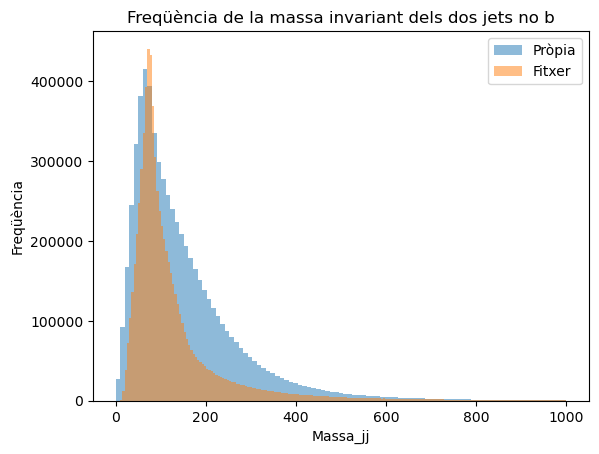

In [26]:
bins1 = np.linspace(0, 1000, 100)
bins2 = np.linspace(0, 1000, 200)

plt.hist(m_jj, bins1, alpha=0.5, label='Pròpia')
plt.hist(nonorm.loc[:,"m_jj"], bins2, alpha=0.5, label='Fitxer')
plt.legend(loc='upper right')
plt.xlabel('Massa_jj')
plt.ylabel('Freqüència')
plt.title('Freqüència de la massa invariant dels dos jets no b')
plt.savefig("D:/OneDrive/Universitat/5. Quint/TFG/RstudioPython/Figures/MassaInvariant.png")
plt.show()

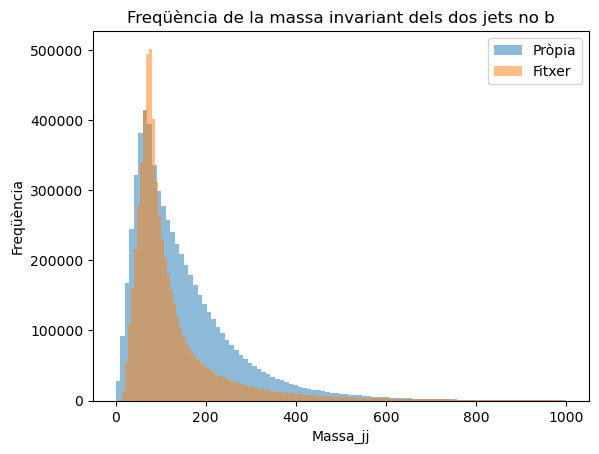

In [29]:
bins1 = np.linspace(0, 1000, 100)
bins2 = np.linspace(0, 1000, 150)

plt.hist(m_jj, bins1, alpha=0.5, label='Pròpia')
plt.hist(someTr[someTr["btotal"] == 2].loc[:,"m_jj"], bins2, alpha=0.5, label='Fitxer')
plt.legend(loc='upper right')
plt.xlabel('Massa_jj')
plt.ylabel('Freqüència')
plt.title('Freqüència de la massa invariant dels dos jets no b')
plt.savefig("D:/OneDrive/Universitat/5. Quint/TFG/RstudioPython/Figures/mjjseleccio.png")
plt.show()

### Prova de nou únicament amb els events amb 4 jets

Provem a seleccionar únicament els events amb 4 jets. Cal que seleccionem els events i tb renomenem els eta com theta. Carreguem les dades primerament:

In [3]:
nonorm = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\nonorm1000.csv")
# print(nonorm)

Ara seleccionem els esdeveniments amb 2btag i solament 4 jets i repetim la selecció de dades i el càlcul de theta (no eta).

In [103]:
someTr = nonorm[nonorm["btotal"] == 2]
someTr = someTr[someTr["njets"] == 4]
n_esdev = len(someTr)

vectors = pd.DataFrame(np.zeros([n_esdev,6]))
vectors.columns = ["p1","eta1","phi1","p2","eta2","phi2"]

for i in range(n_esdev):
    if someTr.iloc[i,10]:
        if someTr.iloc[i,14]:
            vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[15,16,17,19,20,21]]
        elif someTr.iloc[i,18]:
            vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[11,12,13,19,20,21]]
        elif someTr.iloc[i,22]:
            vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[11,12,13,15,16,17]]
    elif someTr.iloc[i,14]:
        if someTr.iloc[i,18]:
            vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[7,8,9,19,20,21]]
        if someTr.iloc[i,22]:
            vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[7,8,9,15,16,17]]
    else:
        vectors.iloc[i,[0,1,2,3,4,5]] =  someTr.iloc[i,[7,8,9,11,12,13]]
vectors.loc[:,["eta1","eta2"]] = 2*(((-1*vectors.loc[:,["eta1","eta2"]]).apply(np.exp)).apply(np.arctan)) # Transforma eta en theta
vectors.columns = ["p1","theta1","phi1","p2","theta2","phi2"]
vectors.to_csv("jets4nob.csv", sep=',', index=False)

#  segons -->  minuts i  segons 

In [8]:
vectors = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\jets4nob.csv")
print(vectors)


               p1    theta1      phi1        p2    theta2     phi2
0        146.0610  1.650466  0.655341   22.6698  1.782233  2.90245
1         87.9534  2.150995 -1.450480   43.3677  2.526081  1.26638
2        247.6320  0.151866 -0.090815   27.8114  2.230994 -1.86307
3         81.1532  1.226633 -1.056190   30.1326  2.468603  2.75392
4         26.5728  1.709639  3.081610   23.8286  2.831420 -2.14982
...           ...       ...       ...       ...       ...      ...
2206918  210.7280  0.465240  2.658820   21.6742  0.969785 -1.97697
2206919  299.8570  2.316131 -1.295000  153.9110  2.478840  2.95115
2206920  112.7170  2.518459 -1.242190   42.1538  2.304945  1.52918
2206921   37.2781  2.787560  2.989910   35.6245  0.263479 -1.87100
2206922  244.3510  2.676586  2.371790   98.8464  0.546129  1.18589

[2206923 rows x 6 columns]


Calculem m_jj. Em sembla que és amb aquesta fòrmula, però potser toca canviar phi i theta. Igualment, no canvia massa)

In [5]:
m_jj = pd.DataFrame(np.zeros([len(vectors),0]))
m_jj = 1 - ( vectors.loc[:,"phi1"].apply(np.sin) * vectors.loc[:,"phi2"].apply(np.sin) * (vectors.loc[:,"theta1"] - vectors.loc[:,"theta2"]).apply(np.cos) )
m_jj = m_jj - ( vectors.loc[:,"phi1"].apply(np.cos) * vectors.loc[:,"phi2"].apply(np.cos) )
m_jj = np.sqrt( 2 * vectors.loc[:,"p1"] * vectors.loc[:,"p2"] * m_jj )

Representem les dues distribucions

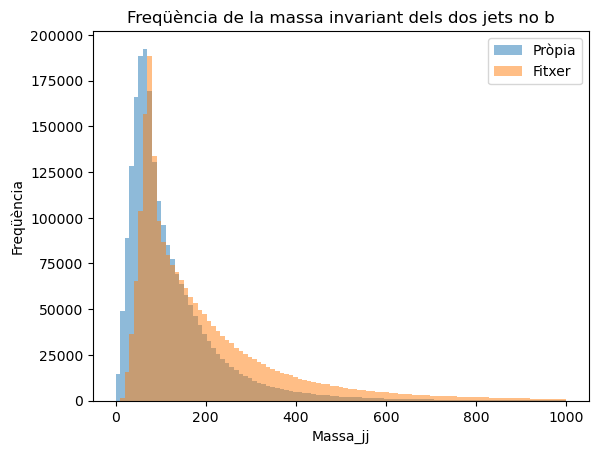

In [102]:
bins1 = np.linspace(0, 1000, 100)
bins2 = np.linspace(0, 1000, 100)

# nonorm = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\nonorm1000.csv")
someTr = nonorm[nonorm["btotal"] == 2]
someTr = someTr[someTr["njets"] == 4]

plt.hist(m_jj, bins1, alpha=0.5, label='Pròpia')
plt.hist(someTr[someTr["btotal"] == 2].loc[:,"m_jj"], bins2, alpha=0.5, label='Fitxer')
plt.legend(loc='upper right')
plt.xlabel('Massa_jj')
plt.ylabel('Freqüència')
plt.title('Freqüència de la massa invariant dels dos jets no b')
plt.savefig("D:/OneDrive/Universitat/5. Quint/TFG/RstudioPython/Figures/prova.png")
plt.show()

Representem ara la diferència de masses

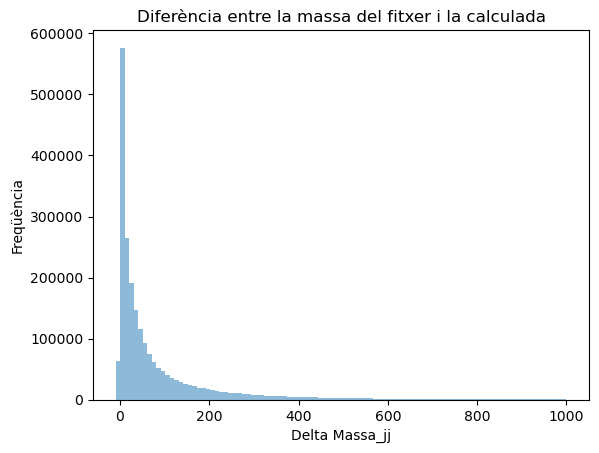

In [70]:
bins = np.linspace(-10, 1000, 101)
alguns = someTr.loc[:,"m_jj"]
alguns = alguns.reset_index(drop=True)
deltamjj = alguns - m_jj

plt.hist(deltamjj, bins, alpha=0.5, label='Fitxer')
plt.xlabel('Delta Massa_jj')
plt.ylabel('Freqüència')
plt.title('Diferència entre la massa del fitxer i la calculada')
plt.savefig("D:/OneDrive/Universitat/5. Quint/TFG/RstudioPython/Figures/deltamjj.png")
plt.show()

In [ ]:
# Provem a calcular un sol m_jj, el d'índex 2
num = 2
p1 = someTr.iloc[num,7]
theta1 = someTr.iloc[num,8]
phi1 = someTr.iloc[num,9]
p2 = someTr.iloc[num,11]
theta2 = someTr.iloc[num,12]
phi2 = someTr.iloc[num,13]

x = p1*np.sin(phi1)*np.cos(theta1) * p2*np.sin(phi2)*np.cos(theta2)
y = p1*np.sin(phi1)*np.sin(theta1) * p2*np.sin(phi2)*np.sin(theta2)
z = p1*np.cos(phi1) * p2*np.cos(phi2)
pp = x + y + z
m = np.sqrt(2*(p1*p2-pp))


print(m_jj[num],alguns[num])

In [ ]:
print(someTr)

#### Anem a fer el càlcul de m_jj suposant que agafem únicament jets 1 i 2 --> Cap sentit

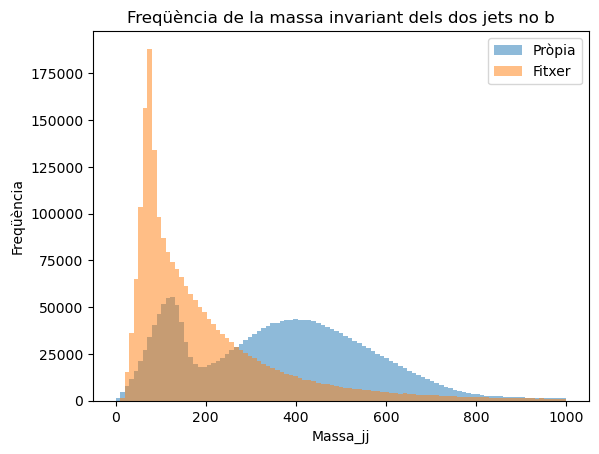

In [83]:
# # Del total d'events no normalitzats, agafem únicament aquells amb btotal 2 i 4 jets
# someTr = nonorm[nonorm["btotal"] == 2]
# someTr = someTr[someTr["njets"] == 4]
# n_esdev = len(someTr)

# # Inicialitzem prova amb zeros i carreguem les dades dels jets 1 i 2 directament
# jets = pd.DataFrame(np.zeros([n_esdev,6]))
# jets.iloc[:,[0,1,2,3,4,5]] = someTr.iloc[:,[7,8,9,11,12,13]]
# jets.columns = ["p1","eta1","phi1","p2","eta2","phi2"]


# # Transformem eta en theta i renomenem
# jets.loc[:,["eta1","eta2"]] = 2*(((-1*jets.loc[:,["eta1","eta2"]]).apply(np.exp)).apply(np.arctan)) 
# jets.columns = ["p1","theta1","phi1","p2","theta2","phi2"]

# # Recalculem la massa invariant
# m_jj = pd.DataFrame(np.zeros([len(jets),0]))
# m_jj = 1 - ( jets.loc[:,"phi1"].apply(np.sin) * jets.loc[:,"phi2"].apply(np.sin) * (jets.loc[:,"theta1"] - jets.loc[:,"theta2"]).apply(np.cos) )
# m_jj = m_jj - ( jets.loc[:,"phi1"].apply(np.cos) * jets.loc[:,"phi2"].apply(np.cos) )
# m_jj = np.sqrt( 2 * jets.loc[:,"p1"] * jets.loc[:,"p2"] * m_jj )

# # Plotem les dues
# bins1 = np.linspace(0, 1000, 100)
# bins2 = np.linspace(0, 1000, 100)
# plt.hist(m_jj, bins1, alpha=0.5, label='Pròpia')
# plt.hist(someTr.loc[:,"m_jj"], bins2, alpha=0.5, label='Fitxer')
# plt.legend(loc='upper right')
# plt.xlabel('Massa_jj')
# plt.ylabel('Freqüència')
# plt.title('Freqüència de la massa invariant dels dos jets no b')
# plt.savefig("D:/OneDrive/Universitat/5. Quint/TFG/RstudioPython/Figures/prova.png")
# plt.show()


## *2. Test trocejat --> mesuradors amb error*

Repetim càrrega de llibreries i dades

In [34]:
# Data Processing
import pandas as pd
import time
import numpy as np
import math
import matplotlib.pyplot as plt

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

miltr = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\1000_train.csv")
miltst = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\1000_test.csv")
alltr = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\all_train.csv")
alltst = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\all_test.csv")

# del(alltr,alltst)
# del(miltr, miltst)

# Per poder emetre un so quan acaba d'executar una cel·la
from IPython.display import Audio
sound_file = "C:/Users/alexp/Downloads/beep.wav"
Audio(sound_file, autoplay=True)

Repetim el càlcul dels diferents mesuradors trocejant els tests. Primerament amb els DT.

!! Cal trencar en diferents tsts i calcular els diferents acc,kappa,F1S.

In [74]:
# batch = 500_000
# ntsts = int(len(Xtst)/batch)
# Xtsts = pd.DataFrame(np.zeros([batch,Xtst.shape[1],ntsts]))
# Ytsts = pd.DataFrame(np.zeros([batch,ntsts]))
# for i in range(ntsts):
#     Xtsts[i] = Xtst[batch*(i):batch*(i+1),:]
#     Ytsts[i] = Ytst[batch*(i):batch*(i+1)]

batch = 500_000
ntsts = int(len(Xtst)/batch)
acc,kappa,F1S = np.zeros(ntsts),np.zeros(ntsts),np.zeros(ntsts)

for i in range(ntsts):
    Xtst1, Ytst1 = Xtst[batch*i:batch*(i+1),:], Ytst[batch*i:batch*(i+1)]
    Ypred = clf.predict(Xtst1)
    acc[i] = clf.score(Xtst1, Ytst1)
    kappa[i] = metrics.cohen_kappa_score(Ypred,Ytst1)
    F1S[i] = metrics.f1_score(Ytst1,Ypred)

# print("Precisió: %.4f ± %.4f. Kappa: %.4f ± %.4f. F1-Score: %.4f ± %.4f." % (np.mean(acc),np.std(acc),np.mean(kappa),np.std(kappa),np.mean(F1S),np.std(F1S)))

print("| %s | %i |  %.4f ± %.4f |  %.4f ± %.4f |  %.4f ± %.4f | %i |" 
      % (label,max_depth,np.mean(acc),np.std(acc),np.mean(kappa),np.std(kappa),np.mean(F1S),np.std(F1S),temps))


In [84]:
# print("DT amb profunditat %i.\nPrecisió = %f; kappa = %f; F1-Score = %f.\nTemps d'execució = %i segons" 
#        % (clf.get_depth(),acc,kappa,F1S,temps)) # Format agradable

# print("Precisió: %.4f ± %.4f. Kappa: %.4f ± %.4f. F1-Score: %.4f ± %.4f." % (np.mean(acc),np.std(acc),np.mean(kappa),np.std(kappa),np.mean(F1S),np.std(F1S)))



| d | 7 |  0.9077 ± 0.0004 |  0.8154 ± 0.0009 |  0.9099 ± 0.0004 | 54 |


Introduïm aquest nou mètode i recalculem:

In [88]:
# Part 1: definim Ydata, Ytst per a tots i Xdata, Xtst per a cada cas 
startTime = time.time()

Ydata = np.array(miltr.index)
Ytst = np.array(miltst.iloc[:,0])

# Ydata = alltr.iloc[:,0]
# Ytst = alltst.iloc[:,0]

# d) Selecció 2
Xdata = np.array(miltr.iloc[:,[0,3,6,26]])
Xtst = np.array(miltst.iloc[:,[1,4,7,27]])
label = "d"

# j) Alltr: 0 25 26 27
# Xdata = np.array(alltr.loc[:,["f0","f25","f26","mass"]])
# Xtst = np.array(alltst.loc[:,["f0","f25","f26","mass"]])
# label = "j"

# j2) Alltr: 0 25 26 27
# Xdata = alltr.loc[:,["f0","f25","f26","mass"]]
# Xtst = alltst.loc[:,["f0","f25","f26","mass"]]
# label = "j2"


# Part 2: Càlcul DT
max_depth = 7

clf = tree.DecisionTreeClassifier(max_depth = max_depth)
clf = clf.fit(Xdata, Ydata)


# Part 3: Avaluació DT
# 3A: Partició del Xtst,Ytsts en diferents

batch = 5_000
ntsts = int(len(Xtst)/batch)
acc,kappa,F1S = np.zeros(ntsts),np.zeros(ntsts),np.zeros(ntsts)

for i in range(ntsts):
    Xtst1, Ytst1 = Xtst[batch*i:batch*(i+1),:], Ytst[batch*i:batch*(i+1)]
    Ypred = clf.predict(Xtst1)
    acc[i] = clf.score(Xtst1, Ytst1)
    kappa[i] = metrics.cohen_kappa_score(Ypred,Ytst1)
    F1S[i] = metrics.f1_score(Ytst1,Ypred)


temps = time.time() - startTime




# print("DT amb profunditat %i.\nPrecisió = %f; kappa = %f; F1-Score = %f.\nTemps d'execució = %i segons" 
#       % (clf.get_depth(),acc,kappa,F1S,temps)) # Format agradable

# print("Precisió: %.4f ± %.4f. Kappa: %.4f ± %.4f. F1-Score: %.4f ± %.4f." % (np.mean(acc),np.std(acc),np.mean(kappa),np.std(kappa),np.mean(F1S),np.std(F1S)))

print("| %s | %i |  %.4f ± %.4f |  %.4f ± %.4f |  %.4f ± %.4f | %i | %i |" 
      % (label,max_depth,np.mean(acc),np.std(acc),np.mean(kappa),np.std(kappa),np.mean(F1S),np.std(F1S),ntsts,temps))


Audio(sound_file, autoplay=True)

| d | 7 |  0.9077 ± 0.0042 |  0.8154 ± 0.0085 |  0.9099 ± 0.0043 | 700 | 61 |


| labels | Max_depth |  Acc  | Kappa | F1-S | ntsts | Temps (s) |
|:------:|:---------:|:-----:|:-----:|:----:|:----:|-------|
| *Proves amb miltr* |
| d | 7 |  0.9077 ± 0.0004 |  0.8154 ± 0.0009 |  0.9099 ± 0.0004 | 7 | 61 |
| d | 7 |  0.9077 ± 0.0014 |  0.8154 ± 0.0029 |  0.9099 ± 0.0015 | 70 | 58 |
| d | 7 |  0.9077 ± 0.0042 |  0.8154 ± 0.0085 |  0.9099 ± 0.0043 | 700 | 61 |


La mitjana és la mateixa (lògicament, perquè el nombre total de falsos/vertaders positius/negatius és el mateix) i únicament augmenta a mesura que partim en més ntsts. Sembla que no dóna cap resultat útil o raonable, caldria emprar altre mètode per calcular l'error. 
Possiblement podríem calcular els mesuradors amb diferents hiperparàmetres i després prendre la desviació? Però de nou sembla arbitrari escollir quins hiperparàmetres escollim i quins no per a la distribució. Es pot, diguem, "manufacturar" l'error que es vulga.

## *3. Estudi mesuradors segons paràmetre i massa*

Plots a fer:
1. Acc-kap-F1S de DT amb diferents profunditats (comprovar tendència assimptòtica)
2. Temps d'execució de DT amb diferents profunditats (ídem a 1.)
3. Acc-kappa-F1S amb diferents profunditats i diferents n_estimators
4. Comparació entre DT vs. RF vs. ADB amb una profunditat determinada

### Entrenament i avaluació amb masses determinades (ídem al paper) per al cas de DT

#### Recarreguem les dades i separem alltr i alltst en les diferents masses

In [7]:
# Data Processing
import pandas as pd
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import time

# Data Filing
import pickle
import os

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

miltr = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\1000_train.csv")
miltst = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\1000_test.csv")
alltr = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\all_train.csv")
alltst = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\all_test.csv")


# Per poder emetre un so quan acaba d'executar una cel·la
from IPython.display import Audio
sound_file = "C:/Users/alexp/Downloads/beep.wav"
Audio(sound_file, autoplay=True)

# Renomenació de columnes
alltr.columns = ["Signal","l_pt","l_eta","l_phi","MET","M_phi","njets","pt1","eta1","phi1","b1","pt2","eta2","phi2","b2",
                 "pt3","eta3","phi3","b3","pt4","eta4","phi4","b4","m_jj","m_jjj","m_lv","m_jlv","m_wwbb","mass"]
alltst.columns = ["Signal","l_pt","l_eta","l_phi","MET","M_phi","njets","pt1","eta1","phi1","b1","pt2","eta2","phi2","b2",
                 "pt3","eta3","phi3","b3","pt4","eta4","phi4","b4","m_jj","m_jjj","m_lv","m_jlv","m_wwbb","mass"]

# Separació en masses
tra = alltr[alltr["mass"] <= 500]
trb = alltr[alltr["mass"] == 750]
trc = alltr[alltr["mass"] == 1000]
trd = alltr[alltr["mass"] == 1250]
tre = alltr[alltr["mass"] == 1500]

tsta = alltst[alltst["mass"] <= 500]
tstb = alltst[alltst["mass"] == 750]
tstc = alltst[alltst["mass"] == 1000]
tstd = alltst[alltst["mass"] == 1250]
tste = alltst[alltst["mass"] == 1500]
Audio(sound_file, autoplay=True)

#### Càlcul del DT

In [126]:
# Part 1: definim Ydata, Ytst per a tots i Xdata, Xtst per a cada cas 
from sklearn import tree
import matplotlib.pyplot as plt
import time
startTime = time.time()

# VARIABLES PROBLEMA
max_depth = 3

# 1) 500: 0 25 26 27
# Ydata = np.array(tra.iloc[:,0])
# Xdata = tra.loc[:,["f0","f25","f26"]]
# Ytst = np.array(tsta.iloc[:,0])
# Xtst = tsta.loc[:,["f0","f25","f26"]]
# massa = 500
# label = "1"

# 2) 500: all variables
Ydata = np.array(tra.iloc[:,0])
Xdata = tra.iloc[:,1:27]
Ytst = np.array(tsta.iloc[:,0])
Xtst = tsta.iloc[:,1:27]
massa = 500
label = "2"

# 3) 500: HL variables
# Ydata = np.array(tra.iloc[:,0])
# Xdata = tra.iloc[:,22:27]
# Ytst = np.array(tsta.iloc[:,0])
# Xtst = tsta.iloc[:,22:27]
# massa = 500
# label = "3"

# 4) f25, f6, f0
# Ydata = np.array(tra.iloc[:,0])
# Xdata = tra.loc[:,["f0","f6","f25"]]
# Ytst = np.array(tsta.iloc[:,0])
# Xtst = tsta.loc[:,["f0","f6","f25"]]
# massa = 500
# label = "4"


# Part 2: Càlcul DT
# from sklearn import tree
# from sklearn import metrics
# import matplotlib.pyplot as plt

clf = tree.DecisionTreeClassifier(max_depth = max_depth)
clf = clf.fit(Xdata, Ydata)


# Part 3: Avaluació DT
Ypred = clf.predict(Xtst)
acc = clf.score(Xtst, Ytst)
kappa = metrics.cohen_kappa_score(Ypred,Ytst)
F1S = metrics.f1_score(Ytst,Ypred)

temps = time.time() - startTime

# print("DT amb profunditat %i.\nPrecisió = %f; kappa = %f; F1-Score = %f.\nTemps d'execució = %i segons" 
#       % (clf.get_depth(),acc,kappa,F1S,temps)) # Format agradable

print("| %s | %i | %f | %f | %f | %i | %i |" % (label,max_depth,acc,kappa,F1S,temps,massa)) # Format per copiar i pegar a la taula
# print(clf.get_n_leaves())
Audio(sound_file, autoplay=True)

| 2 | 3 | 0.614701 | 0.229335 | 0.647160 | 30 | 500 |


#### Representem el DT

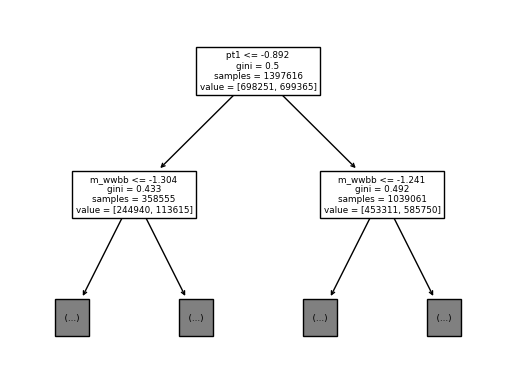

In [11]:
tree.plot_tree(clf,max_depth = 1, feature_names = list(Xdata.columns))
plt.show()

#### Repetim tot per a múltiples profunditats

In [4]:
# Part 1: definim Ydata, Ytst per a tots i Xdata, Xtst per a cada cas 
from sklearn import tree
import matplotlib.pyplot as plt
import time

for i in range(2,11):
    startTime = time.time()
    max_depth = i

    # 2) all variables
    Ydata = np.array(tra.iloc[:,0])
    Xdata = tra.iloc[:,1:27]
    Ytst = np.array(tsta.iloc[:,0])
    Xtst = tsta.iloc[:,1:27]
    massa = 500
    label = "2"

    # 3) 500: HL variables
    # Ydata = np.array(tra.iloc[:,0])
    # Xdata = tra.iloc[:,22:27]
    # Ytst = np.array(tsta.iloc[:,0])
    # Xtst = tsta.iloc[:,22:27]
    # massa = 500
    # label = "3"

    # 4) f25, f6, f0
    # Ydata = np.array(tra.iloc[:,0])
    # Xdata = tra.loc[:,["f0","f6","f25"]]
    # Ytst = np.array(tsta.iloc[:,0])
    # Xtst = tsta.loc[:,["f0","f6","f25"]]
    # massa = 500
    # label = "4"
    


    # Part 2: Càlcul DT
    # from sklearn import tree
    # from sklearn import metrics
    # import matplotlib.pyplot as plt

    clf = tree.DecisionTreeClassifier(max_depth = max_depth, max_features=5)
    clf = clf.fit(Xdata, Ydata)


    # Part 3: Avaluació DT
    Ypred = clf.predict(Xtst)
    acc = clf.score(Xtst, Ytst)
    kappa = metrics.cohen_kappa_score(Ypred,Ytst)
    F1S = metrics.f1_score(Ytst,Ypred)

    temps = time.time() - startTime

    # print("DT amb profunditat %i.\nPrecisió = %f; kappa = %f; F1-Score = %f.\nTemps d'execució = %i segons" 
    #       % (clf.get_depth(),acc,kappa,F1S,temps)) # Format agradable

    print("| %s | %i | %f | %f | %f | %i | %i |" % (label,max_depth,acc,kappa,F1S,temps,massa)) # Format per copiar i pegar a la taula
# print(clf.get_n_leaves())
Audio(sound_file, autoplay=True)

| 2 | 2 | 0.564966 | 0.130011 | 0.519793 | 4 | 500 |
| 2 | 3 | 0.597029 | 0.193884 | 0.670633 | 5 | 500 |
| 2 | 4 | 0.602340 | 0.204517 | 0.671730 | 7 | 500 |
| 2 | 5 | 0.591821 | 0.183491 | 0.657558 | 9 | 500 |


KeyboardInterrupt: 

#### Taula amb diferents masses i diferent profunditat

| labels | Max_depth |  Acc  | Kappa | F1-S | Temps (s) | Massa (GeV) |
|:------:|:---------:|:-----:|:-----:|:----:|-------|-------|
| *Proves|amb alltr,| entrenant per|a masses|específiques* |
| 2 | 3 | 0.614701 | 0.229335 | 0.647160 | 24 | 500 |
| 2 | 4 | 0.624860 | 0.249596 | 0.679699 | 32 | 500 |
| 2 | 2 | 0.594984 | 0.189740 | 0.686555 | 20 | 500 |
| 2 | 3 | 0.614701 | 0.229335 | 0.647160 | 30 | 500 |
| 2 | 4 | 0.624860 | 0.249596 | 0.679699 | 41 | 500 |
| 2 | 5 | 0.625770 | 0.251434 | 0.673783 | 52 | 500 |
| 2 | 6 | 0.632072 | 0.264029 | 0.683674 | 64 | 500 |
| 2 | 7 | 0.635301 | 0.270493 | 0.684567 | 73 | 500 |
| 2 | 8 | 0.636842 | 0.273573 | 0.686278 | 67 | 500 |
| 2 | 9 | 0.638622 | 0.277142 | 0.684756 | 74 | 500 |
| 2' | 2 | 0.792365 | 0.584762 | 0.801259 | 20 | 750 |
| 2' | 3 | 0.802461 | 0.604971 | 0.816344 | 24 | 750 |
| 2' | 4 | 0.821279 | 0.642574 | 0.825787 | 32 | 750 |
| 2' | 5 | 0.824837 | 0.649699 | 0.832349 | 41 | 750 |
| 2' | 6 | 0.830389 | 0.660789 | 0.833435 | 49 | 750 |
| 2' | 7 | 0.832699 | 0.665422 | 0.839393 | 58 | 750 |
| 2' | 8 | 0.833961 | 0.667939 | 0.838948 | 66 | 750 |
| 2' | 9 | 0.834732 | 0.669480 | 0.839533 | 74 | 750 |
| 2' | 10 | 0.835327 | 0.670669 | 0.839606 | 82 | 750 |
| 2'' | 2 | 0.880735 | 0.761467 | 0.880259 | 17 | 1000 |
| 2'' | 3 | 0.887779 | 0.775572 | 0.889582 | 29 | 1000 |
| 2'' | 4 | 0.893210 | 0.786416 | 0.892629 | 38 | 1000 |
| 2'' | 5 | 0.898848 | 0.797699 | 0.899134 | 48 | 1000 |
| 2'' | 6 | 0.901337 | 0.802677 | 0.901811 | 54 | 1000 |
| 2'' | 7 | 0.902715 | 0.805432 | 0.902896 | 61 | 1000 |
| 2'' | 8 | 0.904155 | 0.808316 | 0.904822 | 70 | 1000 |
| 2'' | 9 | 0.905005 | 0.810012 | 0.905260 | 81 | 1000 |
| 2'' | 10 | 0.905419 | 0.810842 | 0.905814 | 90 | 1000 |
| 2 | 2 | 0.913522 | 0.827044 | 0.913232 | 19 | 1250 |
| 2 | 3 | 0.917734 | 0.835467 | 0.918494 | 26 | 1250 |
| 2 | 4 | 0.921295 | 0.842591 | 0.920356 | 34 | 1250 |
| 2 | 5 | 0.924491 | 0.848982 | 0.923848 | 42 | 1250 |
| 2 | 6 | 0.927591 | 0.855183 | 0.926902 | 52 | 1250 |
| 2 | 7 | 0.929076 | 0.858152 | 0.929567 | 60 | 1250 |
| 2 | 8 | 0.929847 | 0.859694 | 0.929707 | 68 | 1250 |
| 2 | 9 | 0.930276 | 0.860553 | 0.930288 | 76 | 1250 |
| 2 | 10 | 0.930803 | 0.861606 | 0.930782 | 85 | 1250 |
| 2 | 2 | 0.928125 | 0.856250 | 0.927578 | 20 | 1500 |
| 2 | 3 | 0.928694 | 0.857388 | 0.929850 | 25 | 1500 |
| 2 | 4 | 0.933575 | 0.867150 | 0.933909 | 34 | 1500 |
| 2 | 5 | 0.936770 | 0.873540 | 0.935719 | 43 | 1500 |
| 2 | 6 | 0.938876 | 0.877752 | 0.938314 | 52 | 1500 |
| 2 | 7 | 0.940607 | 0.881215 | 0.940562 | 61 | 1500 |
| 2 | 8 | 0.941589 | 0.883177 | 0.941138 | 69 | 1500 |
| 2 | 9 | 0.943047 | 0.886094 | 0.942758 | 78 | 1500 |
| 2 | 10 | 0.944884 | 0.889768 | 0.944837 | 87 | 1500 |
| 3 | 4 | 0.553702 | 0.107400 | 0.555499 | 5 | 500 |
| 4 | 3 | 0.613876 | 0.227680 | 0.647547 | 5 | 500 |
| 4 | 10 | 0.621477 | 0.242871 | 0.659785 | 17 | 500 |



#### Provem a automatitzar i ordenar l'output

In [270]:
# Part 1: definim Ydata, Ytst per a tots i Xdata, Xtst per a cada cas 
from sklearn import tree
import matplotlib.pyplot as plt
import time

directory = "D:/OneDrive/Universitat/5. Quint/TFG/RstudioPython/Arxius"
rango = range(2,11) # Que comence en 2
mesuradors = [np.zeros(rango[-2]),np.zeros(rango[-2]),np.zeros(rango[-2])]
temps = np.zeros(rango[-2])
nleafs = np.zeros(rango[-2])

for i in rango:
    startTime = time.time()
    max_depth = i

    # 2) all variables
    Ydata = np.array(tra.iloc[:,0])
    Xdata = tra.iloc[:,1:27]
    Ytst = np.array(tsta.iloc[:,0])
    Xtst = tsta.iloc[:,1:27]
    massa = 500
    label = "totes"

    # 3) 500: HL variables
    # Ydata = np.array(tra.iloc[:,0])
    # Xdata = tra.iloc[:,22:27]
    # Ytst = np.array(tsta.iloc[:,0])
    # Xtst = tsta.iloc[:,22:27]
    # massa = 500
    # label = "3"
    
    # 4) pts, mjj, mjjj, mwwbb
    # Ydata = np.array(tra.iloc[:,0])
    # Xdata = tra.loc[:,["l_pt","MET","pt1","pt2","pt3","pt4","m_jj","m_jjj","m_wwbb"]]
    # Ytst = np.array(tsta.iloc[:,0])
    # Xtst = tsta.loc[:,["l_pt","MET","pt1","pt2","pt3","pt4","m_jj","m_jjj","m_wwbb"]]
    # massa = 500
    # label = "4"
    
    # 5) pt1, pt2, pt3, MET, lpt, mjjj, mwwbb
    # Ydata = np.array(tra.iloc[:,0])
    # Xdata = tra.loc[:,["l_pt","MET","pt1","pt2","pt3","pt4","m_jj","m_jjj","m_wwbb"]]
    # Ytst = np.array(tsta.iloc[:,0])
    # Xtst = tsta.loc[:,["l_pt","MET","pt1","pt2","pt3","pt4","m_jj","m_jjj","m_wwbb"]]
    # massa = 500
    # label = "5"
    
    # 6) pt1, pt2, lpt, mjjj, mwwbb
    # Ydata = np.array(tra.iloc[:,0])
    # Xdata = tra.loc[:,["l_pt","pt1","pt2","pt4","m_jj","m_jjj","m_wwbb"]]
    # Ytst = np.array(tsta.iloc[:,0])
    # Xtst = tsta.loc[:,["l_pt","pt1","pt2","pt4","m_jj","m_jjj","m_wwbb"]]
    # massa = 500
    # label = "6"
    
    # 7) pt1, pt2, mjjj, mwwbb
    # Ydata = np.array(tra.iloc[:,0])
    # Xdata = tra.loc[:,["pt1","pt2","pt4","m_jj","m_jjj","m_wwbb"]]
    # Ytst = np.array(tsta.iloc[:,0])
    # Xtst = tsta.loc[:,["pt1","pt2","pt4","m_jj","m_jjj","m_wwbb"]]
    # massa = 500
    # label = "7"


    # Part 2: Càlcul DT
    # from sklearn import tree
    # from sklearn import metrics
    # import matplotlib.pyplot as plt

    clf = tree.DecisionTreeClassifier(max_depth = max_depth)
    clf = clf.fit(Xdata, Ydata)


    # Part 3: Avaluació DT
    Ypred = clf.predict(Xtst)
    mesuradors[0][i-2] = clf.score(Xtst, Ytst)
    mesuradors[1][i-2] = metrics.cohen_kappa_score(Ypred,Ytst)
    mesuradors[2][i-2] = metrics.f1_score(Ytst,Ypred)
    nleafs[i-2] = clf.get_n_leaves()

    temps[i-2] = time.time() - startTime

    # print("DT amb profunditat %i.\nPrecisió = %f; kappa = %f; F1-Score = %f.\nTemps d'execució = %i segons" 
    #       % (clf.get_depth(),acc,kappa,F1S,temps)) # Format agradable
    print("| %s | %i | %f | %f | %f | %i | %i | %i |" % (label,max_depth,mesuradors[0][i-2],mesuradors[1][i-2],
                                                    mesuradors[2][i-2],nleafs[i-2],temps[i-2],massa))
    # Format per copiar i pegar a la taula
    # print(clf.get_n_leaves())

diccionari = {
    "label": label,
    "max_depth": max_depth,
    "acc": mesuradors[0],
    "kappa": mesuradors[1],
    "F1S": mesuradors[2],
    "nleafs": nleafs,
    "temps": temps,
    "massa": massa
}


filename = str(massa) + "_" + label
with open(os.path.join(directory, filename + ".txt"), 'wb') as fp:
    pickle.dump(diccionari, fp)

Audio(sound_file, autoplay=True)

| totes | 2 | 0.594984 | 0.189740 | 0.686555 | 4 | 17 | 500 |
| totes | 3 | 0.614701 | 0.229335 | 0.647160 | 8 | 25 | 500 |
| totes | 4 | 0.624860 | 0.249596 | 0.679699 | 16 | 33 | 500 |
| totes | 5 | 0.625770 | 0.251434 | 0.673783 | 32 | 41 | 500 |
| totes | 6 | 0.632072 | 0.264029 | 0.683674 | 64 | 50 | 500 |
| totes | 7 | 0.635301 | 0.270493 | 0.684567 | 128 | 61 | 500 |
| totes | 8 | 0.636846 | 0.273581 | 0.686282 | 253 | 68 | 500 |
| totes | 9 | 0.638625 | 0.277147 | 0.684758 | 497 | 76 | 500 |
| totes | 10 | 0.640352 | 0.280615 | 0.681499 | 962 | 83 | 500 |


La part de baix llig el diccionari guardat amb l'últim filename i el representa

In [19]:
# Quin arxiu vols comprovar? Escollim massa i índex:
massa = "1500"
label = "totes"
directory = "D:/OneDrive/Universitat/5. Quint/TFG/RstudioPython/Arxius"
filename = massa + "_" + label
with open(os.path.join(directory, filename + ".txt"), 'rb') as fp:
    resultats = pickle.load(fp)

temp = pd.DataFrame([resultats["acc"], resultats["kappa"], resultats["F1S"]]).T
temp.columns = ["Precisió","Kappa","F1S"]
temp.style.background_gradient()

,Precisió,Kappa,F1S
0,0.928125,0.856250,0.927578
1,0.928694,0.857388,0.929850
2,0.933575,0.867150,0.933909
3,0.936770,0.873540,0.935719
4,0.938876,0.877752,0.938314
5,0.940609,0.881217,0.940564
6,0.941584,0.883168,0.941133
7,0.943043,0.886085,0.942754
8,0.944881,0.889762,0.944834
9,0.000000,0.000000,0.000000


FALTA EXPORTAR ELS ESTIMADORS COM A IMATGE PQ SIGA + FÀCILMENT INTERPRETABLE

#### Dibuixem i guardem el tree

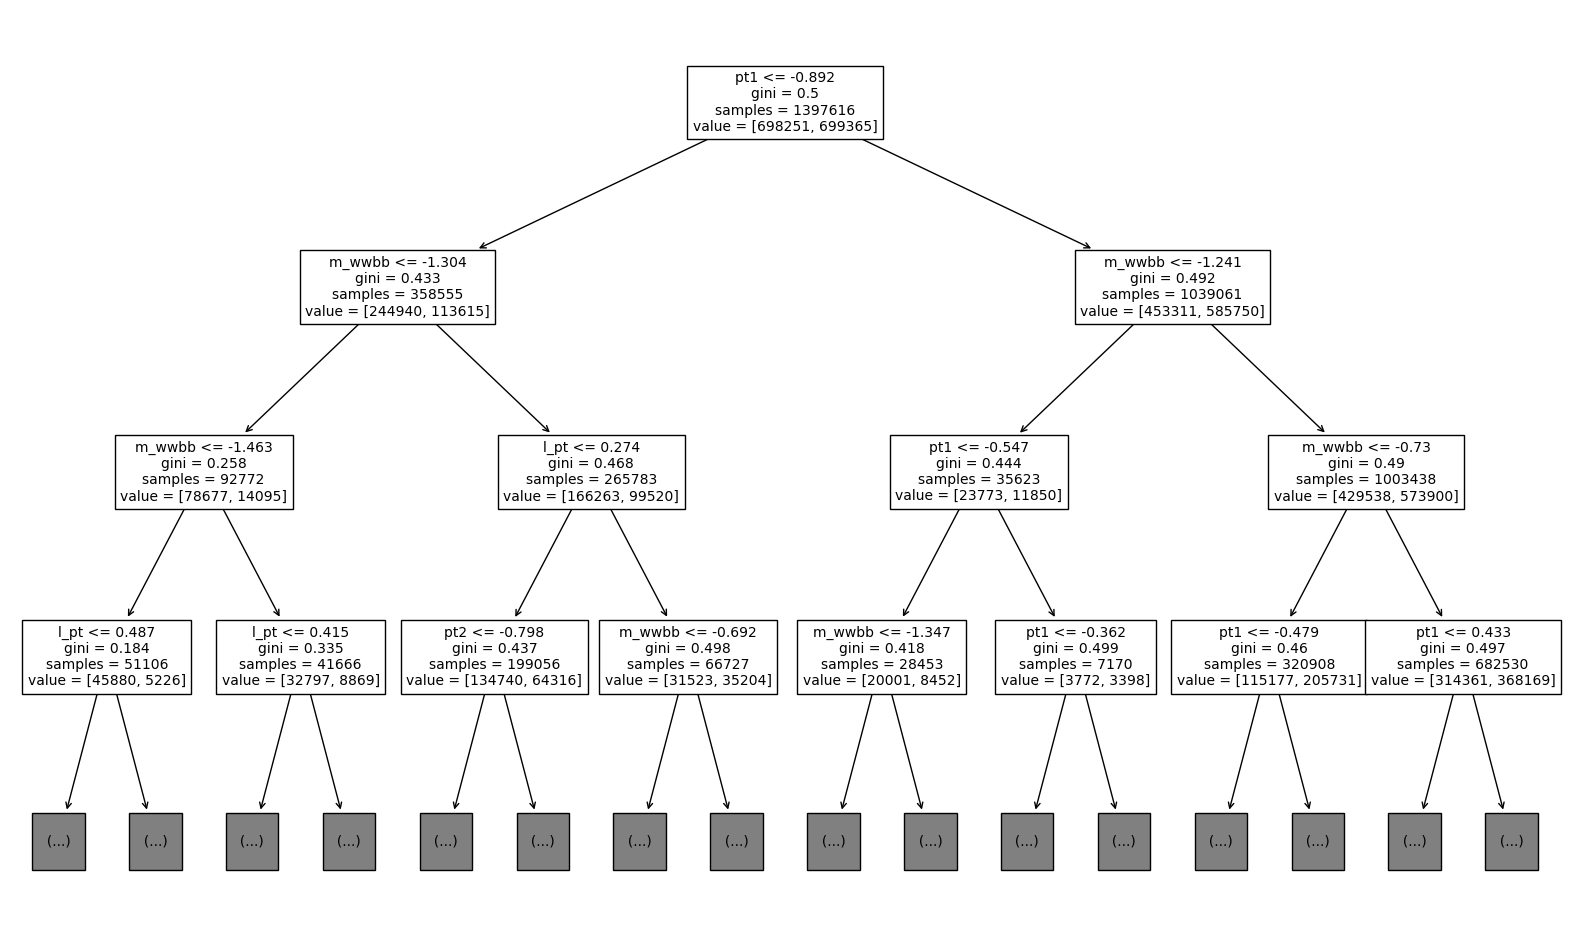

In [229]:
plt.figure(figsize=(20,12))
tree.plot_tree(clf,max_depth = 3, fontsize = 10, feature_names = Xdata.columns);
directory = "D:/OneDrive/Universitat/5. Quint/TFG/RstudioPython/Treeplots"
intent = ""
plt.savefig("TreePlots/" + "Tree" + filename + intent);

Per a massa 1000:
- 1: pt1
- 2: pt1 i pt2
- 3: m_jjj, lpt, pt3 i pt2
- 4: METpt, pt1, lpt

In [ ]:
with open(os.path.join(directory, filename), 'rb') as fp:
    dicci = pickle.load(fp)

print(dicci)

### Plots

| labels | Max_depth |  Acc  | Kappa | F1-S | Temps (s) |
|:------:|:---------:|:-----:|:-----:|:----:|-------|
| *Proves amb miltr* |
| d | 2 | 0.890521 | 0.781038 | 0.887665 | 19 |
| d | 3 | 0.900094 | 0.800189 | 0.900821 | 25 |
| d | 4 | 0.905037 | 0.810078 | 0.907020 | 33 |
| d | 5 | 0.906873 | 0.813750 | 0.908726 | 41 |
| d | 6 | 0.907243 | 0.814490 | 0.909205 | 48 |
| d | 7 | 0.907703 | 0.815411 | 0.909874 | 60 |
| d | 8 | 0.908740 | 0.817482 | 0.909958 | 68 |
| d | 9 | 0.909087 | 0.818176 | 0.910159 | 77 |
| d | 10 | 0.909383 | 0.818768 | 0.910787 | 88 |
| d | 11 | 0.909549 | 0.819101 | 0.911013 | 95 |
| d | 12 | 0.909472 | 0.818946 | 0.910744 | 101 |
| d | 13 | 0.909219 | 0.818441 | 0.910671 | 109 |

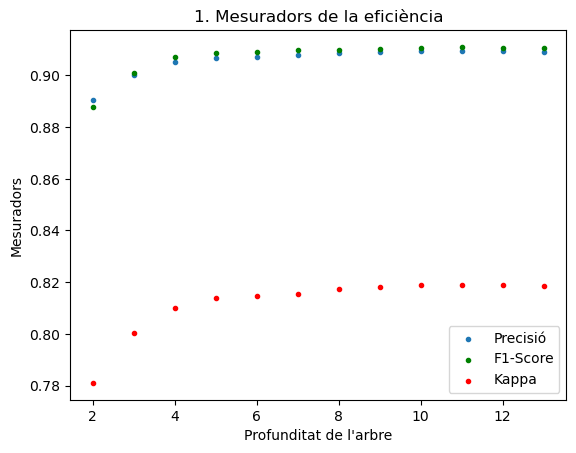

In [107]:
import matplotlib.pyplot as plt
depths = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
acc = [0.890521, 0.900094, 0.905037, 0.906873, 0.907243, 0.907703, 0.908740, 0.909087, 0.909383, 0.909549, 0.909472, 0.909219]
kappa = [0.781038, 0.800189, 0.810078, 0.813750, 0.814490, 0.815411, 0.817482, 0.818176, 0.818768, 0.819101, 0.818946, 0.818441]
F1S = [0.887665, 0.900821, 0.907020, 0.908726, 0.909205, 0.909874, 0.909958, 0.910159, 0.910787, 0.911013, 0.910744, 0.910671]
time = [19, 25, 33, 41, 48, 60, 68, 77, 88, 95, 101, 109]

fig, ax = plt.subplots()
ax.scatter(depths, acc, marker='.', label='Precisió')
ax.scatter(depths, F1S, label='F1-Score', marker='.', color='g')
ax.scatter(depths, kappa, label='Kappa', marker='.', color='r')
ax.legend()
ax.set_xlabel("Profunditat de l'arbre")
ax.set_ylabel('Mesuradors')
ax.set_title('1. Mesuradors de la eficiència')
plt.savefig("D:/OneDrive/Universitat/5. Quint/TFG/RstudioPython/Figures/mesuradors1.png")
plt.show()

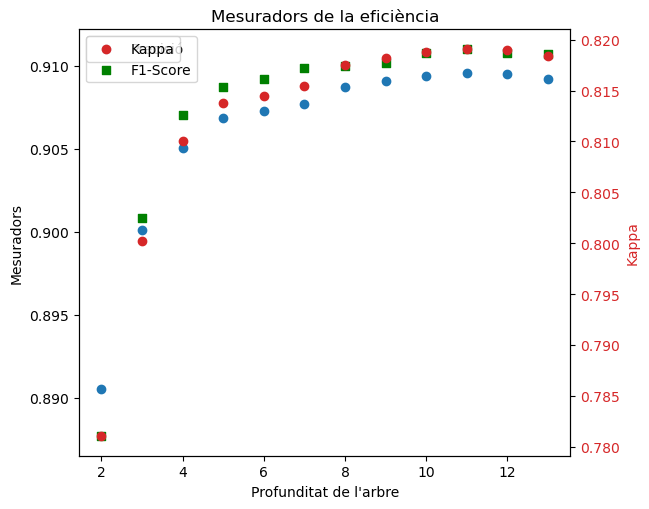

In [106]:
fig, ax = plt.subplots()
ax.scatter(depths, acc, label='Precisió')
ax.scatter(depths, F1S, label='F1-Score', marker='s', color='g')

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Kappa', color=color)  # we already handled the x-label with ax1
ax2.scatter(depths, kappa, color=color, label = "Kappa")
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()

ax.legend()
ax2.legend()
ax.set_xlabel("Profunditat de l'arbre")
ax.set_ylabel('Mesuradors')
ax.set_title('Mesuradors de la eficiència')

plt.savefig("D:/OneDrive/Universitat/5. Quint/TFG/RstudioPython/Figures/mesuradors2.png")
plt.show()

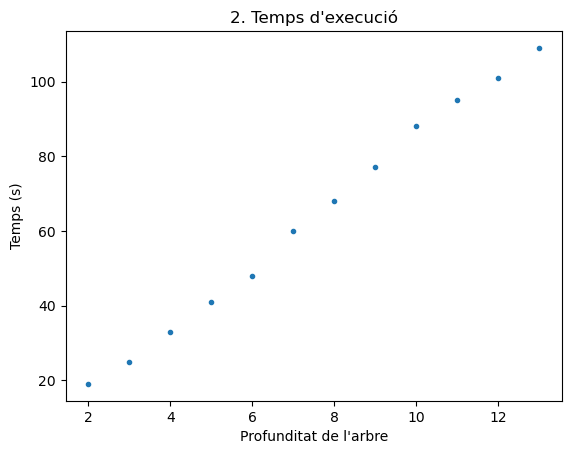

In [108]:
fig, ax = plt.subplots()
ax.scatter(depths, time, marker='.')
ax.set_xlabel("Profunditat de l'arbre")
ax.set_ylabel('Temps (s)')
ax.set_title("2. Temps d'execució")
plt.show()

# Molt linial, ajust?

# **Quarta sessió**

## 0. Càrrega de dades (de nou, sí)

In [1]:
# Data Processing
import pandas as pd
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import time

# Data Filing
import pickle
import os

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn import ensemble

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
# import graphviz

miltr = pd.read_csv(r"C:\Users\alexp\\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\1000_train.csv")
miltst = pd.read_csv(r"C:\Users\alexp\\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\1000_test.csv")
alltr = pd.read_csv(r"C:\Users\alexp\\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\all_train.csv")
alltst = pd.read_csv(r"C:\Users\alexp\\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\all_test.csv")


# Per poder emetre un so quan acaba d'executar una cel·la
# from IPython.display import Audio
# sound_file = "C:/Users/alexp/Downloads/beep.wav"
# Audio(sound_file, autoplay=True)

# Renomenació de columnes
alltr.columns = ["Signal","l_pt","l_eta","l_phi","MET","M_phi","njets","pt1","eta1","phi1","b1","pt2","eta2","phi2","b2",
                 "pt3","eta3","phi3","b3","pt4","eta4","phi4","b4","m_jj","m_jjj","m_lv","m_jlv","m_wwbb","mass"]
alltst.columns = ["Signal","l_pt","l_eta","l_phi","MET","M_phi","njets","pt1","eta1","phi1","b1","pt2","eta2","phi2","b2",
                 "pt3","eta3","phi3","b3","pt4","eta4","phi4","b4","m_jj","m_jjj","m_lv","m_jlv","m_wwbb","mass"]

# Separació en masses
tra = alltr[alltr["mass"] <= 500]
trb = alltr[alltr["mass"] == 750]
trc = alltr[alltr["mass"] == 1000]
trd = alltr[alltr["mass"] == 1250]
tre = alltr[alltr["mass"] == 1500]

tsta = alltst[alltst["mass"] <= 500]
tstb = alltst[alltst["mass"] == 750]
tstc = alltst[alltst["mass"] == 1000]
tstd = alltst[alltst["mass"] == 1250]
tste = alltst[alltst["mass"] == 1500]

# ~ 5 minuts
# Audio(sound_file, autoplay=True)

## 1. Càlcul leafnodes vs. temps execució DT

In [14]:
# Part 1: selecció de variables i de massa

# 1) all variables
# Ydata = np.array(tre.iloc[:,0])
# Xdata = tre.iloc[:,1:27]
# Ytst = np.array(tste.iloc[:,0])
# Xtst = tste.iloc[:,1:27]
# massa = 1500
# label = "1"

# 2) Discriminants raonables
Ydata = np.array(tre.iloc[:,0])
Xdata = tre.loc[:,["pt1","pt2","l_pt","m_wwbb","MET"]]
Ytst = np.array(tste.iloc[:,0])
Xtst = tste.loc[:,["pt1","pt2","l_pt","m_wwbb","MET"]]
massa = 1500
label = "2"


# -------------------------------------------------------
# Part 2: Càlcul DT

rango = range(2,12)
temps = np.zeros(len(rango))
leafnodes = np.zeros(len(rango))

for i in rango:
    startTime = time.time()
    max_depth = i
    clf = tree.DecisionTreeClassifier(max_depth = max_depth)
    clf = clf.fit(Xdata, Ydata)


# -------------------------------------------------------
# Part 3: Avaluació DT

    Ypred = clf.predict(Xtst)
    acc[i] = clf.score(Xtst, Ytst)
    kappa[i] = metrics.cohen_kappa_score(Ypred,Ytst)
    F1S[i] = metrics.f1_score(Ytst,Ypred)
    
# Guardem temps d'execució i leaf_nodes en una variable
    temps[i] = time.time() - startTime
    leafnodes[i] = clf.get_n_leaves()



print(temps, leafnodes)

Audio(sound_file, autoplay=True)




[ 3.97904634  5.87447143  7.81446052 10.04916406 11.82242036 13.88500357
 16.05055046 18.40961003 20.25778604 22.13883853] [   4.    8.   16.   32.   64.  126.  241.  461.  850. 1497.]


#### Representem leaf_nodes vs. temps d'execució

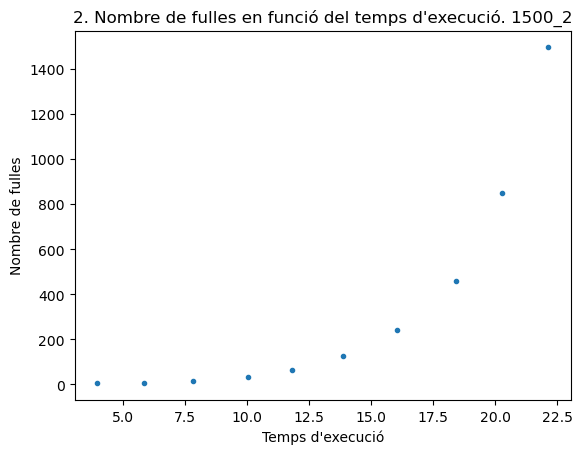

In [15]:
fig, ax = plt.subplots()
dadesinit = str(massa) + "_" + label
ax.scatter(temps, leafnodes, marker='.')
ax.set_xlabel("Temps d'execució")
ax.set_ylabel('Nombre de fulles')
ax.set_title("2. Nombre de fulles en funció del temps d'execució. " + dadesinit)
plt.savefig("D:/OneDrive/Universitat/5. Quint/TFG/RstudioPython/Figures/nleaves.png")
plt.show()

## 2. Dispersió dels mesuradors emprant min-inter-max complexitat, sis o set.

### Representacions de les dispersions

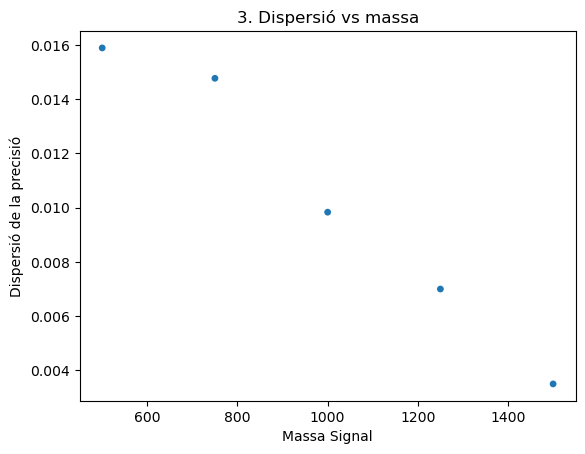

In [9]:
import matplotlib.pyplot as plt
massa = [500,750,1000,1250,1500]
dispAcc = [0.015889, 0.014769,0.009833,0.007,0.003502]
sizes = [60, 60, 60, 60, 60] 
fig, ax = plt.subplots()
ax.scatter(massa, dispAcc,sizes,marker='.')
ax.set_xlabel("Massa Signal")
ax.set_ylabel('Dispersió de la precisió')
ax.set_title('3. Dispersió vs massa')
plt.savefig("D:/OneDrive/Universitat/5. Quint/TFG/RstudioPython/Figures/dispersioMassa.png")
plt.show()

### Decision Trees x

In [16]:
# Mínima complexitat: max_depth = 1
# Màxima complexitat: max_depth = 15?
# Rang raonable: [1,2,3,4,6,10,15]
max_depths = [1,2,3,4,6,10,15]
longitud = len(max_depths)
acc, kappa, F1S, AUC = np.zeros(longitud),np.zeros(longitud),np.zeros(longitud),np.zeros(longitud)


startTime = time.time()

# Part 1: selecció de variables i de massa
# A Variables discriminants raonables
Ydata = np.array(tra.iloc[:,0])
Xdata = tra.loc[:,["pt1","pt2","l_pt","m_jjj","m_jlv"]]
Ytst = np.array(tsta.iloc[:,0])
Xtst = tsta.loc[:,["pt1","pt2","l_pt","m_jjj","m_jlv"]]
massa = 500
label = "A"

# -------------------------------------------------------
# Part 2: Càlcul DT

for i in range(longitud):
    clf = tree.DecisionTreeClassifier(max_depth = max_depths[i], max_features = 5)
    clf = clf.fit(Xdata, Ydata)


# -------------------------------------------------------
# Part 3: Avaluació DT
    Ypred = clf.predict(Xtst)
    acc[i] = clf.score(Xtst, Ytst)
    kappa[i] = metrics.cohen_kappa_score(Ypred,Ytst)
    F1S[i] = metrics.f1_score(Ytst,Ypred)
    AUC[i] = metrics.roc_auc_score(Ypred,Ytst)

print("DTs amb massa %i i selecció de variables %s.\n Precisió: %f ± %f. Kappa: %f ± %f. F1-Score: %f ± %f." 
      %(massa, label, np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S)))


with open("Output.txt", "w") as text_file:
    text_file.write("DTs amb massa %i i selecció de variables %s.\n Precisió: %f ± %f. Kappa: %f ± %f. F1-Score: %f ± %f." 
      %(massa, label, np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S)))

DTs amb massa 500 i selecció de variables A.
 Precisió: 0.613230 ± 0.012189. Kappa: 0.226342 ± 0.024431. F1-Score: 0.664806 ± 0.012458.


In [13]:
accnou = clf.score(Xdata,Ydata)
print(accnou)

0.6576377202321668


In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix(Ytst,Ypred))


In [9]:
print(AUC)

[0.62349724 0.62676917 0.64658767 0.64480578 0.62937708 0.63418751
 0.62793458]


#### Provem ara a variar min_samples_leaf i min_samples_split

In [7]:
# Mínima complexitat: max_depth = 1
# Màxima complexitat: max_depth = 15?
# Rang raonable: [1,2,3,4,6,10,15]
max_depths = [1,2,3,4,6,10,15]
min_samples_leaf = [1_000,2_000,15_000,50_000,100_000]
iter_depths = 3

longitud = len(min_samples_leaf)
acc, kappa, F1S, AUC = np.zeros(longitud),np.zeros(longitud),np.zeros(longitud),np.zeros(longitud)


startTime = time.time()

# Part 1: selecció de variables i de massa
# A Variables discriminants raonables
Ydata = np.array(tra.iloc[:,0])
Xdata = tra.loc[:,["pt1","pt2","l_pt","m_wwbb","MET"]]
Ytst = np.array(tsta.iloc[:,0])
Xtst = tsta.loc[:,["pt1","pt2","l_pt","m_wwbb","MET"]]
massa = 500
label = "A"

# -------------------------------------------------------
# Part 2: Càlcul DT

for i in range(longitud):
    clf = tree.DecisionTreeClassifier(max_depth = max_depths[iter_depths], min_samples_leaf = min_samples_leaf[i])
    clf = clf.fit(Xdata, Ydata)


# -------------------------------------------------------
# Part 3: Avaluació DT
    Ypred = clf.predict(Xtst)
    acc[i] = clf.score(Xtst, Ytst)
    kappa[i] = metrics.cohen_kappa_score(Ypred,Ytst)
    F1S[i] = metrics.f1_score(Ytst,Ypred)
    AUC[i] = metrics.roc_auc_score(Ytst, Ypred)

    
print("DTs amb massa %i i selecció de variables %s. Max-depth = %i. Variació en min_samples_leaf.\n Precisió: %f ± %f. Kappa: %f ± %f. F1-Score: %f ± %f. AUC: %f ± %f.\n" 
      %(massa, label, max_depths[iter_depths], np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S), np.mean(AUC), np.std(AUC)))


with open("Output.txt", "w") as text_file:
    text_file.write("DTs amb massa %i i selecció de variables %s. Max_depth = %i, variació en min_samples_leaf.\n Precisió: %f ± %f. Kappa: %f ± %f. F1-Score: %f ± %f. AUC: %f ± %f.\n" 
      %(massa, label,max_depths[iter_depths], np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S), np.mean(AUC), np.std(AUC)))
    
with open("Output.txt", 'a') as f:
    accString = (pd.DataFrame(acc)).to_string(header=False, index=False)
    kappaString = (pd.DataFrame(kappa)).to_string(header=False, index=False)
    F1SString = (pd.DataFrame(F1S)).to_string(header=False, index=False)
    AUCString = (pd.DataFrame(AUC)).to_string(header=False, index=False)
    f.write("Acc = " + accString + "\nKappa = " + kappaString + "\nF1-Score = " + F1SString + "\nAUC = " + AUCString)

DTs amb massa 500 i selecció de variables A. Max-depth = 4. Variació en min_samples_leaf.
 Precisió: 0.607136 ± 0.000727. Kappa: 0.214103 ± 0.001447. F1-Score: 0.678104 ± 0.017295. AUC: 0.607029 ± 0.000722.



### Random Forest

#### Primers càlculs

In [2]:
with open("Output.txt", 'a') as f:
    accString = (pd.DataFrame(acc)).to_string(header=False, index=False)
    kappaString = (pd.DataFrame(kappa)).to_string(header=False, index=False)
    F1SString = (pd.DataFrame(F1S)).to_string(header=False, index=False)
    f.write("Acc = " + accString + "\nKappa = " + kappaString + "\nF1-Score = " + F1SString)

In [ ]:
# Mínima complexitat: max_depth = 1
# Màxima complexitat: max_depth = 15?
# Rang raonable: [1,2,3,4,6,10,15]

max_depths = [1,2,3,4,6,10]
n_estimators = [5,10,50,100,200]
lon, wid = len(max_depths),len(n_estimators)

acc, kappa, F1S = np.zeros((lon,wid)),np.zeros((lon,wid)),np.zeros((lon,wid))


startTime = time.time()

# Part 1: selecció de variables i de massa

# A Variables discriminants raonables
# Ydata = np.array(trc.iloc[:,0])
# Xdata = trc.loc[:,["pt1","pt2","l_pt","m_wwbb","MET"]]
# Ytst = np.array(tstc.iloc[:,0])
# Xtst = tstc.loc[:,["pt1","pt2","l_pt","m_wwbb","MET"]]
# massa = 1000
# label = "A"

# B Sense partir en diferents masses, emprar la massa com a feature
# Ydata = np.array(alltr.loc[:,"Signal"])
# Xdata = np.array(alltr.loc[:,["l_pt","m_jlv","m_wwbb","mass"]])
# Ytst = np.array(alltr.loc[:,"Signal"])
# Xtst = np.array(alltr.loc[:,["l_pt","m_jlv","m_wwbb","mass"]])
# massa = "all"
# label = "B"

# C Variables discriminants raonables
Ydata = np.array(tra.iloc[:,0])
Xdata = tra.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
Ytst = np.array(tsta.iloc[:,0])
Xtst = tsta.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
massa = 500
label = "C"

# -------------------------------------------------------
# Part 2: Càlcul RF

for i_depth in range(lon):
    for j_estim in range(wid):
        rf = RandomForestClassifier(max_depth = max_depths[i_depth],n_estimators = n_estimators[j_estim])
        rf = rf.fit(Xdata, Ydata)


# -------------------------------------------------------
# Part 3: Avaluació RF
        Ypred = rf.predict(Xtst)
        acc[i_depth,j_estim] = rf.score(Xtst, Ytst)
        kappa[i_depth,j_estim] = metrics.cohen_kappa_score(Ypred,Ytst)
        F1S[i_depth,j_estim] = metrics.f1_score(Ytst,Ypred)
        print("Depth %i, Estimators %i DONE" % (max_depths[i_depth], n_estimators[j_estim]))


    
print("Temps total: " + str(time.time()-startTime))    
print("RFs amb massa %i i selecció de variables %s.\n Precisió: %f ± %f. Kappa: %f ± %f. F1-Score: %f ± %f." 
      %(massa, label, np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S)))


with open("Output.txt", "a") as text_file:
    text_file.write("\n\nRFs amb massa %i i selecció de variables %s.\n Precisió: %f ± %f. Kappa: %f ± %f. F1-Score: %f ± %f.\n" 
      %(massa, label, np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S)))
    
with open("Output.txt", 'a') as f:
    accString = (pd.DataFrame(acc)).to_string(header=False, index=False)
    kappaString = (pd.DataFrame(kappa)).to_string(header=False, index=False)
    F1SString = (pd.DataFrame(F1S)).to_string(header=False, index=False)
    f.write("Acc = " + accString + "\nKappa = " + kappaString + "\nF1-Score = " + F1SString)

In [ ]:
print("RFs amb massa %s i selecció de variables %s.\n Precisió: %f ± %f. Kappa: %f ± %f. F1-Score: %f ± %f." 
      %(massa, label, np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S)))


with open("Output.txt", "a") as text_file:
    text_file.write("\n\nRFs amb massa %s i selecció de variables %s.\n Precisió: %f ± %f. Kappa: %f ± %f. F1-Score: %f ± %f.\n" 
      %(massa, label, np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S)))
    
with open("Output.txt", 'a') as f:
    accString = (pd.DataFrame(acc)).to_string(header=False, index=False)
    kappaString = (pd.DataFrame(kappa)).to_string(header=False, index=False)
    F1SString = (pd.DataFrame(F1S)).to_string(header=False, index=False)
    f.write("Acc = " + accString + "\nKappa = " + kappaString + "\nF1-Score = " + F1SString)

#### Prova amb un sol

In [ ]:
# Part 1: definim Ydata, Ytst per a tots i Xdata, Xtst per a cada cas 
startTime = time.time()

# Ydata = np.array(miltr.index)
# Ytst = np.array(miltst.iloc[:,0])

Ydata = alltr.iloc[:,0]
Ytst = alltst.iloc[:,0]

# d) Selecció 2
# Xdata = np.array(miltr.iloc[:,[0,3,6,26]])
# Xtst = np.array(miltst.iloc[:,[1,4,7,27]])
# label = "d"

# j) Alltr: 0 25 26 27
Xdata = np.array(alltr.loc[:,["l_pt","m_jlv","m_wwbb","mass"]])
Xtst = np.array(alltst.loc[:,["l_pt","m_jlv","m_wwbb","mass"]])
label = "j"

# j2) Alltr: 0 25 26 27
# Xdata = alltr.loc[:,["f0","f25","f26","mass"]]
# Xtst = alltst.loc[:,["f0","f25","f26","mass"]]
# label = "j2"


# Part 2: càlcul RF
# Create a random forest classifier
max_depth = 3
n_estimators = 500
rf = RandomForestClassifier(max_depth = max_depth,n_estimators = n_estimators)
rf.fit(Xdata, Ydata)

       
# Part 3: avaluació RF
Ypred = rf.predict(Xtst)
acc = accuracy_score(Ytst,Ypred)
kappa = metrics.cohen_kappa_score(Ypred,Ytst)
F1S = metrics.f1_score(Ytst,Ypred)
temps = time.time() - startTime

# print("RT amb profunditat %i.\nPrecisió = %f; kappa = %f; F1-Score = %f.\nTemps d'execució = %i segons" 
#       % (max_depth,acc,kappa,F1S,temps)) # Format agradable

print("| %s | %i | %i | %f | %f | %f | %i |" % (label,max_depth,n_estimators,acc,kappa,F1S,temps)) # Format per copiar i pegar a la taula

#### Mantenim max_depth i n_estimators, canviem min_samples_leaf


In [15]:
def RandomLeafs(Xdata,Ydata,Xtst,Ytst,massa,label):
    startTime = time.time()
    max_depths = [1,2,3,4,6,10,15]
    n_estimators = [5,10,50,100,200]
    min_samples_leaf = [1_000,2_000,15_000,50_000,100_000]
    iter_depths = 3
    iter_n = 2

    longitud = len(min_samples_leaf)
    acc, kappa, F1S, AUC, meanFinalDepth = np.zeros(longitud),np.zeros(longitud),np.zeros(longitud),np.zeros(longitud),np.zeros(longitud)
    for i in range(longitud):
        clf = RandomForestClassifier(max_depth = max_depths[iter_depths],n_estimators = n_estimators[iter_n], min_samples_leaf = min_samples_leaf[i])
        clf = clf.fit(Xdata, Ydata)


    # -------------------------------------------------------
    # Part 3: Avaluació DT
        Ypred = clf.predict(Xtst)
        acc[i] = clf.score(Xtst, Ytst)
        kappa[i] = metrics.cohen_kappa_score(Ypred,Ytst)
        F1S[i] = metrics.f1_score(Ytst,Ypred)
        AUC[i] = metrics.roc_auc_score(Ytst, Ypred)
        meanFinalDepth[i] = np.mean([estimator.tree_.max_depth for estimator in clf.estimators_])
        print("Leaf %i DONE, current time %f s" % (min_samples_leaf[i], startTime-time.time()))

    print("RFs amb massa %i i selecció de variables %s. Max-depth = %i, n_estimators = %i. Variació en min_samples_leaf.\n Precisió: %f ± %f. Kappa: %f ± %f. F1-Score: %f ± %f. AUC: %f ± %f.\n" 
          %(massa, label, max_depths[iter_depths],n_estimators[iter_n], np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S), np.mean(AUC), np.std(AUC)))

    with open("Output.txt", "a") as text_file:
        text_file.write("RFs amb massa %i i selecció de variables %s. Max_depth = %i, n_estimators = %i. Variació en min_samples_leaf.\n Precisió: %f ± %f. Kappa: %f ± %f. F1-Score: %f ± %f. AUC: %f ± %f.\n" 
          %(massa, label,max_depths[iter_depths],n_estimators[iter_n], np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S), np.mean(AUC), np.std(AUC)))
        accString = (pd.DataFrame(acc)).to_string(header=False, index=False)
        kappaString = (pd.DataFrame(kappa)).to_string(header=False, index=False)
        F1SString = (pd.DataFrame(F1S)).to_string(header=False, index=False)
        AUCString = (pd.DataFrame(AUC)).to_string(header=False, index=False)
        meanFinalDepthString = (pd.DataFrame(meanFinalDepth)).to_string(header=False, index=False)
        
        text_file.write("Acc = " + accString + "\nKappa = " + kappaString + "\nF1-Score = " + F1SString + "\nAUC = " + AUCString + "\nMFD = " + meanFinalDepthString)
    
    print("\n\nMassa = %i DONE\n\n" %(massa))

In [16]:
Ydata = np.array(tre.iloc[:,0])
Xdata = tre.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
Ytst = np.array(tste.iloc[:,0])
Xtst = tste.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
massa = 1500
label = "C"
RandomLeafs(Xdata,Ydata,Xtst,Ytst,massa,label)
Ydata = np.array(trd.iloc[:,0])
Xdata = trd.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
Ytst = np.array(tstd.iloc[:,0])
Xtst = tstd.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
massa = 1250
label = "C"
RandomLeafs(Xdata,Ydata,Xtst,Ytst,massa,label)
Ydata = np.array(trc.iloc[:,0])
Xdata = trc.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
Ytst = np.array(tstc.iloc[:,0])
Xtst = tstc.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
massa = 1000
label = "C"
RandomLeafs(Xdata,Ydata,Xtst,Ytst,massa,label)
Ydata = np.array(trb.iloc[:,0])
Xdata = trb.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
Ytst = np.array(tstb.iloc[:,0])
Xtst = tstb.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
massa = 750
label = "C"
RandomLeafs(Xdata,Ydata,Xtst,Ytst,massa,label)
Ydata = np.array(tra.iloc[:,0])
Xdata = tra.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
Ytst = np.array(tsta.iloc[:,0])
Xtst = tsta.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
massa = 500
label = "C"
RandomLeafs(Xdata,Ydata,Xtst,Ytst,massa,label)

Leaf 1000 DONE, current time -171.274668 s
Leaf 2000 DONE, current time -331.423993 s
Leaf 15000 DONE, current time -482.102312 s
Leaf 50000 DONE, current time -615.467549 s
Leaf 100000 DONE, current time -724.163392 s
RFs amb massa 1500 i selecció de variables C. Max-depth = 4, n_estimators = 50. Variació en min_samples_leaf.
 Precisió: 0.954000 ± 0.002879. Kappa: 0.908000 ± 0.005757. F1-Score: 0.954385 ± 0.002763. AUC: 0.954001 ± 0.002878.



Massa = 1500 DONE


Leaf 1000 DONE, current time -163.144205 s
Leaf 2000 DONE, current time -323.080739 s
Leaf 15000 DONE, current time -484.533256 s
Leaf 50000 DONE, current time -642.444634 s
Leaf 100000 DONE, current time -782.671002 s
RFs amb massa 1250 i selecció de variables C. Max-depth = 4, n_estimators = 50. Variació en min_samples_leaf.
 Precisió: 0.936648 ± 0.002190. Kappa: 0.873294 ± 0.004380. F1-Score: 0.937230 ± 0.002259. AUC: 0.936645 ± 0.002190.



Massa = 1250 DONE


Leaf 1000 DONE, current time -190.872503 s
Leaf 2000 DONE, cur

In [9]:
# Mínima complexitat: max_depth = 1
# Màxima complexitat: max_depth = 15?
# Rang raonable: [1,2,3,4,6,10,15]

max_depths = [1,2,3,4,6,10,15]
n_estimators = [5,10,50,100,200]
min_samples_leaf = [1_000,2_000,15_000,50_000,100_000]
iter_depths = 3
iter_n = 2

longitud = len(min_samples_leaf)
acc, kappa, F1S, AUC = np.zeros(longitud),np.zeros(longitud),np.zeros(longitud),np.zeros(longitud)


startTime = time.time()

# Part 1: selecció de variables i de massa
# A Variables discriminants raonables
# Ydata = np.array(tra.iloc[:,0])
# Xdata = tra.loc[:,["pt1","pt2","l_pt","m_wwbb","MET"]]
# Ytst = np.array(tsta.iloc[:,0])
# Xtst = tsta.loc[:,["pt1","pt2","l_pt","m_wwbb","MET"]]
# massa = 500
# label = "A"

# B Sense partir en diferents masses, emprar la massa com a feature
# Ydata = np.array(alltr.loc[:,"Signal"])
# Xdata = np.array(alltr.loc[:,["l_pt","m_jlv","m_wwbb","mass"]])
# Ytst = np.array(alltr.loc[:,"Signal"])
# Xtst = np.array(alltr.loc[:,["l_pt","m_jlv","m_wwbb","mass"]])
# massa = "all"
# label = "B"

# C Variables discriminants raonables
Ydata = np.array(tre.iloc[:,0])
Xdata = tre.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
Ytst = np.array(tste.iloc[:,0])
Xtst = tste.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
massa = 1500
label = "C"


# -------------------------------------------------------
# Part 2: Càlcul DT

for i in range(longitud):
    clf = RandomForestClassifier(max_depth = max_depths[iter_depths],n_estimators = n_estimators[iter_n], min_samples_leaf = min_samples_leaf[i])
    clf = clf.fit(Xdata, Ydata)


# -------------------------------------------------------
# Part 3: Avaluació DT
    Ypred = clf.predict(Xtst)
    acc[i] = clf.score(Xtst, Ytst)
    kappa[i] = metrics.cohen_kappa_score(Ypred,Ytst)
    F1S[i] = metrics.f1_score(Ytst,Ypred)
    AUC[i] = metrics.roc_auc_score(Ytst, Ypred)
    print("Leaf %i DONE, current time %f s" % (min_samples_leaf[i], startTime-time.time()))

    
print("RFs amb massa %i i selecció de variables %s. Max-depth = %i, n_estimators = %i. Variació en min_samples_leaf.\n Precisió: %f ± %f. Kappa: %f ± %f. F1-Score: %f ± %f. AUC: %f ± %f.\n" 
      %(massa, label, max_depths[iter_depths],n_estimators[iter_n], np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S), np.mean(AUC), np.std(AUC)))


with open("Output.txt", "a") as text_file:
    text_file.write("RFs amb massa %i i selecció de variables %s. Max_depth = %i, n_estimators = %i. Variació en min_samples_leaf.\n Precisió: %f ± %f. Kappa: %f ± %f. F1-Score: %f ± %f. AUC: %f ± %f.\n" 
      %(massa, label,max_depths[iter_depths],n_estimators[iter_n], np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S), np.mean(AUC), np.std(AUC)))
    accString = (pd.DataFrame(acc)).to_string(header=False, index=False)
    kappaString = (pd.DataFrame(kappa)).to_string(header=False, index=False)
    F1SString = (pd.DataFrame(F1S)).to_string(header=False, index=False)
    AUCString = (pd.DataFrame(AUC)).to_string(header=False, index=False)
    f.write("Acc = " + accString + "\nKappa = " + kappaString + "\nF1-Score = " + F1SString + "\nAUC = " + AUCString)

Leaf 1000 DONE, current time -168.018193 s
Leaf 2000 DONE, current time -332.750238 s
Leaf 15000 DONE, current time -488.568363 s
Leaf 50000 DONE, current time -631.917415 s
Leaf 100000 DONE, current time -743.419940 s
RFs amb massa 1500 i selecció de variables C. Max-depth = 4, n_estimators = 50. Variació en min_samples_leaf.
 Precisió: 0.953559 ± 0.003004. Kappa: 0.907119 ± 0.006007. F1-Score: 0.954178 ± 0.002603. AUC: 0.953562 ± 0.003002.



### AdaBoost

In [5]:
n_estimators = [5,10,50,100,200,1000]
progress = [5/13.65,15/13.65,65/13.65,165/13.65,365/13.65,1365/13.65]
longitud = len(n_estimators)
acc, kappa, F1S = np.zeros(longitud),np.zeros(longitud),np.zeros(longitud)

startTime = time.time()
 
# Part 1: selecció de variables i de massa
# A Variables discriminants raonables
Ydata = np.array(tre.iloc[:,0])
Xdata = tre.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
Ytst = np.array(tste.iloc[:,0])
Xtst = tste.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
massa = 1500
label = "C"

# -------------------------------------------------------
# Part 2: Càlcul DT

for i in range(longitud):
    bdt = ensemble.AdaBoostClassifier(n_estimators = n_estimators[i])
    bdt = bdt.fit(Xdata, Ydata)


# -------------------------------------------------------
# Part 3: Avaluació DT
    Ypred = bdt.predict(Xtst)
    acc[i] = bdt.score(Xtst, Ytst)
    kappa[i] = metrics.cohen_kappa_score(Ypred,Ytst)
    F1S[i] = metrics.f1_score(Ytst,Ypred)
    print("Estimators %i DONE - ~ %f %%" % (n_estimators[i], progress[i]))

print("BDTs amb massa %i i selecció de variables %s.\n Precisió: %f ± %f. Kappa: %f ± %f. F1-Score: %f ± %f." 
      %(massa, label, np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S)))


with open("Output.txt", "w") as f:
    f.write("BDTs amb massa %i i selecció de variables %s.\n Precisió: %f ± %f. Kappa: %f ± %f. F1-Score: %f ± %f." 
      %(massa, label, np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S)))
    
with open("Output.txt", 'a') as f:
    accString = (pd.DataFrame(acc)).to_string(header=False, index=False)
    kappaString = (pd.DataFrame(kappa)).to_string(header=False, index=False)
    F1SString = (pd.DataFrame(F1S)).to_string(header=False, index=False)
    f.write("Acc = " + accString + "\nKappa = " + kappaString + "\nF1-Score = " + F1SString)

Estimators 5 DONE - ~ 0.003663 %
Estimators 10 DONE - ~ 0.010989 %
Estimators 50 DONE - ~ 0.047619 %
Estimators 100 DONE - ~ 0.120879 %
Estimators 200 DONE - ~ 0.267399 %
Estimators 1000 DONE - ~ 1.000000 %
BDTs amb massa 1250 i selecció de variables C.
 Precisió: 0.935618 ± 0.007176. Kappa: 0.871235 ± 0.014353. F1-Score: 0.936805 ± 0.006231.


## 3. Càlcul AUC per a diferentes hiperparàmetres i masses.

#### Decision Tree

In [4]:
def DecisionTreer(Xdata,Xtst,Ydata,Ytst,massa,label):
    max_depths = [1,2,3,4,5,6,10,15]
    longitud = len(max_depths)
    acc, kappa, F1S, AUC = np.zeros(longitud),np.zeros(longitud),np.zeros(longitud),np.zeros(longitud)
    startTime = time.time()
    for i in range(longitud):
        clf = tree.DecisionTreeClassifier(max_depth = max_depths[i])
        clf = clf.fit(Xdata, Ydata)


    # -------------------------------------------------------
    # Part 3: Avaluació DT
        Ypred = clf.predict(Xtst)
        acc[i] = clf.score(Xtst, Ytst)
        kappa[i] = metrics.cohen_kappa_score(Ypred, Ytst)
        F1S[i] = metrics.f1_score(Ytst, Ypred)
        AUC[i] = metrics.roc_auc_score(Ytst, Ypred)

    print("DTs amb massa %i i selecció de variables %s.\n Precisió: %f ± %f. Kappa: %f ± %f. F1-Score: %f ± %f. AUC: %f ± %f.\n" 
          %(massa, label, np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S), np.mean(AUC), np.std(AUC)))


    with open("Output.txt", "a") as text_file:
        text_file.write("DTs amb massa %i i selecció de variables %s.\n Precisió: %f ± %f  Kappa: %f ± %f  F1-Score: %f ± %f  AUC: %f ± %f \n" 
          %(massa, label, np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S), np.mean(AUC), np.std(AUC)))
        accString = (pd.DataFrame(acc)).to_string(header=False, index=False)
        kappaString = (pd.DataFrame(kappa)).to_string(header=False, index=False)
        F1SString = (pd.DataFrame(F1S)).to_string(header=False, index=False)
        AUCString = (pd.DataFrame(AUC)).to_string(header=False, index=False)
        text_file.write("Acc = " + accString + "\nKappa = " + kappaString + "\nF1-Score = " + F1SString + "\nAUC = " + AUCString)

In [5]:
# A Variables discriminants raonables
Ydata = np.array(tra.iloc[:,0])
Xdata = tra.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
Ytst = np.array(tsta.iloc[:,0])
Xtst = tsta.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
massa = 500
label = "C"
DecisionTreer(Xdata,Xtst,Ydata,Ytst,massa,label)
Ydata = np.array(trb.iloc[:,0])
Xdata = trb.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
Ytst = np.array(tstb.iloc[:,0])
Xtst = tstb.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
massa = 750
label = "C"
DecisionTreer(Xdata,Xtst,Ydata,Ytst,massa,label)
Ydata = np.array(trc.iloc[:,0])
Xdata = trc.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
Ytst = np.array(tstc.iloc[:,0])
Xtst = tstc.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
massa = 1000
label = "C"
DecisionTreer(Xdata,Xtst,Ydata,Ytst,massa,label)
Ydata = np.array(trd.iloc[:,0])
Xdata = trd.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
Ytst = np.array(tstd.iloc[:,0])
Xtst = tstd.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
massa = 1250
label = "C"
DecisionTreer(Xdata,Xtst,Ydata,Ytst,massa,label)
Ydata = np.array(tre.iloc[:,0])
Xdata = tre.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
Ytst = np.array(tste.iloc[:,0])
Xtst = tste.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
massa = 1500
label = "C"
DecisionTreer(Xdata,Xtst,Ydata,Ytst,massa,label)

DTs amb massa 500 i selecció de variables C.
 Precisió: 0.617486 ± 0.017521. Kappa: 0.234846 ± 0.035099. F1-Score: 0.671724 ± 0.013093. AUC: 0.617405 ± 0.017555.

DTs amb massa 750 i selecció de variables C.
 Precisió: 0.820570 ± 0.013996. Kappa: 0.641162 ± 0.027990. F1-Score: 0.826694 ± 0.013844. AUC: 0.820600 ± 0.013996.

DTs amb massa 1000 i selecció de variables C.
 Precisió: 0.900667 ± 0.009462. Kappa: 0.801340 ± 0.018932. F1-Score: 0.901226 ± 0.010663. AUC: 0.900684 ± 0.009484.

DTs amb massa 1250 i selecció de variables C.
 Precisió: 0.933471 ± 0.006839. Kappa: 0.866942 ± 0.013679. F1-Score: 0.933920 ± 0.006857. AUC: 0.933470 ± 0.006840.

DTs amb massa 1500 i selecció de variables C.
 Precisió: 0.953043 ± 0.003450. Kappa: 0.906087 ± 0.006901. F1-Score: 0.953534 ± 0.003149. AUC: 0.953045 ± 0.003450.



In [3]:
# Mínima complexitat: max_depth = 1
# Màxima complexitat: max_depth = 15?
# Rang raonable: [1,2,3,4,6,10,15]

# max_depths = [1,2,3,4,6,10,15]
max_depths = [1,2,3,4]
longitud = len(max_depths)
acc, kappa, F1S, AUC = np.zeros(longitud),np.zeros(longitud),np.zeros(longitud),np.zeros(longitud)

startTime = time.time()

# Part 1: selecció de variables i de massa
# A Variables discriminants raonables
Ydata = np.array(tra.iloc[:,0])
Xdata = tra.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
Ytst = np.array(tsta.iloc[:,0])
Xtst = tsta.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
massa = 500
label = "C"

# -------------------------------------------------------
# Part 2: Càlcul DT

for i in range(longitud):
    clf = tree.DecisionTreeClassifier(max_depth = max_depths[i])
    clf = clf.fit(Xdata, Ydata)


# -------------------------------------------------------
# Part 3: Avaluació DT
    Ypred = clf.predict(Xtst)
    acc[i] = clf.score(Xtst, Ytst)
    kappa[i] = metrics.cohen_kappa_score(Ypred, Ytst)
    F1S[i] = metrics.f1_score(Ytst, Ypred)
    AUC[i] = metrics.roc_auc_score(Ytst, Ypred)

print("DTs amb massa %i i selecció de variables %s.\n Precisió: %f ± %f. Kappa: %f ± %f. F1-Score: %f ± %f. AUC: %f ± %f.\n" 
      %(massa, label, np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S), np.mean(AUC), np.std(AUC)))


with open("Output.txt", "w") as text_file:
    text_file.write("DTs amb massa %i i selecció de variables %s.\n Precisió: %f ± %f. Kappa: %f ± %f. F1-Score: %f ± %f. AUC: %f ± %f.\n" 
      %(massa, label, np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S), np.mean(AUC), np.std(AUC)))
    
with open("Output.txt", 'a') as f:
    accString = (pd.DataFrame(acc)).to_string(header=False, index=False)
    kappaString = (pd.DataFrame(kappa)).to_string(header=False, index=False)
    F1SString = (pd.DataFrame(F1S)).to_string(header=False, index=False)
    AUCString = (pd.DataFrame(AUC)).to_string(header=False, index=False)
    f.write("Acc = " + accString + "\nKappa = " + kappaString + "\nF1-Score = " + F1SString + "\nAUC = " + AUCString)

DTs amb massa 500 i selecció de variables C.
 Precisió: 0.602514 ± 0.005032. Kappa: 0.204840 ± 0.010063. F1-Score: 0.680775 ± 0.006904.


#### Random Forest

In [11]:
def RandomForester(Xdata,Ydata,Xtst,Ytst,label,massa):
    max_depths = [1,2,3,4,6,10]
    n_estimators = [5,10,50,100,200]
    lon, wid = len(max_depths),len(n_estimators)
    acc, kappa, F1S, AUC = np.zeros((lon,wid)),np.zeros((lon,wid)),np.zeros((lon,wid)),np.zeros((lon,wid))
    startTime = time.time()

# -------------------------------------------------------
# Part 2: Càlcul RF

    for i_depth in range(lon):
        for j_estim in range(wid):
            rf = RandomForestClassifier(max_depth = max_depths[i_depth],n_estimators = n_estimators[j_estim])
            rf = rf.fit(Xdata, Ydata)


    # -------------------------------------------------------
    # Part 3: Avaluació RF
            Ypred = rf.predict(Xtst)
            acc[i_depth,j_estim] = rf.score(Xtst, Ytst)
            kappa[i_depth,j_estim] = metrics.cohen_kappa_score(Ypred,Ytst)
            F1S[i_depth,j_estim] = metrics.f1_score(Ytst,Ypred)
            AUC[i_depth,j_estim] = metrics.roc_auc_score(Ytst, Ypred)
            print("Depth %i, Estimators %i DONE" % (max_depths[i_depth], n_estimators[j_estim]))


    print(acc)
#     print("Temps total: " + str(time.time()-startTime) + "\n")    
#     print("DTs amb massa %i i selecció de variables %s.\n Precisió: %f ± %f. Kappa: %f ± %f. F1-Score: %f ± %f. AUC: %f ± %f.\n" 
#           %(massa, label, np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S), np.mean(AUC), np.std(AUC)))


#     with open("Output.txt", "a") as text_file:
#         text_file.write("DTs amb massa %i i selecció de variables %s.\n Precisió: %f ± %f  Kappa: %f ± %f  F1-Score: %f ± %f  AUC: %f ± %f \n" 
#           %(massa, label, np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S), np.mean(AUC), np.std(AUC)))
#         accString = (pd.DataFrame(acc)).to_string(header=False, index=False)
#         kappaString = (pd.DataFrame(kappa)).to_string(header=False, index=False)
#         F1SString = (pd.DataFrame(F1S)).to_string(header=False, index=False)
#         AUCString = (pd.DataFrame(AUC)).to_string(header=False, index=False)
#         text_file.write("Acc = " + accString + "\nKappa = " + kappaString + "\nF1-Score = " + F1SString + "\nAUC = " + AUCString)

In [12]:
# # A Variables discriminants raonables
# Ydata = np.array(tra.iloc[:,0])
# Xdata = tra.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
# Ytst = np.array(tsta.iloc[:,0])
# Xtst = tsta.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
# massa = 500
# label = "C"
# RandomForester(Xdata,Ydata,Xtst,Ytst,label,massa)
# Ydata = np.array(trb.iloc[:,0])
# Xdata = trb.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
# Ytst = np.array(tstb.iloc[:,0])
# Xtst = tstb.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
# massa = 750
# label = "C"
# RandomForester(Xdata,Ydata,Xtst,Ytst,label,massa)
# Ydata = np.array(trc.iloc[:,0])
# Xdata = trc.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
# Ytst = np.array(tstc.iloc[:,0])
# Xtst = tstc.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
# massa = 1000
# label = "C"
# RandomForester(Xdata,Ydata,Xtst,Ytst,label,massa)
# Ydata = np.array(trd.iloc[:,0])
# Xdata = trd.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
# Ytst = np.array(tstd.iloc[:,0])
# Xtst = tstd.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
# massa = 1250
# label = "C"
# RandomForester(Xdata,Ydata,Xtst,Ytst,label,massa)
Ydata = np.array(tre.iloc[:,0])
Xdata = tre.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
Ytst = np.array(tste.iloc[:,0])
Xtst = tste.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
massa = 1500
label = "C"
RandomForester(Xdata,Ydata,Xtst,Ytst,label,massa)

Depth 1, Estimators 5 DONE
Depth 1, Estimators 10 DONE
Depth 1, Estimators 50 DONE
Depth 2, Estimators 5 DONE
Depth 2, Estimators 10 DONE
Depth 2, Estimators 50 DONE
Depth 3, Estimators 5 DONE
Depth 3, Estimators 10 DONE
Depth 3, Estimators 50 DONE
[[0.9435899  0.9505351  0.9448241 ]
 [0.94384846 0.94992229 0.9532449 ]
 [0.95373487 0.95332347 0.95594184]]


#### BDTs

In [2]:
def BoostedDecisioner(n_estimators,Xdata,Ydata,Xtst,Ytst,label,massa):
    # n_estimators = [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
    # n_estimators = [2,5,11,26,59,130,300,660,1500]
    longitud = len(n_estimators)
    acc, kappa, F1S, AUC = np.zeros(longitud),np.zeros(longitud),np.zeros(longitud),np.zeros(longitud)

    startTime = time.time()
    
    # -------------------------------------------------------
    # Part 2: Càlcul DT

    for i in range(longitud):
        bdt = ensemble.AdaBoostClassifier(n_estimators = n_estimators[i])
        bdt = bdt.fit(Xdata, Ydata)


    # -------------------------------------------------------
    # Part 3: Avaluació DT
        Ypred = bdt.predict(Xtst)
        acc[i] = bdt.score(Xtst, Ytst)
        kappa[i] = metrics.cohen_kappa_score(Ypred,Ytst)
        F1S[i] = metrics.f1_score(Ytst,Ypred)
        AUC[i] = metrics.roc_auc_score(Ytst, Ypred)
        print("Estimators %i DONE" % (n_estimators[i]))

    print("Temps total: " + str(time.time()-startTime) + "\n")    
    print("BDTs amb massa %i i selecció de variables %s.\n Precisió: %f ± %f. Kappa: %f ± %f. F1-Score: %f ± %f. AUC: %f ± %f.\n" 
          %(massa, label, np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S), np.mean(AUC), np.std(AUC)))


    with open("Output.txt", "a") as text_file:
        text_file.write("BDTs amb massa %i i selecció de variables %s.\n Precisió: %f ± %f  Kappa: %f ± %f  F1-Score: %f ± %f  AUC: %f ± %f \n" 
          %(massa, label, np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S), np.mean(AUC), np.std(AUC)))
        accString = (pd.DataFrame(acc)).to_string(header=False, index=False)
        kappaString = (pd.DataFrame(kappa)).to_string(header=False, index=False)
        F1SString = (pd.DataFrame(F1S)).to_string(header=False, index=False)
        AUCString = (pd.DataFrame(AUC)).to_string(header=False, index=False)
        text_file.write("Acc = " + accString + "\nKappa = " + kappaString + "\nF1-Score = " + F1SString + "\nAUC = " + AUCString)
        
    return acc,kappa,F1S,AUC

In [8]:
# n_estimators = [2,5,11,26,59,130,300,660,1500]
n_estimators = [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
Ydata = np.array(tre.iloc[:,0])
Xdata = tre.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
Ytst = np.array(tste.iloc[:,0])
Xtst = tste.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
massa = 1500
label = "C"
acc,kappa,F1S,AUC = BoostedDecisioner(n_estimators,Xdata,Ydata,Xtst,Ytst,label,massa)

Estimators 7 DONE
Estimators 8 DONE
Estimators 9 DONE
Estimators 10 DONE
Estimators 11 DONE
Estimators 12 DONE
Estimators 13 DONE
Estimators 14 DONE
Estimators 15 DONE
Estimators 16 DONE
Estimators 17 DONE
Estimators 18 DONE
Estimators 19 DONE
Estimators 20 DONE
Estimators 21 DONE
Estimators 22 DONE
Estimators 23 DONE
Estimators 24 DONE
Estimators 25 DONE
Estimators 26 DONE
Estimators 27 DONE
Estimators 28 DONE
Estimators 29 DONE
Estimators 30 DONE
Temps total: 1111.4747188091278

BDTs amb massa 1500 i selecció de variables C.
 Precisió: 0.951942 ± 0.002927. Kappa: 0.903884 ± 0.005853. F1-Score: 0.952754 ± 0.002583. AUC: 0.951945 ± 0.002926.



Representem l'evolució dels mesuradors en funció d'n_estimators

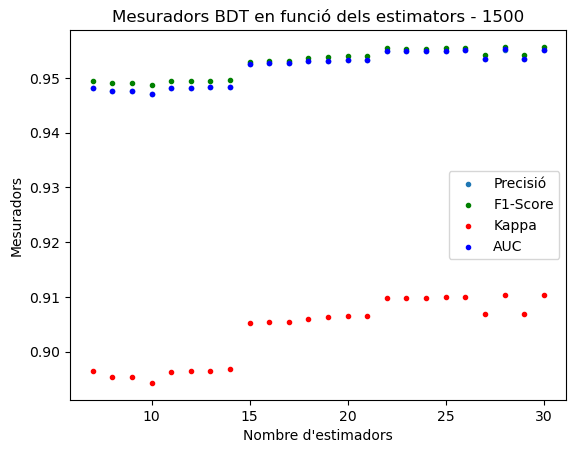

In [9]:
import matplotlib.pyplot as plt

# n_estimators2 = [2,5,11,26,59,130,300,660,1500]
# n_estimators = [2,5,11,26,59,130,300,660,1500]
# rango = range(len(n_estimators))

fig, ax = plt.subplots()
ax.scatter(n_estimators, acc, marker='.', label='Precisió')
ax.scatter(n_estimators, F1S, label='F1-Score', marker='.', color='g')
ax.scatter(n_estimators, kappa, label='Kappa', marker='.', color='r')
ax.scatter(n_estimators, AUC, label='AUC', marker='.', color='b')
ax.legend()
ax.set_xlabel("Nombre d'estimadors")
# ax.set_xscale("log")
ax.set_ylabel('Mesuradors')
ax.set_title('Mesuradors BDT en funció dels estimators - ' + str(massa))
nom = "C:/Users/alexp/OneDrive/Universitat/5. Quint/TFG/RstudioPython/Figures/SetenaSessio/BDTmesuradorsZOOM_" + str(massa)
plt.savefig(nom)
plt.show()

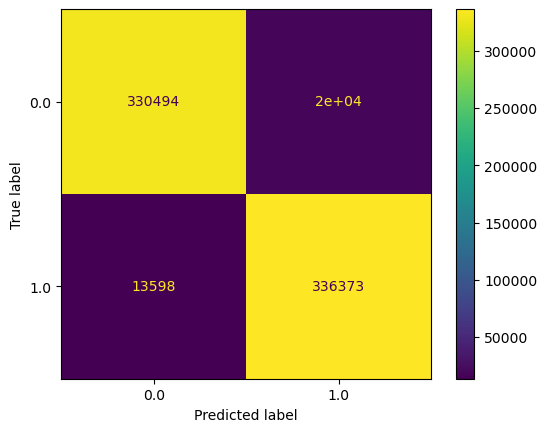

In [11]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Ydata = np.array(tre.iloc[:,0])
# Xdata = tre.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
# Ytst = np.array(tste.iloc[:,0])
# Xtst = tste.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
# massa = 1500

# bdt = ensemble.AdaBoostClassifier(n_estimators = 15)
# bdt = bdt.fit(Xdata, Ydata)
# Ypred = bdt.predict(Xtst)

cm = confusion_matrix(Ytst, Ypred, labels=bdt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=bdt.classes_)
disp.plot()
nom = "C:/Users/alexp/OneDrive/Universitat/5. Quint/TFG/RstudioPython/Figures/SetenaSessio/ConfussionMatrix"
plt.savefig(nom)
plt.show()

In [13]:
accuracyProva = (330494+336373)/(330494+336373+20000+13598)
accuracyNostra = bdt.score(Xtst, Ytst)
print(accuracyProva,accuracyNostra)

0.9520347197932801 0.9525963785547359


In [ ]:
import matplotlib.pyplot as plt
rango2 = [0,1,2,3,4,5]
n_estimators2 = [5,10,50,100,200,1000]
acc2 = [0.948211, 0.947145, 0.955966, 0.956172, 0.956459, 0.956600]
# kappa = [0.896423, 0.894292, 0.911933, 0.912344, 0.912918, 0.913201]
# F1S = [0.949388, 0.948703, 0.956385, 0.956613, 0.956906, 0.957038]
# AUC = [0.948215, 0.947150, 0.955968, 0.956173, 0.956461, 0.956602]

fig, ax = plt.subplots()
ax.scatter(rango, acc, marker='.', label='Precisió')

# ax.scatter(rango, F1S, label='F1-Score', marker='.', color='g')
# ax.scatter(rango, kappa, label='Kappa', marker='.', color='r')
# ax.scatter(rango, AUC, label='Kappa', marker='.', color='b')
ax.legend()
ax.set_xlabel("Nombre d'estimadors")
ax.set_xticks(rango,labels=n_estimators)
ax.set_ylabel('Mesuradors')
ax.set_title('4. Mesuradors BDT en funció dels estimators - 1500')
plt.savefig("D:/OneDrive/Universitat/5. Quint/TFG/RstudioPython/Figures/mesuradors_estimators.png")
plt.show()

Plotem ara amb la nova selecció d'n_estimators en escala logarítmica per veure la tendència?

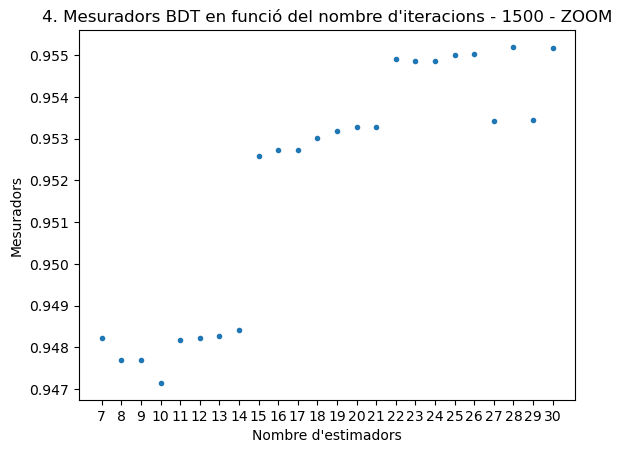

In [15]:
n_estimators = [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
ACC = [0.948211, 0.947692, 0.947692, 0.947145, 0.948175, 0.948214, 0.948268, 0.948405, 0.952596, 0.952742, 0.952735, 0.953023, 0.953188, 0.953291, 0.953285, 0.954912, 0.954866, 0.954866, 0.955002, 0.955029, 0.953435, 0.955203, 0.953453, 0.955175]
rango = range(len(n_estimators))

fig, ax = plt.subplots()
ax.scatter(rango, ACC, marker='.', label='Precisió')
ax.set_xlabel("Nombre d'estimadors")
ax.set_xticks(rango,labels=n_estimators)
ax.set_ylabel('Mesuradors')
ax.set_title("4. Mesuradors BDT en funció del nombre d'iteracions - 1500 - ZOOM")
plt.savefig("D:/OneDrive/Universitat/5. Quint/TFG/RstudioPython/Figures/QuintaSessio/mesuradors_zoom.png")
plt.show()

## Addenda: representació en matriu de la precisió en funció de iteradors i profunditat

In [13]:
Acc = [[0.746733, 0.804209, 0.805022, 0.802126, 0.815855],
[0.815749, 0.815020, 0.820982, 0.819378, 0.821655],
[0.816600, 0.821520, 0.822949, 0.825261, 0.825296],
[0.826828, 0.826796, 0.828219, 0.828477, 0.828966],
[0.833529, 0.832674, 0.833864, 0.835427, 0.834562],
[0.838892, 0.839956, 0.840569, 0.840434, 0.840481]]

prova = np.zeros((2,2))
prova[0,1] = 1
print(prova)
# print(Acc[1][0])
# plt.imshow(acc)
# plt.colorbar()
# plt.show()

[[0. 1.]
 [0. 0.]]


In [ ]:
import plotly.express as px
acc750 = [[0.806242, 0.811297, 0.802388, 0.805898, 0.805225],
[0.819260, 0.817795, 0.820495, 0.820773, 0.821286],
[0.817875, 0.826796, 0.823960, 0.824153, 0.825497],
[0.828237, 0.825384, 0.825609, 0.828438, 0.828440],
[0.831382, 0.834283, 0.835354, 0.834467, 0.834648],
[0.839298, 0.839645, 0.840403, 0.840531, 0.840526]]
fig = px.imshow(acc750,
                labels=dict(x="n_iteradors", y="Profunditat", color="Precisió"),
                y=['1', '2', '3', '4', '6','10'],
                x=['5', '10', '50','100','200'],
                title=("Precisió del RF-750 MeV")
               )

fig.update_xaxes(side="top")
fig.show()

Text(0.5, 0.98, "Estimadors per a RF-750 en funció de la profunditat i el nombre d'iteracions")

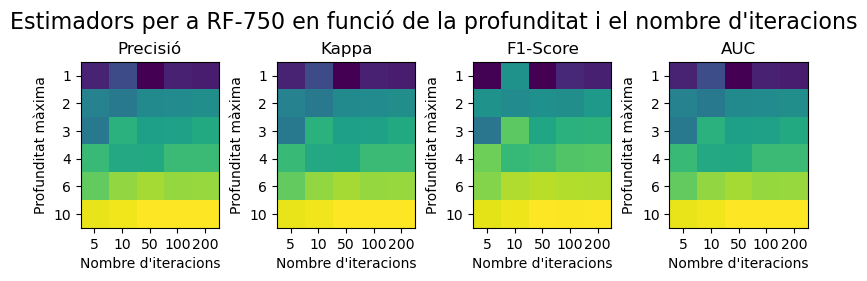

In [56]:
import plotly.express as px

max_depths = ["1","2","3","4","6","10"]
n_estimators = ["5","10","50","100","200"]

acc750 = [[0.806242, 0.811297, 0.802388, 0.805898, 0.805225],
[0.819260, 0.817795, 0.820495, 0.820773, 0.821286],
[0.817875, 0.826796, 0.823960, 0.824153, 0.825497],
[0.828237, 0.825384, 0.825609, 0.828438, 0.828440],
[0.831382, 0.834283, 0.835354, 0.834467, 0.834648],
[0.839298, 0.839645, 0.840403, 0.840531, 0.840526]]

kappa750 = [[0.612489, 0.622652, 0.604795, 0.611818, 0.610470],
[0.638549, 0.635620, 0.641015, 0.641567, 0.642599],
[0.635768, 0.653628, 0.647943, 0.648335, 0.651021],
[0.656508, 0.650798, 0.651250, 0.656904, 0.656907],
[0.662793, 0.668593, 0.670734, 0.668962, 0.669321],
[0.678616, 0.679312, 0.680829, 0.681082, 0.681074]]

F1S750 = [[0.807890, 0.827584, 0.807723, 0.812057, 0.811204],
[0.827787, 0.826542, 0.827397, 0.827081, 0.828741],
[0.823109, 0.836897, 0.830654, 0.832632, 0.832919],
[0.838241, 0.833856, 0.834725, 0.836224, 0.836509],
[0.839585, 0.842177, 0.842749, 0.842286, 0.842218],
[0.845229, 0.845776, 0.846798, 0.846587, 0.846675]]

AUC750 = [[0.806249, 0.811375, 0.802411, 0.805926, 0.805251],
[0.819301, 0.817837, 0.820529, 0.820803, 0.821323],
[0.817900, 0.826848, 0.823993, 0.824195, 0.825534],
[0.828288, 0.825427, 0.825655, 0.828478, 0.828481],
[0.831425, 0.834324, 0.835393, 0.834509, 0.834688],
[0.839330, 0.839679, 0.840438, 0.840564, 0.840560]]

fig, (ax1, ax2,ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(8,3))
fig.tight_layout()

ax1.set_title('Precisió')
ax1.imshow(acc750)
ax1.set_yticks([0,1,2,3,4,5],labels=max_depths)
ax1.set_xticks([0,1,2,3,4],labels=n_estimators)
ax1.set_xlabel("Nombre d'iteracions")
ax1.set_ylabel("Profunditat màxima")

ax2.set_title('Kappa')
ax2.imshow(kappa750)
ax2.set_yticks([0,1,2,3,4,5],labels=max_depths)
ax2.set_xticks([0,1,2,3,4],labels=n_estimators)
ax2.set_xlabel("Nombre d'iteracions")
ax2.set_ylabel("Profunditat màxima")

ax3.set_title('F1-Score')
ax3.imshow(F1S750)
ax3.set_yticks([0,1,2,3,4,5],labels=max_depths)
ax3.set_xticks([0,1,2,3,4],labels=n_estimators)
ax3.set_xlabel("Nombre d'iteracions")
ax3.set_ylabel("Profunditat màxima")

ax4.set_title('AUC')
ax4.imshow(AUC750)
ax4.set_yticks([0,1,2,3,4,5],labels=max_depths)
ax4.set_xticks([0,1,2,3,4],labels=n_estimators)
ax4.set_xlabel("Nombre d'iteracions")
ax4.set_ylabel("Profunditat màxima")



fig.suptitle("Estimadors per a RF-750 en funció de la profunditat i el nombre d'iteracions", fontsize=16)




# **Quinta sessió**

## -1. Reinstal·lació en nou ordinador

In [ ]:
# pip install pandas

In [ ]:
miltr = pd.read_csv(r"C:\Usuarios\alexp\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\1000_train.csv")

## 0. Càrrega de dades

In [65]:
# Data Processing
import pandas as pd
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import time

# Data Filing
import pickle
import os

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn import ensemble

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
# import graphviz

# miltr = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\1000_train.csv")
# miltst = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\1000_test.csv")
# alltr = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\all_train.csv")
# alltst = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\all_test.csv")

# Versió nou PC
miltr = pd.read_csv(r"C:\Users\alexp\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\1000_train.csv")
miltst = pd.read_csv(r"C:\Users\alexp\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\1000_test.csv")
alltr = pd.read_csv(r"C:\Users\alexp\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\all_train.csv")
alltst = pd.read_csv(r"C:\Users\alexp\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\all_test.csv")


# Per poder emetre un so quan acaba d'executar una cel·la
from IPython.display import Audio
sound_file = "C:/Users/alexp/Downloads/beep.wav"
# Audio(sound_file, autoplay=True)

# Renomenació de columnes
alltr.columns = ["Signal","l_pt","l_eta","l_phi","MET","M_phi","njets","pt1","eta1","phi1","b1","pt2","eta2","phi2","b2",
                 "pt3","eta3","phi3","b3","pt4","eta4","phi4","b4","m_jj","m_jjj","m_lv","m_jlv","m_wwbb","mass"]
alltst.columns = ["Signal","l_pt","l_eta","l_phi","MET","M_phi","njets","pt1","eta1","phi1","b1","pt2","eta2","phi2","b2",
                 "pt3","eta3","phi3","b3","pt4","eta4","phi4","b4","m_jj","m_jjj","m_lv","m_jlv","m_wwbb","mass"]

# Separació en masses
tra = alltr[alltr["mass"] <= 500]
trb = alltr[alltr["mass"] == 750]
trc = alltr[alltr["mass"] == 1000]
trd = alltr[alltr["mass"] == 1250]
tre = alltr[alltr["mass"] == 1500]

tsta = alltst[alltst["mass"] <= 500]
tstb = alltst[alltst["mass"] == 750]
tstc = alltst[alltst["mass"] == 1000]
tstd = alltst[alltst["mass"] == 1250]
tste = alltst[alltst["mass"] == 1500]

# ~ 5 minuts --- En PC de taula, 
# Audio(sound_file, autoplay=True)

## 1. Discontinuitat BDT

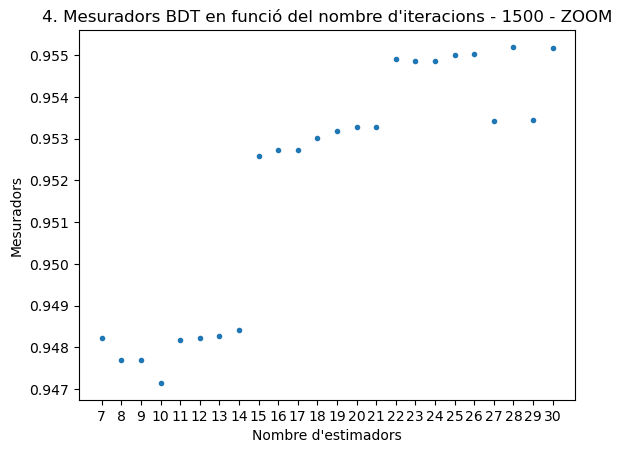

In [16]:
n_estimators = [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
ACC = [0.948211, 0.947692, 0.947692, 0.947145, 0.948175, 0.948214, 0.948268, 0.948405, 0.952596, 0.952742, 0.952735, 0.953023, 0.953188, 0.953291, 0.953285, 0.954912, 0.954866, 0.954866, 0.955002, 0.955029, 0.953435, 0.955203, 0.953453, 0.955175]
rango = range(len(n_estimators))

fig, ax = plt.subplots()
ax.scatter(rango, ACC, marker='.', label='Precisió')
ax.set_xlabel("Nombre d'estimadors")
ax.set_xticks(rango,labels=n_estimators)
ax.set_ylabel('Mesuradors')
ax.set_title("4. Mesuradors BDT en funció del nombre d'iteracions - 1500 - ZOOM")
plt.savefig("D:/OneDrive/Universitat/5. Quint/TFG/RstudioPython/Figures/QuintaSessio/mesuradors_zoom.png")
plt.show()

## 2. Més comprovacions en masssa 500

## 3. Recàlcul de la massa invariant - repetim 3.1

We will consider the following initial premises:
1) The column variables are ordered as follows: ["l_pt","l_eta","l_phi","MET","M_phi","njets","pt1","eta1","phi1","b1","pt2","eta2","phi2","b2",
                 "pt3","eta3","phi3","b3","pt4","eta4","phi4","b4","m_jj","m_jjj","m_lv","m_jlv","m_wwbb"]
2) We will only use those events where at least two of the selected four are btagged.
3) We will only use those events where there are only 4 jets so they most resemble (feynman_xtt).
4) We will calculate m_jj considering the not b-tagged jets.
5) Eta is calculated from pseudorapidity by 2*arctan((exp(-eta)).
6) Energy of the jet ~ pt (mass is negligible) --> m_jj = 2·pt1·pt2·(1 - sin(phi1)·sin(phi2)·cos(theta1-theta2) - cos(phi1)cos(phi2).

We load the datasets generated with mass 1000 and we rename the columns.

In [ ]:
nonorm1 = pd.DataFrame(np.loadtxt("D:/OneDrive/Universitat/5. Quint/TFG/RstudioPython/Dades/NoNormalTrue/xttbar_m1000_aug17.txt"))
nonorm2 = pd.DataFrame(np.loadtxt("D:/OneDrive/Universitat/5. Quint/TFG/RstudioPython/Dades/NoNormalTrue/xttbar_m1000_aug4.txt"))
nonorm = pd.concat([nonorm1,nonorm2])
del(nonorm1,nonorm2)
nonorm.columns = ["l_pt","l_eta","l_phi","MET","M_phi","njets","pt1","eta1","phi1","b1","pt2","eta2","phi2","b2",
                 "pt3","eta3","phi3","b3","pt4","eta4","phi4","b4","m_jj","m_jjj","m_lv","m_jlv","m_wwbb"]
nonorm.insert(0,"btotal",pd.DataFrame(np.zeros(len(nonorm))),True)
nonorm.iloc[:,0] = (nonorm.iloc[:,10]+nonorm.iloc[:,14]+nonorm.iloc[:,18]+nonorm.iloc[:,22])
nonorm.to_csv("nonorm1000.csv", sep=',', index=False)
print(nonorm)

As steps took increasingly more computation time, I sometimes saved the datasets to reload them another day.

In [ ]:
# nonorm.to_csv("nonorm1000.csv", sep=',', index=False)
# nonorm = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\nonorm.csv")

We select only those events where at least two of the events are btagged and njets = 4.

In [19]:
someTr = nonorm[nonorm["btotal"] == 2]
someTr = someTr[someTr["njets"] == 4]
n_esdev = len(someTr)

Now we select only the cinematic information of the non-btagged jets. 

In [31]:
vectors = pd.DataFrame(np.zeros([n_esdev,6]))

for i in range(n_esdev):
    if someTr.iloc[i,10]:
        if someTr.iloc[i,14]:
            vectors.iloc[i,[0,1,2,3,4,5]] = someTr.iloc[i,[15,16,17,19,20,21]]
        elif someTr.iloc[i,18]:
            vectors.iloc[i,[0,1,2,3,4,5]] = someTr.iloc[i,[11,12,13,19,20,21]]
        elif someTr.iloc[i,22]:
            vectors.iloc[i,[0,1,2,3,4,5]] = someTr.iloc[i,[11,12,13,15,16,17]]
    elif someTr.iloc[i,14]:
        if someTr.iloc[i,18]:
            vectors.iloc[i,[0,1,2,3,4,5]] = someTr.iloc[i,[7,8,9,19,20,21]]
        if someTr.iloc[i,22]:
            vectors.iloc[i,[0,1,2,3,4,5]] = someTr.iloc[i,[7,8,9,15,16,17]]
    else:
        vectors.iloc[i,[0,1,2,3,4,5]] = someTr.iloc[i,[7,8,9,11,12,13]]
        
vectors.columns = ["p1","eta1","phi1","p2","eta2","phi2"]

Now we transform pseudorapidity back into eta, rename columns and save into a file.

In [32]:
vectors.loc[:,["eta1","eta2"]] = 2*(((-1*vectors.loc[:,["eta1","eta2"]]).apply(np.exp)).apply(np.arctan))
vectors.columns = ["p1","theta1","phi1","p2","theta2","phi2"]
# vectors.to_csv("jets4nob.csv", sep=',', index=False)

We calculate m_jj considering E_j ~ |pt| so m_jj = 2·pt1·pt2·(1 - sin(phi1)·sin(phi2)·cos(theta1-theta2) - cos(phi1)cos(phi2).

In [33]:
m_jj = pd.DataFrame(np.zeros([len(vectors),0]))
m_jj = 1 - ( vectors.loc[:,"phi1"].apply(np.sin) * vectors.loc[:,"phi2"].apply(np.sin) * (vectors.loc[:,"theta1"] - vectors.loc[:,"theta2"]).apply(np.cos) )
m_jj = m_jj - ( vectors.loc[:,"phi1"].apply(np.cos) * vectors.loc[:,"phi2"].apply(np.cos) )
m_jj = np.sqrt( 2 * vectors.loc[:,"p1"] * vectors.loc[:,"p2"] * m_jj )

We plot m_jj from the dataset alongside our calculated m_jj.

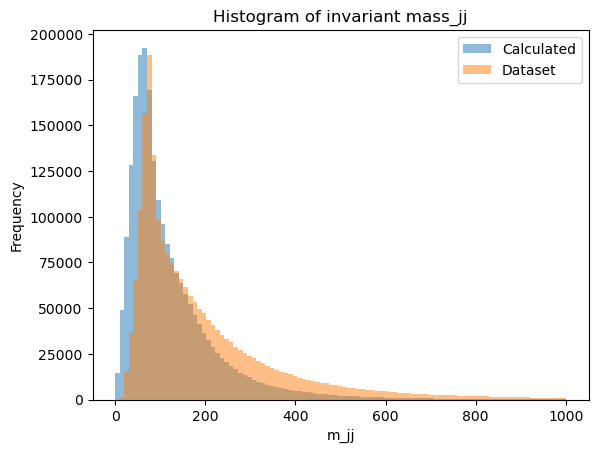

In [34]:
bins1 = np.linspace(0, 1000, 100)
bins2 = np.linspace(0, 1000, 100)

# nonorm = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\nonorm1000.csv")
someTr = nonorm[nonorm["btotal"] == 2]
someTr = someTr[someTr["njets"] == 4]

plt.hist(m_jj, bins1, alpha=0.5, label='Calculated')
plt.hist(someTr[someTr["btotal"] == 2].loc[:,"m_jj"], bins2, alpha=0.5, label='Dataset')
plt.legend(loc='upper right')
plt.xlabel('m_jj')
plt.ylabel('Frequency')
plt.title('Histogram of invariant mass_jj')
plt.savefig("D:/OneDrive/Universitat/5. Quint/TFG/RstudioPython/Figures/InvariantMass.png")
plt.show()

## 4. Nous PLOTS MEMÒRIA

<Axes: >

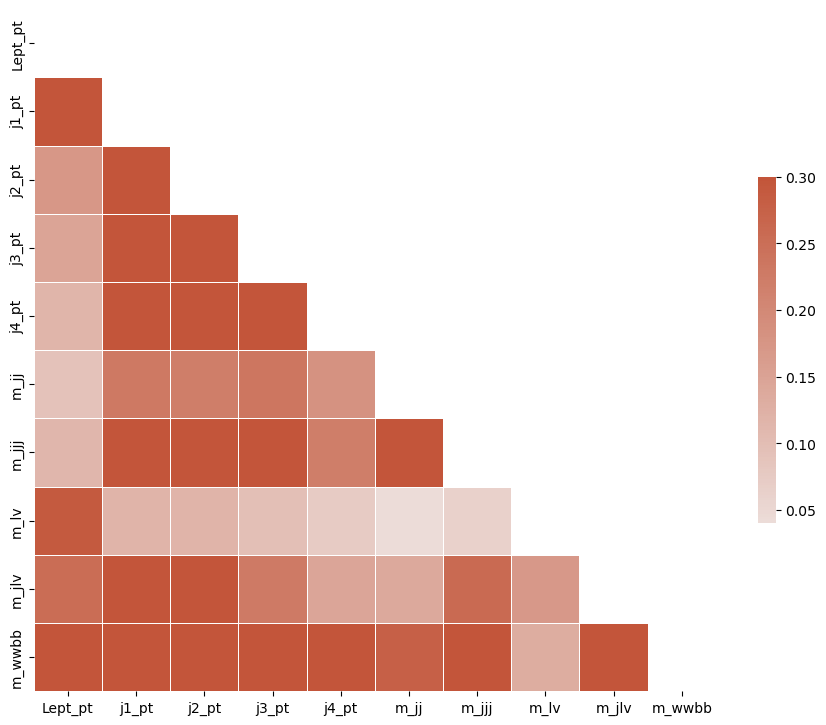

In [34]:
# from string import ascii_letters
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt


# df = pd.DataFrame(milTrBack)
df = (pd.DataFrame(Tr1000Signal))
df = df.drop(['mass'], axis=1)
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [15]:
Ydata = np.array(tre.iloc[:,0])
Xdata = tre.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
Ytst = np.array(tste.iloc[:,0])
Xtst = tste.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]

bdt = ensemble.AdaBoostClassifier(n_estimators = 15)
bdt = bdt.fit(Xdata, Ydata)

Ypred = bdt.predict(Xdata)
accDATA = bdt.score(Xdata, Ydata)
accTST = bdt.score(Xtst, Ytst)
print(accDATA,accTST)
print(accDATA-accTST)

0.9525229951001897 0.9525963785547359
-7.338345454621642e-05


In [12]:
print(accDATA,accTST)

0.947180930035166 0.9471453549164919


In [13]:
print(accDATA-accTST)

3.5575118674135986e-05


In [35]:
TN = 330494
TP = 336373
FN = 13598
FP = 20000
total = TP+TN+FP+FN
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F1SCORE = (2*precision*recall)/(precision+recall)
print(F1SCORE)

OA = (TP+TN)/total
AC = ((TP+FP)*(TP+FN))/(total*total) + ((FP+TN)*(FN+TN))/(total*total)
KAPPA = (OA-AC)/(1-AC)
print(KAPPA)

0.952433941535569
0.9040706953673551


Plotem trees

In [24]:
print(Xdata.columns)

Index(['pt1', 'pt2', 'l_pt', 'm_jlv', 'm_wwbb', 'MET'], dtype='object')


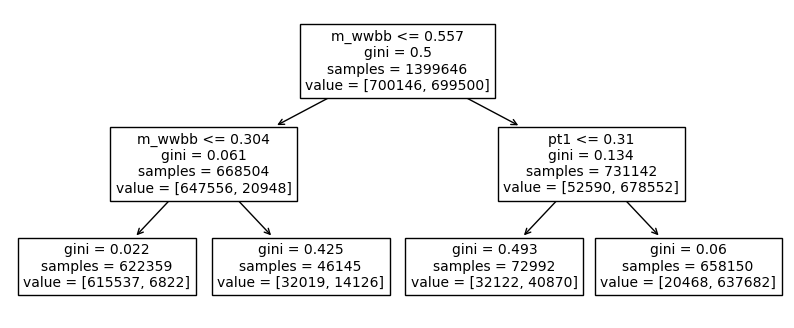

In [30]:
# # from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Ydata = np.array(tre.iloc[:,0])
# Xdata = tre.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
# Ytst = np.array(tste.iloc[:,0])
# Xtst = tste.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
# massa = 1500
columnes = ["pt1","pt2","l_pt","m_jlv","m_wwbb"]
dt = tree.DecisionTreeClassifier(max_depth = 2)
dt = dt.fit(Xdata, Ydata)

plt.figure(figsize=(10,4))
tree.plot_tree(dt,max_depth = 2, fontsize = 10, feature_names = columnes);
directory = "C:/Users/alexp/OneDrive/Universitat/5. Quint/TFG/RstudioPython/Figures/SetenaSessio/TreePlot"
intent = "1"
extensio = ".png"
plt.savefig(directory+intent+extensio);
plt.show()

## 5. I si ajustem les accuracy???

### Decision Trees

In [3]:
def DecisionTreer(Xdata,Xtst,Ydata,Ytst,massa,label):
    max_depths = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,30,35,40,50,60,70,80,90,100]
    longitud = len(max_depths)
    acc, kappa, F1S, AUC = np.zeros(longitud),np.zeros(longitud),np.zeros(longitud),np.zeros(longitud)
    startTime = time.time()
    for i in range(longitud):
        clf = tree.DecisionTreeClassifier(max_depth = max_depths[i])
        clf = clf.fit(Xdata, Ydata)


    # -------------------------------------------------------
    # Part 3: Avaluació DT
        Ypred = clf.predict(Xtst)
        acc[i] = clf.score(Xtst, Ytst)
        kappa[i] = metrics.cohen_kappa_score(Ypred, Ytst)
        F1S[i] = metrics.f1_score(Ytst, Ypred)
        AUC[i] = metrics.roc_auc_score(Ytst, Ypred)

    print("DTs amb massa %i i selecció de variables %s.\n Precisió: %f ± %f. Kappa: %f ± %f. F1-Score: %f ± %f. AUC: %f ± %f.\n" 
          %(massa, label, np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S), np.mean(AUC), np.std(AUC)))


    with open("Output.txt", "a") as text_file:
        text_file.write("DTs amb massa %i i selecció de variables %s.\n Precisió: %f ± %f  Kappa: %f ± %f  F1-Score: %f ± %f  AUC: %f ± %f \n" 
          %(massa, label, np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S), np.mean(AUC), np.std(AUC)))
        accString = (pd.DataFrame(acc)).to_string(header=False, index=False)
        kappaString = (pd.DataFrame(kappa)).to_string(header=False, index=False)
        F1SString = (pd.DataFrame(F1S)).to_string(header=False, index=False)
        AUCString = (pd.DataFrame(AUC)).to_string(header=False, index=False)
        text_file.write("Acc = " + accString + "\nKappa = " + kappaString + "\nF1-Score = " + F1SString + "\nAUC = " + AUCString)

    return acc,kappa,F1S,AUC

In [4]:
Ydata = np.array(tre.iloc[:,0])
Xdata = tre.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
Ytst = np.array(tste.iloc[:,0])
Xtst = tste.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
massa = 1500
label = "A"
acc,kappa,F1S,AUC = DecisionTreer(Xdata,Xtst,Ydata,Ytst,massa,label)

DTs amb massa 1500 i selecció de variables A.
 Precisió: 0.948222 ± 0.008186. Kappa: 0.896445 ± 0.016372. F1-Score: 0.948426 ± 0.008324. AUC: 0.948223 ± 0.008187.



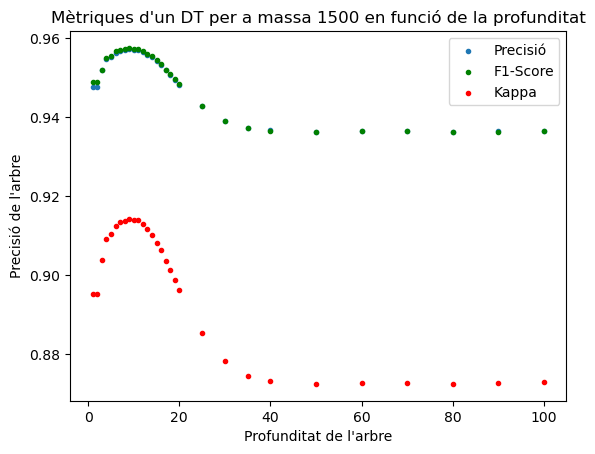

In [11]:
depths = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,30,35,40,50,60,70,80,90,100]
fig, ax = plt.subplots()
ax.scatter(depths, acc, marker='.', label='Precisió')
ax.scatter(depths, F1S, label='F1-Score', marker='.', color='g')
ax.scatter(depths, kappa, label='Kappa', marker='.', color='r')
ax.legend()
ax.set_xlabel("Profunditat de l'arbre")
ax.set_ylabel("Precisió de l'arbre")
ax.set_title("Mètriques d'un DT per a massa 1500 en funció de la profunditat")
plt.savefig("C:/Users/alexp/OneDrive/Universitat/5. Quint/TFG/RstudioPython/Figures/SetenaSessio/precisio1500.png")
plt.show()

## RFs

#### Primer en funció del nombre d'estimadors

In [16]:
# PLOTEM ARA PER A BDT EN FUNCIÓ DE LES ITERACIONS. CALCULEM UN EXEMPLE. PRIMER DEFINIM LA FUNCIÓ.
def RandomForester(Xdata,Ydata,Xtst,Ytst,label,massa):
    max_depth = 5
    n_estimators = [1,2,3,4,5,10,15,20,25,30,35,40,45,50,60,70,80,90,100,150,200,300,400]
    longitud = len(n_estimators)
    acc, kappa, F1S, AUC = np.zeros(longitud),np.zeros(longitud),np.zeros(longitud),np.zeros(longitud)

    startTime = time.time()
    
    # -------------------------------------------------------
    # Part 2: Càlcul DT

    for i in range(longitud):
        bdt = ensemble.RandomForestClassifier(n_estimators = n_estimators[i], max_depth=max_depth)
        bdt = bdt.fit(Xdata, Ydata)


    # -------------------------------------------------------
    # Part 3: Avaluació DT
        Ypred = bdt.predict(Xtst)
        acc[i] = bdt.score(Xtst, Ytst)
        kappa[i] = metrics.cohen_kappa_score(Ypred,Ytst)
        F1S[i] = metrics.f1_score(Ytst,Ypred)
        AUC[i] = metrics.roc_auc_score(Ytst, Ypred)
        print("Estimators %i DONE" % (n_estimators[i]))

    print("Temps total: " + str(time.time()-startTime) + "\n")    
    print("RFs amb massa %i i selecció de variables %s.\n Precisió: %f ± %f. Kappa: %f ± %f. F1-Score: %f ± %f. AUC: %f ± %f.\n" 
          %(massa, label, np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S), np.mean(AUC), np.std(AUC)))


    with open("Output.txt", "a") as text_file:
        text_file.write("RFs amb massa %i i selecció de variables %s.\n Precisió: %f ± %f  Kappa: %f ± %f  F1-Score: %f ± %f  AUC: %f ± %f \n" 
          %(massa, label, np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S), np.mean(AUC), np.std(AUC)))
        accString = (pd.DataFrame(acc)).to_string(header=False, index=False)
        kappaString = (pd.DataFrame(kappa)).to_string(header=False, index=False)
        F1SString = (pd.DataFrame(F1S)).to_string(header=False, index=False)
        AUCString = (pd.DataFrame(AUC)).to_string(header=False, index=False)
        text_file.write("Acc = " + accString + "\nKappa = " + kappaString + "\nF1-Score = " + F1SString + "\nAUC = " + AUCString)
        
    return acc,kappa,F1S,AUC

In [17]:
# I després avaluem per als datasets i massa 1500
n_estimators = [1,2,3,4,5,10,15,20,25,30,35,40,45,50,60,70,80,90,100,150,200,300,400]
Ydata = np.array(tre.iloc[:,0])
Xdata = tre.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
Ytst = np.array(tste.iloc[:,0])
Xtst = tste.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
massa = 1500
label = "C"
acc,kappa,F1S,AUC = RandomForester(Xdata,Ydata,Xtst,Ytst,label,massa)

Estimators 1 DONE
Estimators 2 DONE
Estimators 3 DONE
Estimators 4 DONE
Estimators 5 DONE
Estimators 10 DONE
Estimators 15 DONE
Estimators 20 DONE
Estimators 25 DONE
Estimators 30 DONE
Estimators 35 DONE
Estimators 40 DONE
Estimators 45 DONE
Estimators 50 DONE
Estimators 60 DONE
Estimators 70 DONE
Estimators 80 DONE
Estimators 90 DONE
Estimators 100 DONE
Estimators 150 DONE
Estimators 200 DONE
Estimators 300 DONE
Estimators 400 DONE
Temps total: 5018.226261138916

RFs amb massa 1500 i selecció de variables C.
 Precisió: 0.956350 ± 0.001180. Kappa: 0.912700 ± 0.002360. F1-Score: 0.956658 ± 0.001269. AUC: 0.956351 ± 0.001180.



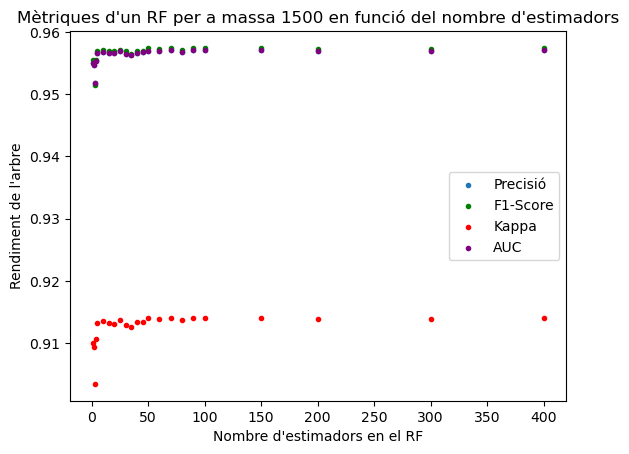

In [19]:
fig, ax = plt.subplots()
n_estimators = [1,2,3,4,5,10,15,20,25,30,35,40,45,50,60,70,80,90,100,150,200,300,400]
ax.scatter(n_estimators, acc, marker='.', label='Precisió')
ax.scatter(n_estimators, F1S, label='F1-Score', marker='.', color='g')
ax.scatter(n_estimators, kappa, label='Kappa', marker='.', color='r')
ax.scatter(n_estimators, AUC, label='AUC', marker='.', color='purple')
ax.legend()
ax.set_xlabel("Nombre d'estimadors en el RF")
ax.set_ylabel("Rendiment de l'arbre")
ax.set_title("Mètriques d'un RF per a massa 1500 en funció del nombre d'estimadors")
plt.savefig("C:/Users/alexp/OneDrive/Universitat/5. Quint/TFG/RstudioPython/Figures/SetenaSessio/precisioRF1500_depth.png")
plt.show()

#### Ara en funció de la profunditat

In [66]:
def RandomForester(Xdata,Ydata,Xtst,Ytst,label,massa):
    max_depth = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,24,26,28,30,35,40,45,50]
    n_estimators = 15
    longitud = len(max_depth)
    acc, kappa, F1S, AUC = np.zeros(longitud),np.zeros(longitud),np.zeros(longitud),np.zeros(longitud)

    startTime = time.time()
    
    # -------------------------------------------------------
    # Part 2: Càlcul DT

    for i in range(longitud):
        bdt = ensemble.RandomForestClassifier(n_estimators = n_estimators, max_depth=max_depth[i])
        bdt = bdt.fit(Xdata, Ydata)


    # -------------------------------------------------------
    # Part 3: Avaluació DT
        Ypred = bdt.predict(Xtst)
        acc[i] = bdt.score(Xtst, Ytst)
        kappa[i] = metrics.cohen_kappa_score(Ypred,Ytst)
        F1S[i] = metrics.f1_score(Ytst,Ypred)
        AUC[i] = metrics.roc_auc_score(Ytst, Ypred)
        print("Depth %i DONE" % (max_depth[i]))

    print("Temps total: " + str(time.time()-startTime) + "\n")    
    print("RFs amb massa %i i selecció de variables %s.\n Precisió: %f ± %f. Kappa: %f ± %f. F1-Score: %f ± %f. AUC: %f ± %f.\n" 
          %(massa, label, np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S), np.mean(AUC), np.std(AUC)))


    with open("Output.txt", "a") as text_file:
        text_file.write("RFs amb massa %i i selecció de variables %s.\n Precisió: %f ± %f  Kappa: %f ± %f  F1-Score: %f ± %f  AUC: %f ± %f \n" 
          %(massa, label, np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S), np.mean(AUC), np.std(AUC)))
        accString = (pd.DataFrame(acc)).to_string(header=False, index=False)
        kappaString = (pd.DataFrame(kappa)).to_string(header=False, index=False)
        F1SString = (pd.DataFrame(F1S)).to_string(header=False, index=False)
        AUCString = (pd.DataFrame(AUC)).to_string(header=False, index=False)
        text_file.write("Acc = " + accString + "\nKappa = " + kappaString + "\nF1-Score = " + F1SString + "\nAUC = " + AUCString)
        
    return acc,kappa,F1S,AUC

In [67]:
# I després avaluem per als datasets i massa 1500

Ydata = np.array(tre.iloc[:,0])
Xdata = tre.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
Ytst = np.array(tste.iloc[:,0])
Xtst = tste.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
massa = 1500
label = "C"
acc,kappa,F1S,AUC = RandomForester(Xdata,Ydata,Xtst,Ytst,label,massa)

Depth 1 DONE
Depth 2 DONE
Depth 3 DONE
Depth 4 DONE
Depth 5 DONE
Depth 6 DONE
Depth 7 DONE
Depth 8 DONE
Depth 9 DONE
Depth 10 DONE
Depth 11 DONE
Depth 12 DONE
Depth 13 DONE
Depth 14 DONE
Depth 15 DONE
Depth 16 DONE
Depth 17 DONE
Depth 18 DONE
Depth 19 DONE
Depth 20 DONE
Depth 22 DONE
Depth 24 DONE
Depth 26 DONE
Depth 28 DONE
Depth 30 DONE
Depth 35 DONE
Depth 40 DONE
Depth 45 DONE
Depth 50 DONE
Temps total: 2826.1011188030243

RFs amb massa 1500 i selecció de variables C.
 Precisió: 0.956753 ± 0.002687. Kappa: 0.913507 ± 0.005374. F1-Score: 0.957086 ± 0.002504. AUC: 0.956754 ± 0.002686.



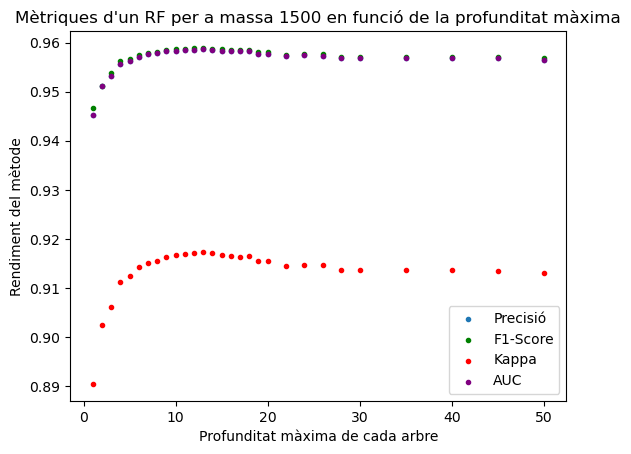

In [68]:
fig, ax = plt.subplots()
max_depth = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,24,26,28,30,35,40,45,50]
ax.scatter(max_depth, acc, marker='.', label='Precisió')
ax.scatter(max_depth, F1S, label='F1-Score', marker='.', color='g')
ax.scatter(max_depth, kappa, label='Kappa', marker='.', color='r')
ax.scatter(max_depth, AUC, label='AUC', marker='.', color='purple')
ax.legend()
ax.set_xlabel("Profunditat màxima de cada arbre")
ax.set_ylabel("Rendiment del mètode")
ax.set_title("Mètriques d'un RF per a massa 1500 en funció de la profunditat màxima")
plt.savefig("C:/Users/alexp/OneDrive/Universitat/5. Quint/TFG/RstudioPython/Figures/SetenaSessio/precisioRF1500_TrueDepth.png")
plt.show()

## BDTs

In [2]:
# PLOTEM ARA PER A BDT EN FUNCIÓ DE LES ITERACIONS. CALCULEM UN EXEMPLE. PRIMER DEFINIM LA FUNCIÓ.
def BoostedDecisioner(n_estimators,Xdata,Ydata,Xtst,Ytst,label,massa):
    # n_estimators = [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
    # n_estimators = [2,5,11,26,59,130,300,660,1500]
    longitud = len(n_estimators)
    acc, kappa, F1S, AUC = np.zeros(longitud),np.zeros(longitud),np.zeros(longitud),np.zeros(longitud)

    startTime = time.time()
    
    # -------------------------------------------------------
    # Part 2: Càlcul DT

    for i in range(longitud):
        bdt = ensemble.AdaBoostClassifier(n_estimators = n_estimators[i])
        bdt = bdt.fit(Xdata, Ydata)


    # -------------------------------------------------------
    # Part 3: Avaluació DT
        Ypred = bdt.predict(Xtst)
        acc[i] = bdt.score(Xtst, Ytst)
        kappa[i] = metrics.cohen_kappa_score(Ypred,Ytst)
        F1S[i] = metrics.f1_score(Ytst,Ypred)
        AUC[i] = metrics.roc_auc_score(Ytst, Ypred)
        print("Estimators %i DONE" % (n_estimators[i]))

    print("Temps total: " + str(time.time()-startTime) + "\n")    
    print("BDTs amb massa %i i selecció de variables %s.\n Precisió: %f ± %f. Kappa: %f ± %f. F1-Score: %f ± %f. AUC: %f ± %f.\n" 
          %(massa, label, np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S), np.mean(AUC), np.std(AUC)))


    with open("Output.txt", "a") as text_file:
        text_file.write("BDTs amb massa %i i selecció de variables %s.\n Precisió: %f ± %f  Kappa: %f ± %f  F1-Score: %f ± %f  AUC: %f ± %f \n" 
          %(massa, label, np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S), np.mean(AUC), np.std(AUC)))
        accString = (pd.DataFrame(acc)).to_string(header=False, index=False)
        kappaString = (pd.DataFrame(kappa)).to_string(header=False, index=False)
        F1SString = (pd.DataFrame(F1S)).to_string(header=False, index=False)
        AUCString = (pd.DataFrame(AUC)).to_string(header=False, index=False)
        text_file.write("Acc = " + accString + "\nKappa = " + kappaString + "\nF1-Score = " + F1SString + "\nAUC = " + AUCString)
        
    return acc,kappa,F1S,AUC

In [3]:
# I després avaluem per als datasets i massa 1500
# n_estimators = [2,5,11,26,59,130,300,660,1500]
n_estimators = [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50]
Ydata = np.array(tre.iloc[:,0])
Xdata = tre.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
Ytst = np.array(tste.iloc[:,0])
Xtst = tste.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
massa = 1500
label = "C"
acc,kappa,F1S,AUC = BoostedDecisioner(n_estimators,Xdata,Ydata,Xtst,Ytst,label,massa)

Estimators 7 DONE
Estimators 8 DONE
Estimators 9 DONE
Estimators 10 DONE
Estimators 11 DONE
Estimators 12 DONE
Estimators 13 DONE
Estimators 14 DONE
Estimators 15 DONE
Estimators 16 DONE
Estimators 17 DONE
Estimators 18 DONE
Estimators 19 DONE
Estimators 20 DONE
Estimators 21 DONE
Estimators 22 DONE
Estimators 23 DONE
Estimators 24 DONE
Estimators 25 DONE
Estimators 26 DONE
Estimators 27 DONE
Estimators 28 DONE
Estimators 29 DONE
Estimators 30 DONE
Estimators 31 DONE
Estimators 32 DONE
Estimators 33 DONE
Estimators 34 DONE
Estimators 35 DONE
Estimators 36 DONE
Estimators 37 DONE
Estimators 38 DONE
Estimators 39 DONE
Estimators 40 DONE
Estimators 41 DONE
Estimators 42 DONE
Estimators 43 DONE
Estimators 44 DONE
Estimators 45 DONE
Estimators 46 DONE
Estimators 47 DONE
Estimators 48 DONE
Estimators 49 DONE
Estimators 50 DONE
Temps total: 3102.2973833084106

BDTs amb massa 1500 i selecció de variables C.
 Precisió: 0.953497 ± 0.002802. Kappa: 0.906994 ± 0.005603. F1-Score: 0.954145 ± 0.0024

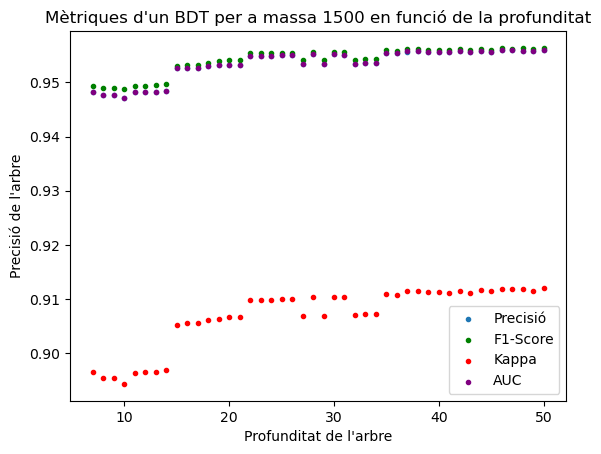

In [5]:
fig, ax = plt.subplots()
ax.scatter(n_estimators, acc, marker='.', label='Precisió')
ax.scatter(n_estimators, F1S, label='F1-Score', marker='.', color='g')
ax.scatter(n_estimators, kappa, label='Kappa', marker='.', color='r')
ax.scatter(n_estimators, AUC, label='AUC', marker='.', color='purple')
ax.legend()
ax.set_xlabel("Profunditat de l'arbre")
ax.set_ylabel("Precisió de l'arbre")
ax.set_title("Mètriques d'un BDT per a massa 1500 en funció de la profunditat")
plt.savefig("C:/Users/alexp/OneDrive/Universitat/5. Quint/TFG/RstudioPython/Figures/SetenaSessio/precisioBDT1500.png")
plt.show()

# **Recopilatori final**

## 0. Càrrega de dades

In [1]:
# Data Processing
import pandas as pd
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import time

# Data Filing
import pickle
import os

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn import ensemble

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
# import graphviz

# miltr = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\1000_train.csv")
# miltst = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\1000_test.csv")
# alltr = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\all_train.csv")
# alltst = pd.read_csv(r"D:\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\all_test.csv")

# Versió nou PC
miltr = pd.read_csv(r"C:\Users\alexp\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\1000_train.csv")
miltst = pd.read_csv(r"C:\Users\alexp\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\1000_test.csv")
alltr = pd.read_csv(r"C:\Users\alexp\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\all_train.csv")
alltst = pd.read_csv(r"C:\Users\alexp\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\all_test.csv")


# Per poder emetre un so quan acaba d'executar una cel·la
from IPython.display import Audio
sound_file = "C:/Users/alexp/Downloads/beep.wav"
# Audio(sound_file, autoplay=True)

# Renomenació de columnes
alltr.columns = ["Signal","l_pt","l_eta","l_phi","MET","M_phi","njets","pt1","eta1","phi1","b1","pt2","eta2","phi2","b2",
                 "pt3","eta3","phi3","b3","pt4","eta4","phi4","b4","m_jj","m_jjj","m_lv","m_jlv","m_wwbb","mass"]
alltst.columns = ["Signal","l_pt","l_eta","l_phi","MET","M_phi","njets","pt1","eta1","phi1","b1","pt2","eta2","phi2","b2",
                 "pt3","eta3","phi3","b3","pt4","eta4","phi4","b4","m_jj","m_jjj","m_lv","m_jlv","m_wwbb","mass"]

# Separació en masses
tra = alltr[alltr["mass"] <= 500]
trb = alltr[alltr["mass"] == 750]
trc = alltr[alltr["mass"] == 1000]
trd = alltr[alltr["mass"] == 1250]
tre = alltr[alltr["mass"] == 1500]

tsta = alltst[alltst["mass"] <= 500]
tstb = alltst[alltst["mass"] == 750]
tstc = alltst[alltst["mass"] == 1000]
tstd = alltst[alltst["mass"] == 1250]
tste = alltst[alltst["mass"] == 1500]

# ~ 5 minuts --- En PC de taula, 
# Audio(sound_file, autoplay=True)

## 1. Corba ROC

### Definim una funció que execute els càlculs adients, però afegint la representació i escollint un sol n_estimators

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay
from sklearn.datasets import load_wine
import matplotlib.pyplot as plt

In [6]:
def BoostedDecisioner(Xdata,Ydata,Xtst,Ytst):
    bdt = ensemble.AdaBoostClassifier(n_estimators = 15)
    bdt = bdt.fit(Xdata, Ydata)
    Ypred = bdt.predict(Xtst)    
    bdt.fit(Xdata, Ydata)

    ax = plt.gca()
    display = RocCurveDisplay.from_estimator(bdt, Xtst, Ytst, ax=ax, alpha=0.8, plot_chance_level=True)
    # display.plot(ax = ax, alpha = 0.8)

    plt.axis("square")
    plt.xlabel("Ratio de Falsos Positius")
    plt.ylabel("Ratio d'Autèntics Positius")
    plt.title("Exemple de corba ROC - BDT per a massa 1500")
    plt.legend()
    plt.savefig(r"C:\Users\alexp\OneDrive\Universitat\5. Quint\TFG\Memòria\Figures\ROCcurve1500.png");
    
    return bdt

### Avaluem emprant massa 1500

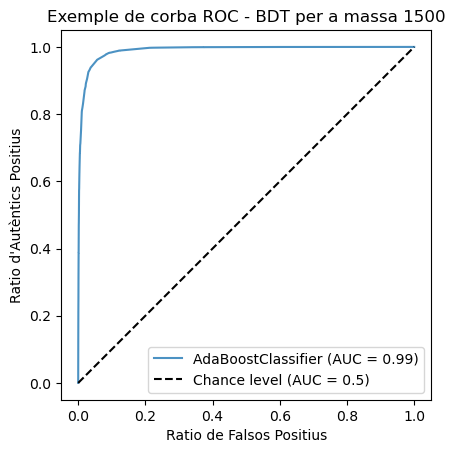

In [7]:
Ydata = np.array(tre.iloc[:,0])
Xdata = tre.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
Ytst = np.array(tste.iloc[:,0])
Xtst = tste.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]

# Ydata = np.array(tra.iloc[:,0])
# Xdata = tra.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
# Ytst = np.array(tsta.iloc[:,0])
# Xtst = tsta.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]

# Ydata = np.array(trc.iloc[:,0])
# Xdata = trc.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
# Ytst = np.array(tstc.iloc[:,0])
# Xtst = tstc.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]

bdt = BoostedDecisioner(Xdata,Ydata,Xtst,Ytst)

## 2. Recàlcul matrius correlació amb llegenda

In [1]:
import pandas as pd
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import time

# Data Filing
import pickle
import os

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn import ensemble

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
# import graphviz
miltr = pd.read_csv(r"C:\Users\alexp\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\1000_train.csv")
miltst = pd.read_csv(r"C:\Users\alexp\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\1000_test.csv")
alltr = pd.read_csv(r"C:\Users\alexp\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\all_train.csv")
alltst = pd.read_csv(r"C:\Users\alexp\OneDrive\Universitat\5. Quint\TFG\RstudioPython\Dades\Normal\all_test.csv")

In [2]:
milTrSignal = miltr.loc[miltr.index == 1]
milTrSignal = milTrSignal.loc[:,["# label","f6","f10","f14","f18","f21","f22","f23","f24","f25"]]
milTrSignal.columns = ["Lept_pt","j1_pt","j2_pt","j3_pt","j4_pt","m_jj","m_jjj","m_lv","m_jlv","m_wwbb"]

milTrBack = miltr.loc[miltr.index == 0]
milTrBack = milTrBack.loc[:,["# label","f6","f10","f14","f18","f21","f22","f23","f24","f25"]]
milTrBack.columns = ["Lept_pt","j1_pt","j2_pt","j3_pt","j4_pt","m_jj","m_jjj","m_lv","m_jlv","m_wwbb"]

allTrSignal = alltr.loc[alltr["# label"] == 1]
allTrSignal = allTrSignal.iloc[:,[1,7,11,15,19,23,24,25,26,27,28]]
allTrSignal.columns = ["Lept_pt","j1_pt","j2_pt","j3_pt","j4_pt","m_jj","m_jjj","m_lv","m_jlv","m_wwbb","mass"]

allTrBack = alltr.loc[alltr["# label"] == 0]
allTrBack = allTrBack.iloc[:,[1,7,11,15,19,23,24,25,26,27,28]]
allTrBack.columns = ["Lept_pt","j1_pt","j2_pt","j3_pt","j4_pt","m_jj","m_jjj","m_lv","m_jlv","m_wwbb","mass"]

Tr500Signal = allTrSignal.loc[allTrSignal["mass"] <= 500]
Tr750Signal = allTrSignal.loc[allTrSignal["mass"] == 750]
Tr1000Signal = allTrSignal.loc[allTrSignal["mass"] == 1000]
Tr1250Signal = allTrSignal.loc[allTrSignal["mass"] == 1250]
Tr1500Signal = allTrSignal.loc[allTrSignal["mass"] == 1500]

Text(0.5, 1.0, 'Matriu de correlació - Massa 1000 Background')

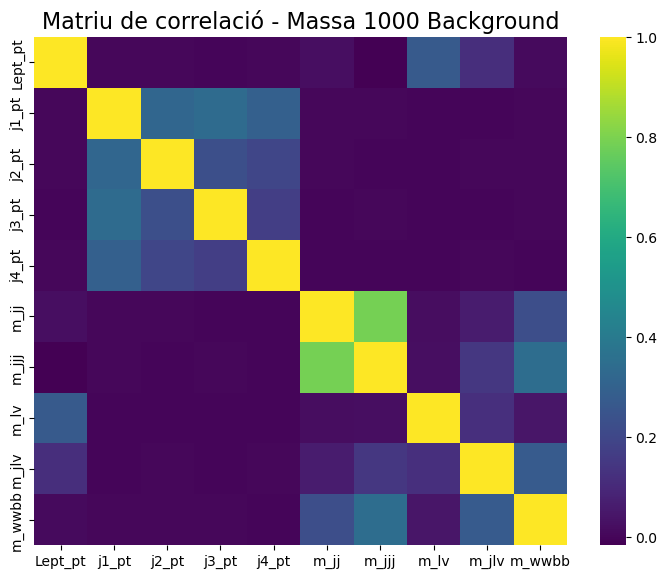

In [3]:
import seaborn as sns

dataframe = milTrSignal
dataframe = dataframe.iloc[:,0:10]

f = plt.figure(figsize=(8.6, 6.6))

sns.heatmap(dataframe.corr(), cmap="viridis")
plt.title('Matriu de correlació - Massa 1000 Background', fontsize=16)

Text(0.5, 1.0, 'Matriu de correlació - Massa 1000 Signal')

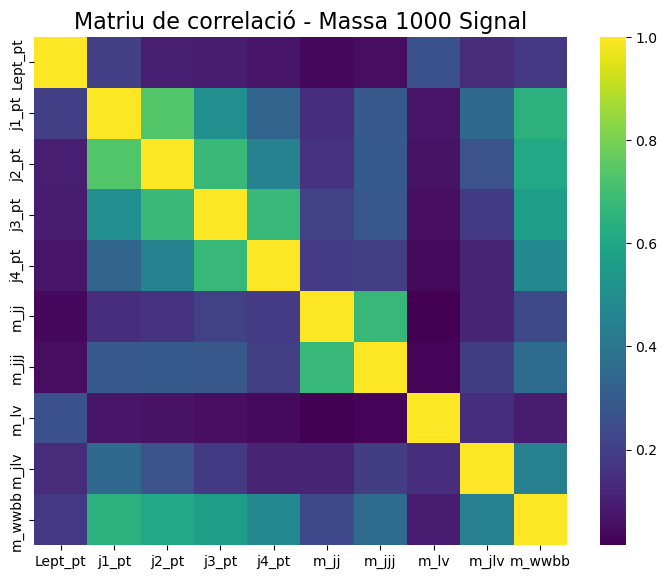

In [55]:
dataframe = milTrBack
dataframe = dataframe.iloc[:,0:10]

f = plt.figure(figsize=(8.6, 6.6))

sns.heatmap(dataframe.corr(), cmap="viridis")
plt.title('Matriu de correlació - Massa 1000 Signal', fontsize=16)

In [60]:
def CorrPloter(dataframe, massa, signal):
    f = plt.figure(figsize=(5, 4))
    sns.heatmap(dataframe.corr(), cmap="viridis")
    if signal:
        addenda = " Signal"
    else:
        addenda = " Background"
    plt.title('Matriu de correlació - Massa ' + str(massa) + addenda, fontsize=16)

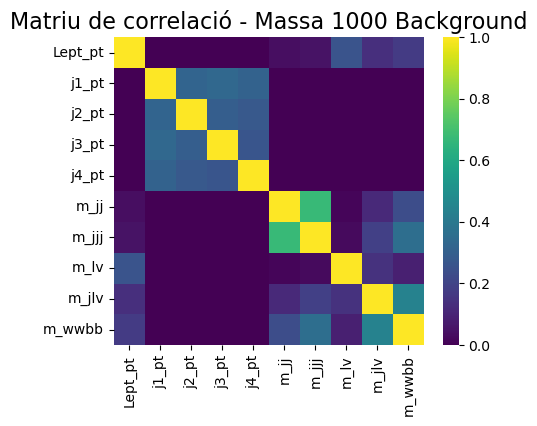

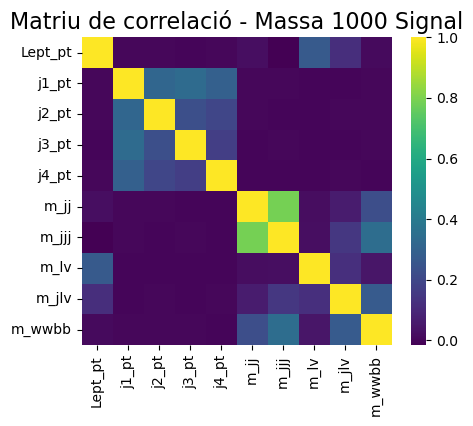

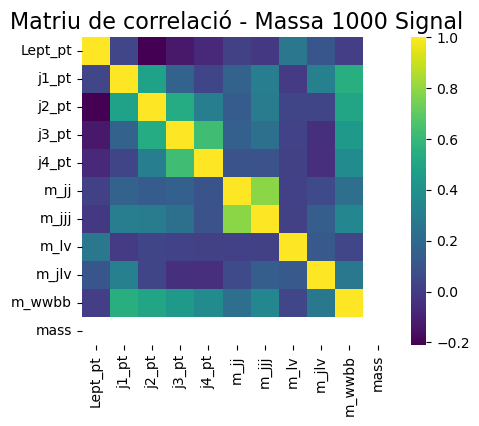

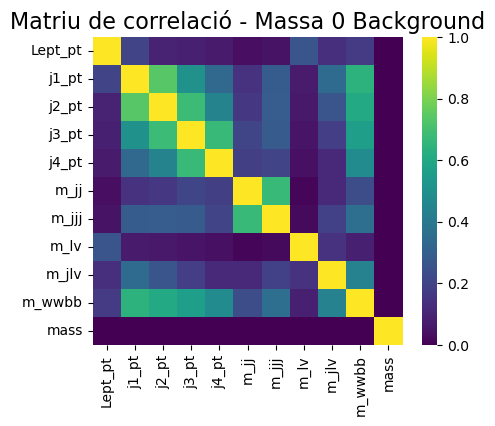

In [62]:
CorrPloter(milTrBack, 1000, 0)
CorrPloter(milTrSignal, 1000, 1)
CorrPloter(Tr1000Signal.iloc[:,0:10], 1000, 1)
CorrPloter(allTrBack.iloc[:,0:10], 0, 0)

## 3. Plots apartat 3.2

### RFs

#### En funció del n estimators

In [ ]:
# PLOTEM ARA PER A BDT EN FUNCIÓ DE LES ITERACIONS. CALCULEM UN EXEMPLE. PRIMER DEFINIM LA FUNCIÓ.
def RandomForester(Xdata,Ydata,Xtst,Ytst,label,massa):
    max_depth = 5
    n_estimators = [1,2,3,4,5,10,15,20,25,30,35,40,45,50,60,70,80,90,100,150,200,300,400]
    longitud = len(n_estimators)
    acc, kappa, F1S, AUC = np.zeros(longitud),np.zeros(longitud),np.zeros(longitud),np.zeros(longitud)

    startTime = time.time()
    
    # -------------------------------------------------------
    # Part 2: Càlcul DT

    for i in range(longitud):
        bdt = ensemble.RandomForestClassifier(n_estimators = n_estimators[i], max_depth=max_depth)
        bdt = bdt.fit(Xdata, Ydata)


    # -------------------------------------------------------
    # Part 3: Avaluació DT
        Ypred = bdt.predict(Xtst)
        acc[i] = bdt.score(Xtst, Ytst)
        kappa[i] = metrics.cohen_kappa_score(Ypred,Ytst)
        F1S[i] = metrics.f1_score(Ytst,Ypred)
        AUC[i] = metrics.roc_auc_score(Ytst, Ypred)
        print("Estimators %i DONE" % (n_estimators[i]))

    print("Temps total: " + str(time.time()-startTime) + "\n")    
    print("RFs amb massa %i i selecció de variables %s.\n Precisió: %f ± %f. Kappa: %f ± %f. F1-Score: %f ± %f. AUC: %f ± %f.\n" 
          %(massa, label, np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S), np.mean(AUC), np.std(AUC)))


    with open("Output.txt", "a") as text_file:
        text_file.write("RFs amb massa %i i selecció de variables %s.\n Precisió: %f ± %f  Kappa: %f ± %f  F1-Score: %f ± %f  AUC: %f ± %f \n" 
          %(massa, label, np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S), np.mean(AUC), np.std(AUC)))
        accString = (pd.DataFrame(acc)).to_string(header=False, index=False)
        kappaString = (pd.DataFrame(kappa)).to_string(header=False, index=False)
        F1SString = (pd.DataFrame(F1S)).to_string(header=False, index=False)
        AUCString = (pd.DataFrame(AUC)).to_string(header=False, index=False)
        text_file.write("Acc = " + accString + "\nKappa = " + kappaString + "\nF1-Score = " + F1SString + "\nAUC = " + AUCString)
        
    return acc,kappa,F1S,AUC

In [ ]:
# I després avaluem per als datasets i massa 1500
n_estimators = [1,2,3,4,5,10,15,20,25,30,35,40,45,50,60,70,80,90,100,150,200,300,400]
Ydata = np.array(tre.iloc[:,0])
Xdata = tre.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
Ytst = np.array(tste.iloc[:,0])
Xtst = tste.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
massa = 1500
label = "C"
acc,kappa,F1S,AUC = RandomForester(Xdata,Ydata,Xtst,Ytst,label,massa)

In [ ]:
fig, ax = plt.subplots()
n_estimators = [1,2,3,4,5,10,15,20,25,30,35,40,45,50,60,70,80,90,100,150,200,300,400]
ax.scatter(n_estimators, acc, marker='.', label='Precisió')
ax.scatter(n_estimators, F1S, label='F1-Score', marker='.', color='g')
ax.scatter(n_estimators, kappa, label='Kappa', marker='.', color='r')
ax.scatter(n_estimators, AUC, label='AUC', marker='.', color='purple')
ax.legend()
ax.set_xlabel("Nombre d'estimadors en el RF")
ax.set_ylabel("Rendiment de l'arbre")
ax.set_title("Mètriques d'un RF per a massa 1500 en funció del nombre d'estimadors")
plt.savefig("C:/Users/alexp/OneDrive/Universitat/5. Quint/TFG/Memòria/Figures/Mesuradors/RF_itervar.png")
plt.show()

#### En funció de la profunditat

In [ ]:
def RandomForester(Xdata,Ydata,Xtst,Ytst,label,massa):
    max_depth = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,24,26,28,30,35,40,45,50]
    n_estimators = 15
    longitud = len(max_depth)
    acc, kappa, F1S, AUC = np.zeros(longitud),np.zeros(longitud),np.zeros(longitud),np.zeros(longitud)

    startTime = time.time()
    
    # -------------------------------------------------------
    # Part 2: Càlcul DT

    for i in range(longitud):
        bdt = ensemble.RandomForestClassifier(n_estimators = n_estimators, max_depth=max_depth[i])
        bdt = bdt.fit(Xdata, Ydata)


    # -------------------------------------------------------
    # Part 3: Avaluació DT
        Ypred = bdt.predict(Xtst)
        acc[i] = bdt.score(Xtst, Ytst)
        kappa[i] = metrics.cohen_kappa_score(Ypred,Ytst)
        F1S[i] = metrics.f1_score(Ytst,Ypred)
        AUC[i] = metrics.roc_auc_score(Ytst, Ypred)
        print("Depth %i DONE" % (max_depth[i]))

    print("Temps total: " + str(time.time()-startTime) + "\n")    
    print("RFs amb massa %i i selecció de variables %s.\n Precisió: %f ± %f. Kappa: %f ± %f. F1-Score: %f ± %f. AUC: %f ± %f.\n" 
          %(massa, label, np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S), np.mean(AUC), np.std(AUC)))


    with open("Output.txt", "a") as text_file:
        text_file.write("RFs amb massa %i i selecció de variables %s.\n Precisió: %f ± %f  Kappa: %f ± %f  F1-Score: %f ± %f  AUC: %f ± %f \n" 
          %(massa, label, np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S), np.mean(AUC), np.std(AUC)))
        accString = (pd.DataFrame(acc)).to_string(header=False, index=False)
        kappaString = (pd.DataFrame(kappa)).to_string(header=False, index=False)
        F1SString = (pd.DataFrame(F1S)).to_string(header=False, index=False)
        AUCString = (pd.DataFrame(AUC)).to_string(header=False, index=False)
        text_file.write("Acc = " + accString + "\nKappa = " + kappaString + "\nF1-Score = " + F1SString + "\nAUC = " + AUCString)
        
    return acc,kappa,F1S,AUC

In [ ]:
# I després avaluem per als datasets i massa 1500

Ydata = np.array(tre.iloc[:,0])
Xdata = tre.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
Ytst = np.array(tste.iloc[:,0])
Xtst = tste.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
massa = 1500
label = "C"
acc,kappa,F1S,AUC = RandomForester(Xdata,Ydata,Xtst,Ytst,label,massa)

In [ ]:
fig, ax = plt.subplots()
max_depth = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,24,26,28,30,35,40,45,50]
ax.scatter(max_depth, acc, marker='.', label='Precisió')
ax.scatter(max_depth, F1S, label='F1-Score', marker='.', color='g')
ax.scatter(max_depth, kappa, label='Kappa', marker='.', color='r')
ax.scatter(max_depth, AUC, label='AUC', marker='.', color='purple')
ax.legend()
ax.set_xlabel("Profunditat màxima de cada arbre")
ax.set_ylabel("Rendiment del mètode")
ax.set_title("Mètriques d'un RF per a massa 1500 en funció de la profunditat màxima")
plt.savefig("C:/Users/alexp/OneDrive/Universitat/5. Quint/TFG/Memòria/Figures/Mesuradors/RF_depthvar.png")
plt.show()

### BDTs

In [71]:
# PLOTEM ARA PER A BDT EN FUNCIÓ DE LES ITERACIONS. CALCULEM UN EXEMPLE. PRIMER DEFINIM LA FUNCIÓ.
def BoostedDecisioner(n_estimators,Xdata,Ydata,Xtst,Ytst,label,massa):
    # n_estimators = [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
    # n_estimators = [2,5,11,26,59,130,300,660,1500]
    longitud = len(n_estimators)
    acc, kappa, F1S, AUC = np.zeros(longitud),np.zeros(longitud),np.zeros(longitud),np.zeros(longitud)

    startTime = time.time()
    
    # -------------------------------------------------------
    # Part 2: Càlcul DT

    for i in range(longitud):
        bdt = ensemble.AdaBoostClassifier(n_estimators = n_estimators[i])
        bdt = bdt.fit(Xdata, Ydata)


    # -------------------------------------------------------
    # Part 3: Avaluació DT
        Ypred = bdt.predict(Xtst)
        acc[i] = bdt.score(Xtst, Ytst)
        kappa[i] = metrics.cohen_kappa_score(Ypred,Ytst)
        F1S[i] = metrics.f1_score(Ytst,Ypred)
        AUC[i] = metrics.roc_auc_score(Ytst, Ypred)
        print("Estimators %i DONE" % (n_estimators[i]))

    print("Temps total: " + str(time.time()-startTime) + "\n")    
    print("BDTs amb massa %i i selecció de variables %s.\n Precisió: %f ± %f. Kappa: %f ± %f. F1-Score: %f ± %f. AUC: %f ± %f.\n" 
          %(massa, label, np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S), np.mean(AUC), np.std(AUC)))


    with open("Output.txt", "a") as text_file:
        text_file.write("BDTs amb massa %i i selecció de variables %s.\n Precisió: %f ± %f  Kappa: %f ± %f  F1-Score: %f ± %f  AUC: %f ± %f \n" 
          %(massa, label, np.mean(acc), np.std(acc), np.mean(kappa), np.std(kappa), np.mean(F1S), np.std(F1S), np.mean(AUC), np.std(AUC)))
        accString = (pd.DataFrame(acc)).to_string(header=False, index=False)
        kappaString = (pd.DataFrame(kappa)).to_string(header=False, index=False)
        F1SString = (pd.DataFrame(F1S)).to_string(header=False, index=False)
        AUCString = (pd.DataFrame(AUC)).to_string(header=False, index=False)
        text_file.write("Acc = " + accString + "\nKappa = " + kappaString + "\nF1-Score = " + F1SString + "\nAUC = " + AUCString)
        
    return acc,kappa,F1S,AUC

In [72]:
n_estimators = [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50]
Ydata = np.array(tre.iloc[:,0])
Xdata = tre.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
Ytst = np.array(tste.iloc[:,0])
Xtst = tste.loc[:,["pt1","pt2","l_pt","m_jlv","m_wwbb","MET"]]
massa = 1500
label = "C"
acc,kappa,F1S,AUC = BoostedDecisioner(n_estimators,Xdata,Ydata,Xtst,Ytst,label,massa)

Estimators 7 DONE
Estimators 8 DONE
Estimators 9 DONE
Estimators 10 DONE
Estimators 11 DONE
Estimators 12 DONE
Estimators 13 DONE
Estimators 14 DONE
Estimators 15 DONE
Estimators 16 DONE
Estimators 17 DONE
Estimators 18 DONE
Estimators 19 DONE
Estimators 20 DONE
Estimators 21 DONE
Estimators 22 DONE
Estimators 23 DONE
Estimators 24 DONE
Estimators 25 DONE
Estimators 26 DONE
Estimators 27 DONE
Estimators 28 DONE
Estimators 29 DONE
Estimators 30 DONE
Estimators 31 DONE
Estimators 32 DONE
Estimators 33 DONE
Estimators 34 DONE
Estimators 35 DONE
Estimators 36 DONE
Estimators 37 DONE
Estimators 38 DONE
Estimators 39 DONE
Estimators 40 DONE
Estimators 41 DONE
Estimators 42 DONE
Estimators 43 DONE
Estimators 44 DONE
Estimators 45 DONE
Estimators 46 DONE
Estimators 47 DONE
Estimators 48 DONE
Estimators 49 DONE
Estimators 50 DONE
Temps total: 2629.524625301361

BDTs amb massa 1500 i selecció de variables C.
 Precisió: 0.953497 ± 0.002802. Kappa: 0.906994 ± 0.005603. F1-Score: 0.954145 ± 0.00248

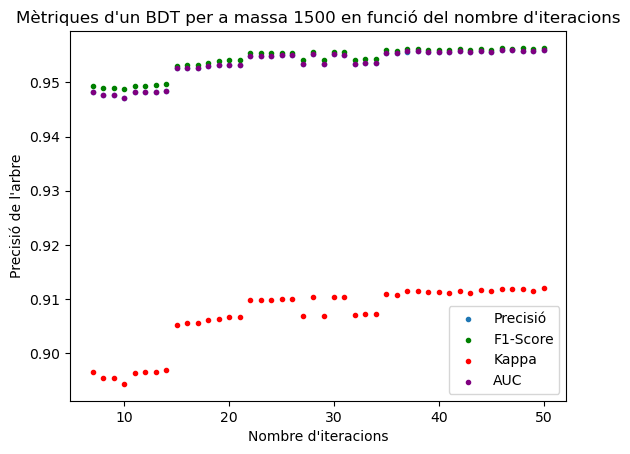

In [73]:
fig, ax = plt.subplots()
ax.scatter(n_estimators, acc, marker='.', label='Precisió')
ax.scatter(n_estimators, F1S, label='F1-Score', marker='.', color='g')
ax.scatter(n_estimators, kappa, label='Kappa', marker='.', color='r')
ax.scatter(n_estimators, AUC, label='AUC', marker='.', color='purple')
ax.legend()
ax.set_xlabel("Nombre d'iteracions")
ax.set_ylabel("Precisió de l'arbre")
ax.set_title("Mètriques d'un BDT per a massa 1500 en funció del nombre d'iteracions")
plt.savefig("C:/Users/alexp/OneDrive/Universitat/5. Quint/TFG/Memòria/Figures/Mesuradors/BDT_depthvar.png")
plt.show()

## 4. Representació mètriques en matriu 2D en funció de profunditat i n_estimators

In [75]:
pip install plotly

  Obtaining dependency information for plotly from https://files.pythonhosted.org/packages/a8/07/72953cf70e3bd3a24cbc3e743e6f8539abe6e3e6d83c3c0c83426eaffd39/plotly-5.18.0-py3-none-any.whl.metadata
  Obtaining dependency information for tenacity>=6.2.0 from https://files.pythonhosted.org/packages/f4/f1/990741d5bb2487d529d20a433210ffa136a367751e454214013b441c4575/tenacity-8.2.3-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/15.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/15.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/15.6 MB 660.6 kB/s eta 0:00:24
   ---------------------------------------- 0.0/15.6 MB 660.6 kB/s eta 0:00:24
   ---------------------------------------- 0.0/15.6 MB 660.6 kB/s eta 0:00:24
   ---------------------------------------- 0.0/15.6 MB 660.6 kB/s eta 0:00:24
   ---------------------------------------- 0.0/15.6 MB 660.6 kB/s eta 0:00:24
   ---------------------------------------- 0.0/15.6 MB 660

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.98, "Estimadors per a RF-750 en funció de la profunditat i el nombre d'iteracions")

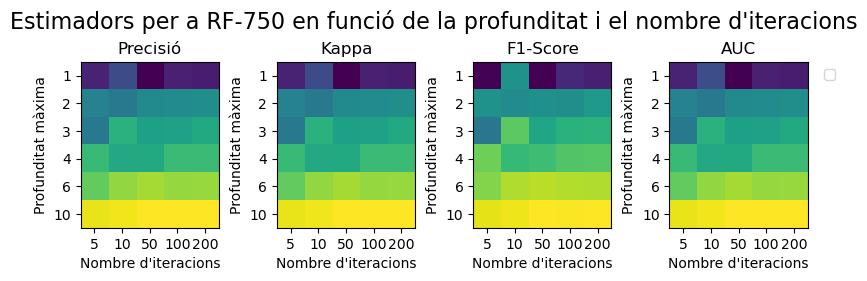

In [76]:
import plotly.express as px

max_depths = ["1","2","3","4","6","10"]
n_estimators = ["5","10","50","100","200"]

acc750 = [[0.806242, 0.811297, 0.802388, 0.805898, 0.805225],
[0.819260, 0.817795, 0.820495, 0.820773, 0.821286],
[0.817875, 0.826796, 0.823960, 0.824153, 0.825497],
[0.828237, 0.825384, 0.825609, 0.828438, 0.828440],
[0.831382, 0.834283, 0.835354, 0.834467, 0.834648],
[0.839298, 0.839645, 0.840403, 0.840531, 0.840526]]

kappa750 = [[0.612489, 0.622652, 0.604795, 0.611818, 0.610470],
[0.638549, 0.635620, 0.641015, 0.641567, 0.642599],
[0.635768, 0.653628, 0.647943, 0.648335, 0.651021],
[0.656508, 0.650798, 0.651250, 0.656904, 0.656907],
[0.662793, 0.668593, 0.670734, 0.668962, 0.669321],
[0.678616, 0.679312, 0.680829, 0.681082, 0.681074]]

F1S750 = [[0.807890, 0.827584, 0.807723, 0.812057, 0.811204],
[0.827787, 0.826542, 0.827397, 0.827081, 0.828741],
[0.823109, 0.836897, 0.830654, 0.832632, 0.832919],
[0.838241, 0.833856, 0.834725, 0.836224, 0.836509],
[0.839585, 0.842177, 0.842749, 0.842286, 0.842218],
[0.845229, 0.845776, 0.846798, 0.846587, 0.846675]]

AUC750 = [[0.806249, 0.811375, 0.802411, 0.805926, 0.805251],
[0.819301, 0.817837, 0.820529, 0.820803, 0.821323],
[0.817900, 0.826848, 0.823993, 0.824195, 0.825534],
[0.828288, 0.825427, 0.825655, 0.828478, 0.828481],
[0.831425, 0.834324, 0.835393, 0.834509, 0.834688],
[0.839330, 0.839679, 0.840438, 0.840564, 0.840560]]

fig, (ax1, ax2,ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(8,3))
fig.tight_layout()

ax1.set_title('Precisió')
ax1.imshow(acc750)
ax1.set_yticks([0,1,2,3,4,5],labels=max_depths)
ax1.set_xticks([0,1,2,3,4],labels=n_estimators)
ax1.set_xlabel("Nombre d'iteracions")
ax1.set_ylabel("Profunditat màxima")

ax2.set_title('Kappa')
ax2.imshow(kappa750)
ax2.set_yticks([0,1,2,3,4,5],labels=max_depths)
ax2.set_xticks([0,1,2,3,4],labels=n_estimators)
ax2.set_xlabel("Nombre d'iteracions")
ax2.set_ylabel("Profunditat màxima")

ax3.set_title('F1-Score')
ax3.imshow(F1S750)
ax3.set_yticks([0,1,2,3,4,5],labels=max_depths)
ax3.set_xticks([0,1,2,3,4],labels=n_estimators)
ax3.set_xlabel("Nombre d'iteracions")
ax3.set_ylabel("Profunditat màxima")

ax4.set_title('AUC')
ax4.imshow(AUC750)
ax4.set_yticks([0,1,2,3,4,5],labels=max_depths)
ax4.set_xticks([0,1,2,3,4],labels=n_estimators)
ax4.set_xlabel("Nombre d'iteracions")
ax4.set_ylabel("Profunditat màxima")

plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1.0))

fig.suptitle("Estimadors per a RF-750 en funció de la profunditat i el nombre d'iteracions", fontsize=16)